## shNfkb1 experiments
12/15/25 - Data generated from shNfkb1 single hairpin experiments; Library included in alignment; data submitted by Jason/Carleigh/Hannah on 5/23 and 5/25/2023
Run on 2 lanes(lane1, lane2)

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","shRenilla",'JCP628-shIkbkg-1.2526','JCP629-shIkbkg-2.2984',
           'JCP618-shRela-1.1202','JCP621-shRela-4.1182','JCP623-shRel-1.1868',
           'JCP625-shRel-3.342','Ikbsr-FLAG',]

## Load adata object

In [6]:
adata = anndata.read_h5ad('write/Nfkb_combined.h5ad')

In [7]:
adata.obs['Group'].value_counts()

Group
Cre             6186
shRenilla       5386
IkbSR-Cre       4053
shNfkb1_2331    2364
shRela           923
shRel            640
shNfkb1          398
shNfkb1_3737     377
Name: count, dtype: int64

In [8]:
# select experimental lanes
adata = adata[adata.obs.batch.isin(['shNfkb1_lane2','shNfkb1_lane1']),:]
# reorder categories
adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['shRenilla','shNfkb1_2331','shNfkb1_3737'])

/tmp/ipykernel_3968806/2979464452.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['shRenilla','shNfkb1_2331','shNfkb1_3737'])


In [9]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = 2

In [10]:
adata.obs[['batch','condition','Classification']].value_counts(sort=False)

batch          condition  Classification
shNfkb1_lane1  control    AW1426_Renilla    1118
                          AW1427_Renilla     723
               perturb    AW1555_2118         50
                          AX1508_2117        856
                          AX1598_2117        621
shNfkb1_lane2  control    AW1725_Renilla    2032
                          AX1128_Renilla    1024
               perturb    AW1552_2117        887
                          AX1123_2118        206
                          AX1672_2118        121
Name: count, dtype: int64

## Evaluate Nfkb1 knockdown and associated genes

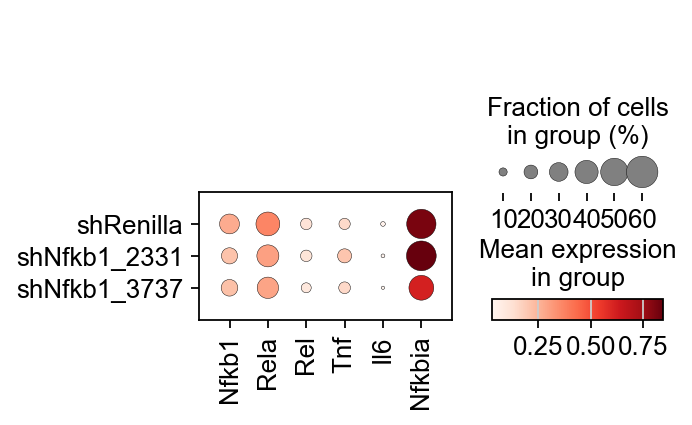

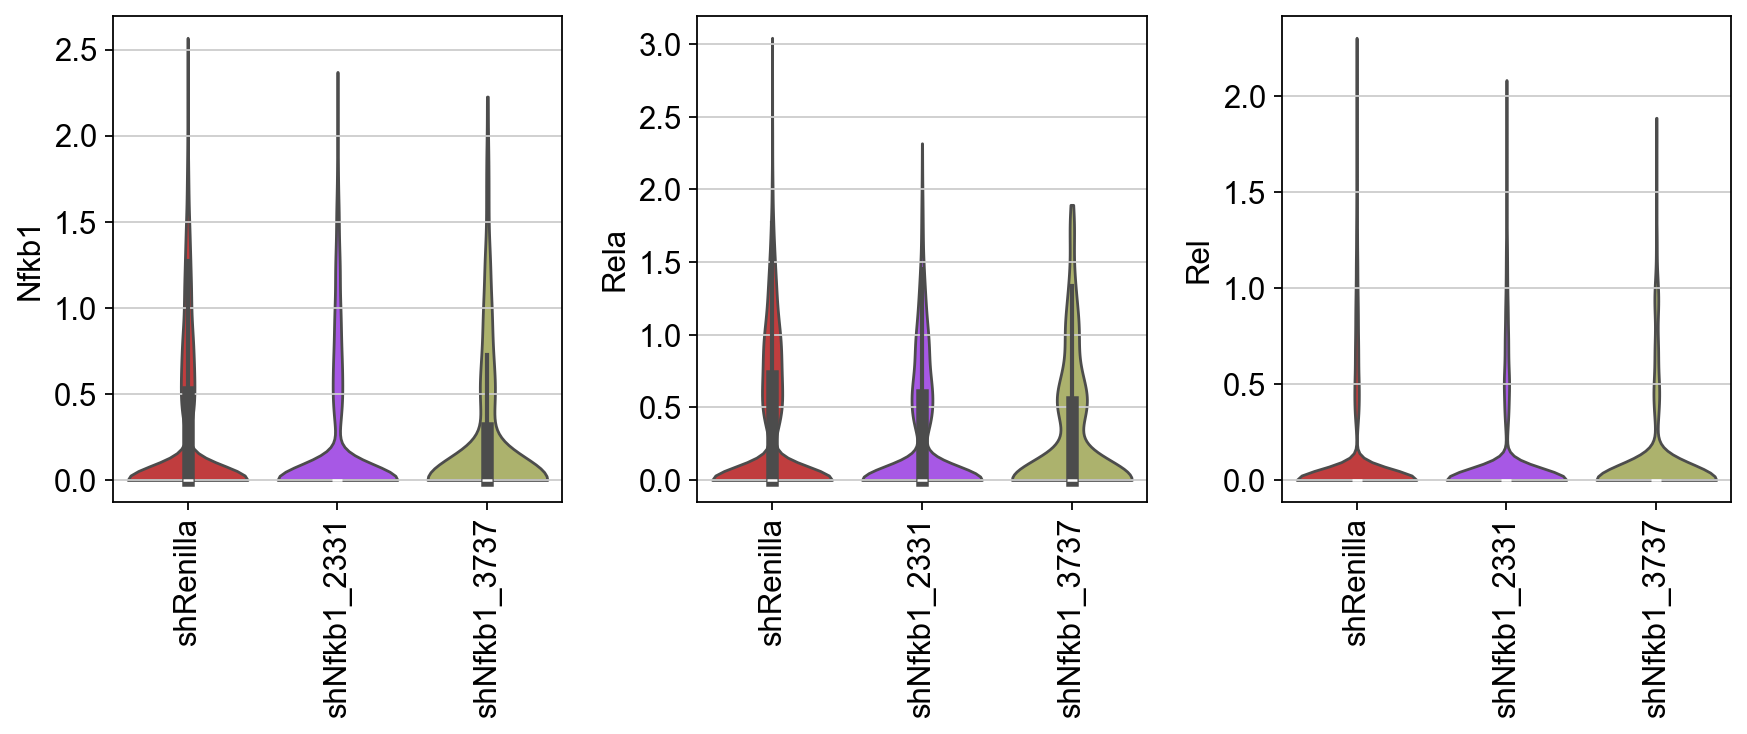

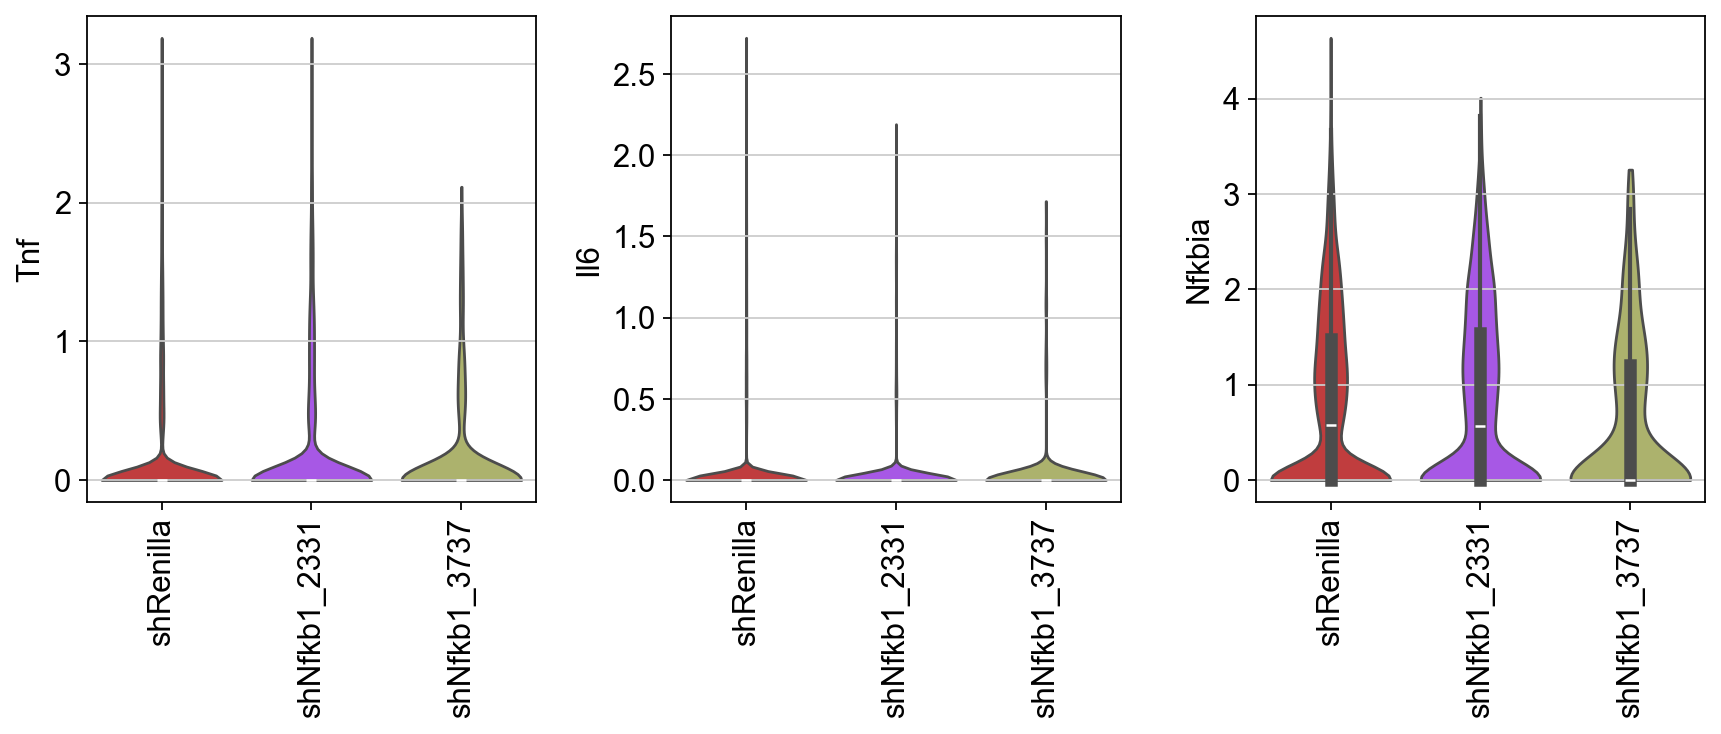

In [11]:
# note p50 (encoded by Nfkb1) creates repressive homodimers and also is an activator with p65, so there might be mixed signal; expect Tnf and Il6 to go down
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group', use_raw=True)
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)


## Now select cells by GFP expression

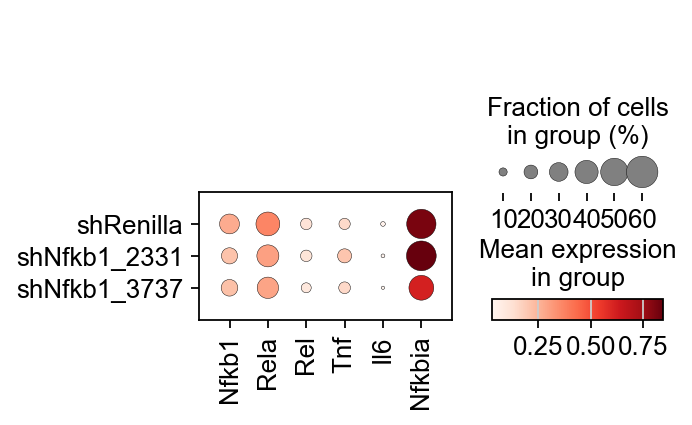

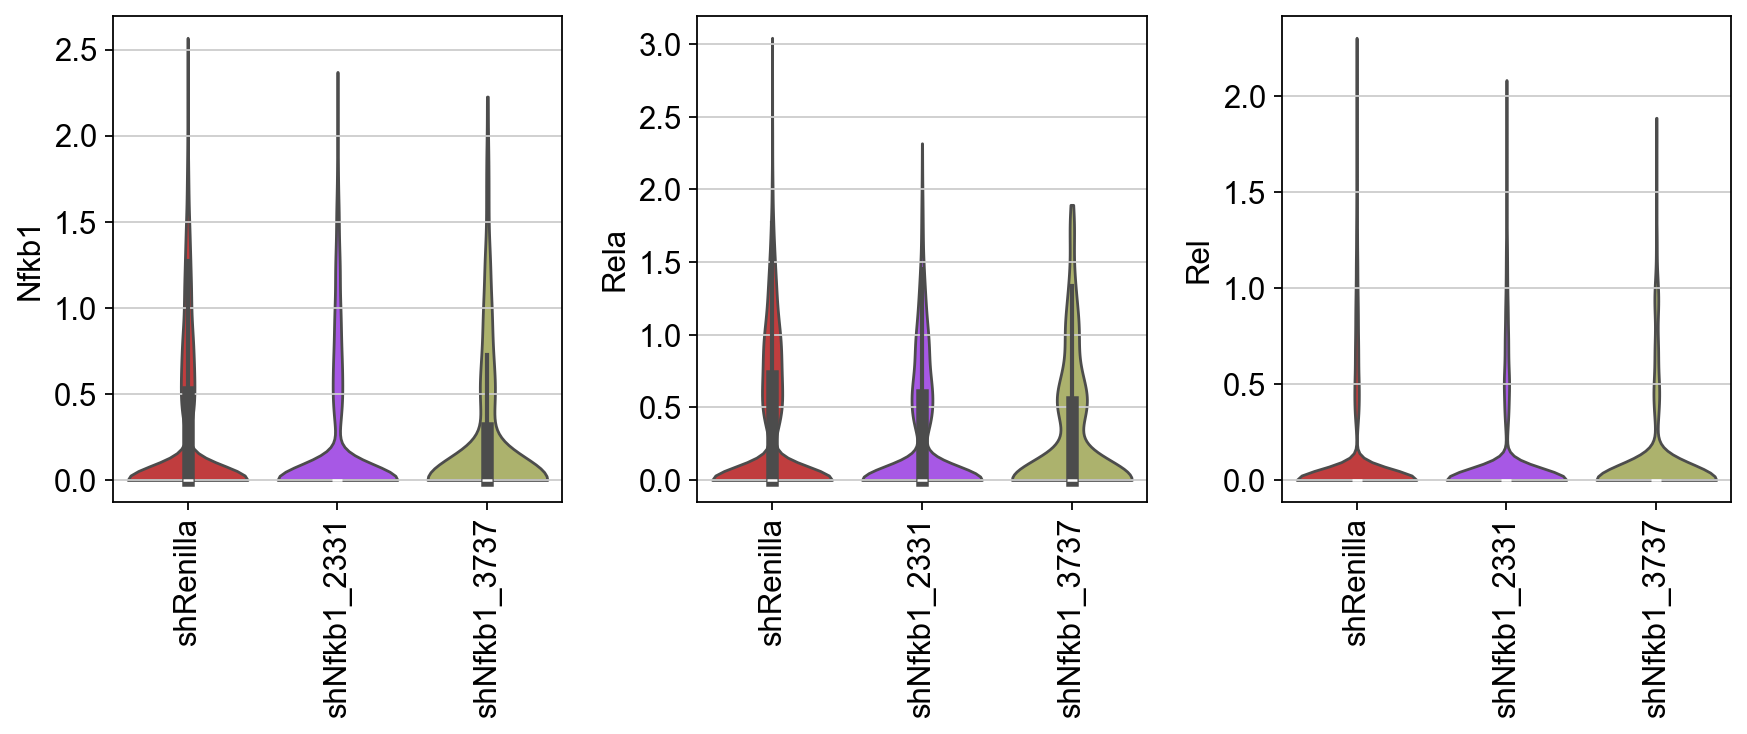

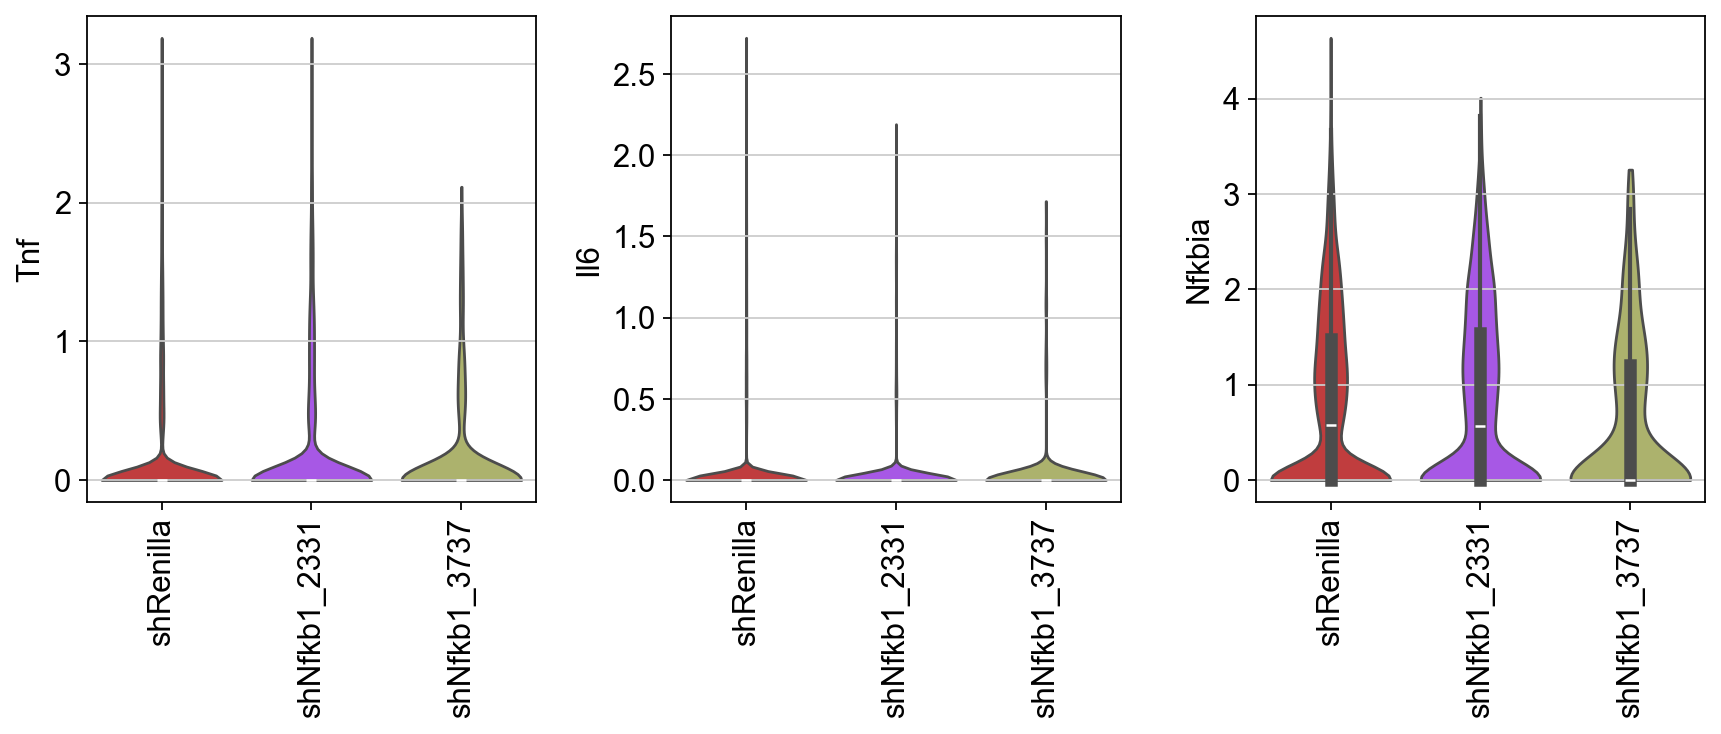

In [12]:
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group')
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False)


In [13]:
import csv
# Define NFκB target gene signatures
nfkb_targets_broad = ['Birc3', 'Bcl2a1a', 'Bcl2a1b', 'Bcl2a1c', 'Bcl2a1d',
                      'Cflar', 'Traf1', 'Ccl5', 'Cxcl1', 'Cxcl2', 
                      'Cxcl10', 'Il1b', 'Ccl3', 'Ccl4']

# Note: Mouse doesn't have CXCL8 (IL-8), but has functional homologs
# Remove Cxcl8 if not in your data, or replace with Cxcl1/Cxcl2
nfkb_targets_classical = ['Tnf', 'Il6', 'Ccl2', 'Icam1', 
                          'Vcam1', 'Nfkbia', 'Nfkbiz', 'Tnfaip3',
                          'Cxcl1', 'Cxcl2']  # Added mouse chemokines

nfkb_genes = [
    "Ager","Alox12b","Apoc3","B2m","Bcl2","Bcl2a1","Bcl2l1","Bcl3","Bdkrb1",
    "Ccl11","Ccl15","Ccl2","Ccl5","Ccnd1","Ccr5","Ccr7","Cd209","Cd3g","Cd40",
    "Cd40lg","Cd44","Cd48","Cd69","Cd74","Cd80","Cd83","Cr2","Crp","Csf1",
    "Csf2","Csf3","Cxcl5","Cxcl8","Cxcr5","Defb4","Elf3","Eng","F3","Fas",
    "Faslg","Gstp1","Hmox1","Icam1","Ier3","Ifnb1","Ighg3","Ighg4","Il11",
    "Il13","Il15","Il15ra","Il1a","Il1b","Il1rn","Il2","Il2ra","Il6","Il9",
    "Irf1","Irf2","Irf4","Irf7","Klk3","Lta","Ltb","Mmp9","Myc","Nfkb1",
    "Nfkb2","Nfkbia","Nod2","Nos2","Nqo1","Nr4a2","Oprm1","Pdgfb","Plau",
    "Plcd1","Psma2","Psmb9","Ptafr","Ptgs2","Ptx3","Relb","S100a6","Scnn1a",
    "Sele","Selp","Slc2a5","Sod2","Stat5a","Tacr1","Tap1","Tfpi2","Tgm2",
    "Tnc","Tnf","Tnfaip3","Tnfrsf9","Tp53","Tpmt","Vcam1","Vegfc","Vim"
]

# Additional important mouse NFκB targets
nfkb_targets_extended = ['Ptgs2', 'Nos2', 'Sod2', 'Csf2', 'Csf3',
                         'Il1a', 'Il1b', 'Ccl20', 'Cxcl10', 'Relb']

# Define p50 targets that are normally repressed by p50 homodimers (encoded by Nfkb1):
p50_targets = ['Ccl2', 'Cxcl10', 'Csf2', 'Mmp13', 'Il6', 'Il1b', 'Nos2', 'Lcn2', 'Batf']

# Hallmark Nfkb genes from mSigDB:
hallmark_nfkb = []
with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                hallmark_nfkb = [x for row in csvreader for x in row]
    
# Score each cell
sc.tl.score_genes(adata, 
                  gene_list=nfkb_targets_classical,
                  score_name='nfkb_classical_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_broad, 
                  score_name='nfkb_broad_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_extended, 
                  score_name='nfkb_extended_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_genes, 
                  score_name='nfkb_genes_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=p50_targets, 
                  score_name='p50_targets',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=hallmark_nfkb, 
                  score_name='hallmark_nfkb',
                  use_raw=True)

computing score 'nfkb_classical_score'
    finished: added
    'nfkb_classical_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)
computing score 'nfkb_broad_score'
    finished: added
    'nfkb_broad_score', score of gene set (adata.obs).
    398 total control genes are used. (0:00:00)
computing score 'nfkb_extended_score'
    finished: added
    'nfkb_extended_score', score of gene set (adata.obs).
    349 total control genes are used. (0:00:00)
computing score 'nfkb_genes_score'
       'Faslg', 'Ighg4', 'Il9', 'Klk3', 'Tp53'],
      dtype='object')
    finished: added
    'nfkb_genes_score', score of gene set (adata.obs).
    992 total control genes are used. (0:00:00)
computing score 'p50_targets'
    finished: added
    'p50_targets', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)
computing score 'hallmark_nfkb'
    finished: added
    'hallmark_nfkb', score of gene set (adata.obs).
    894 total control genes are

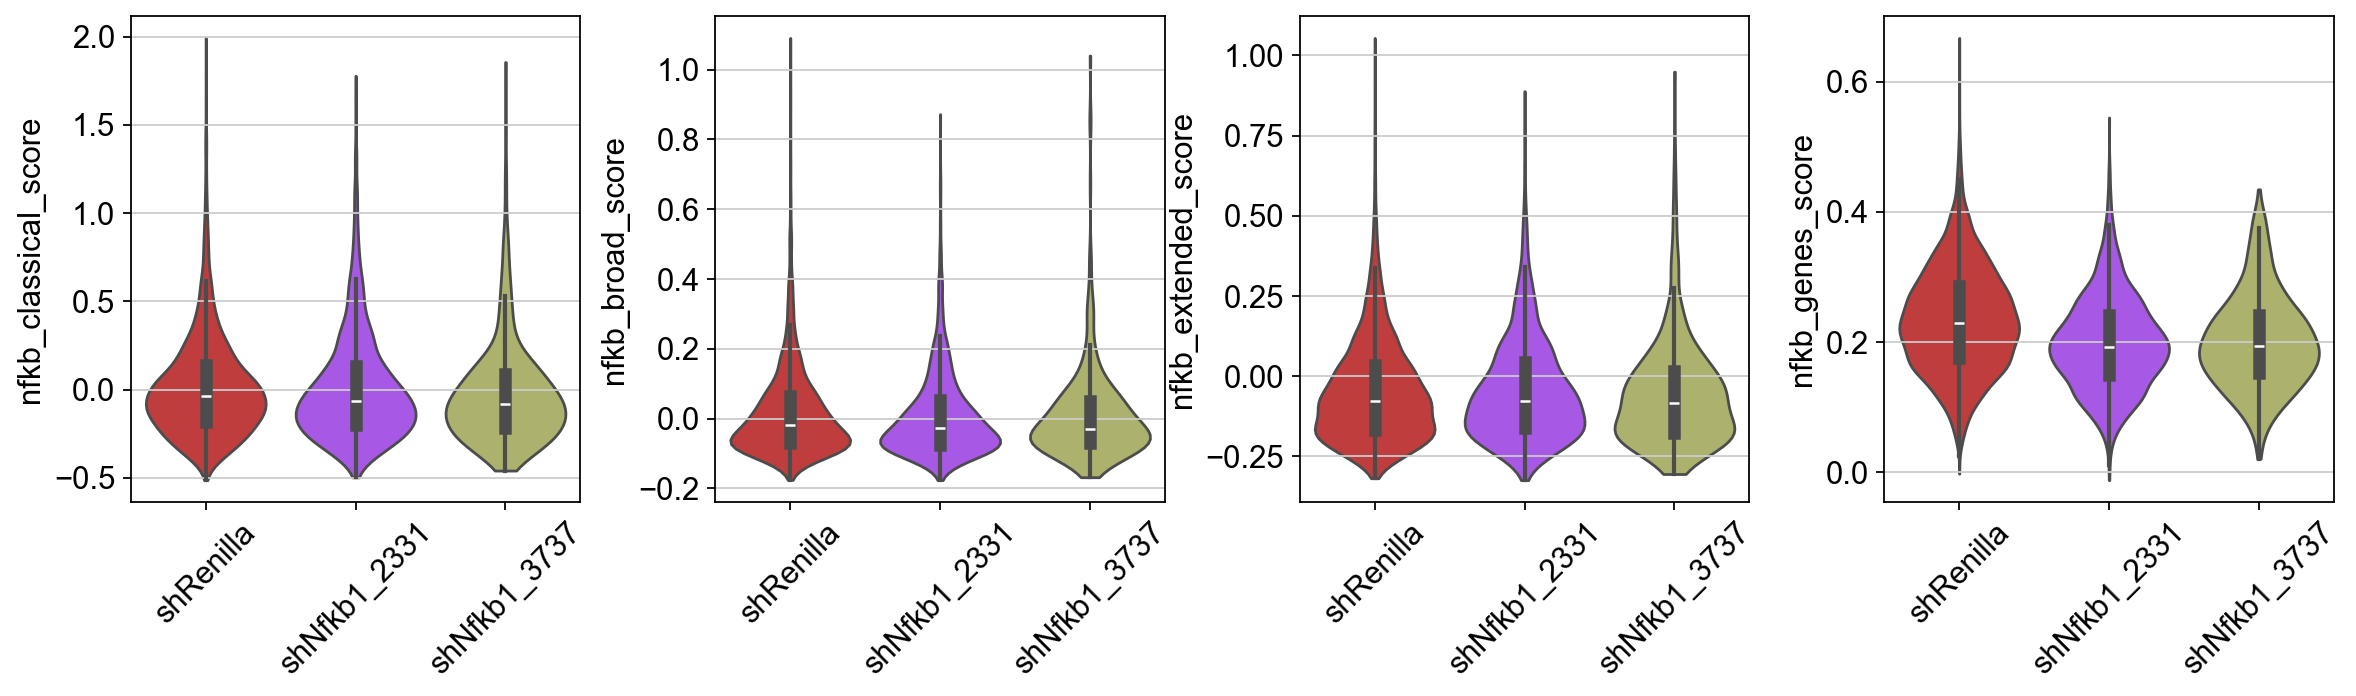

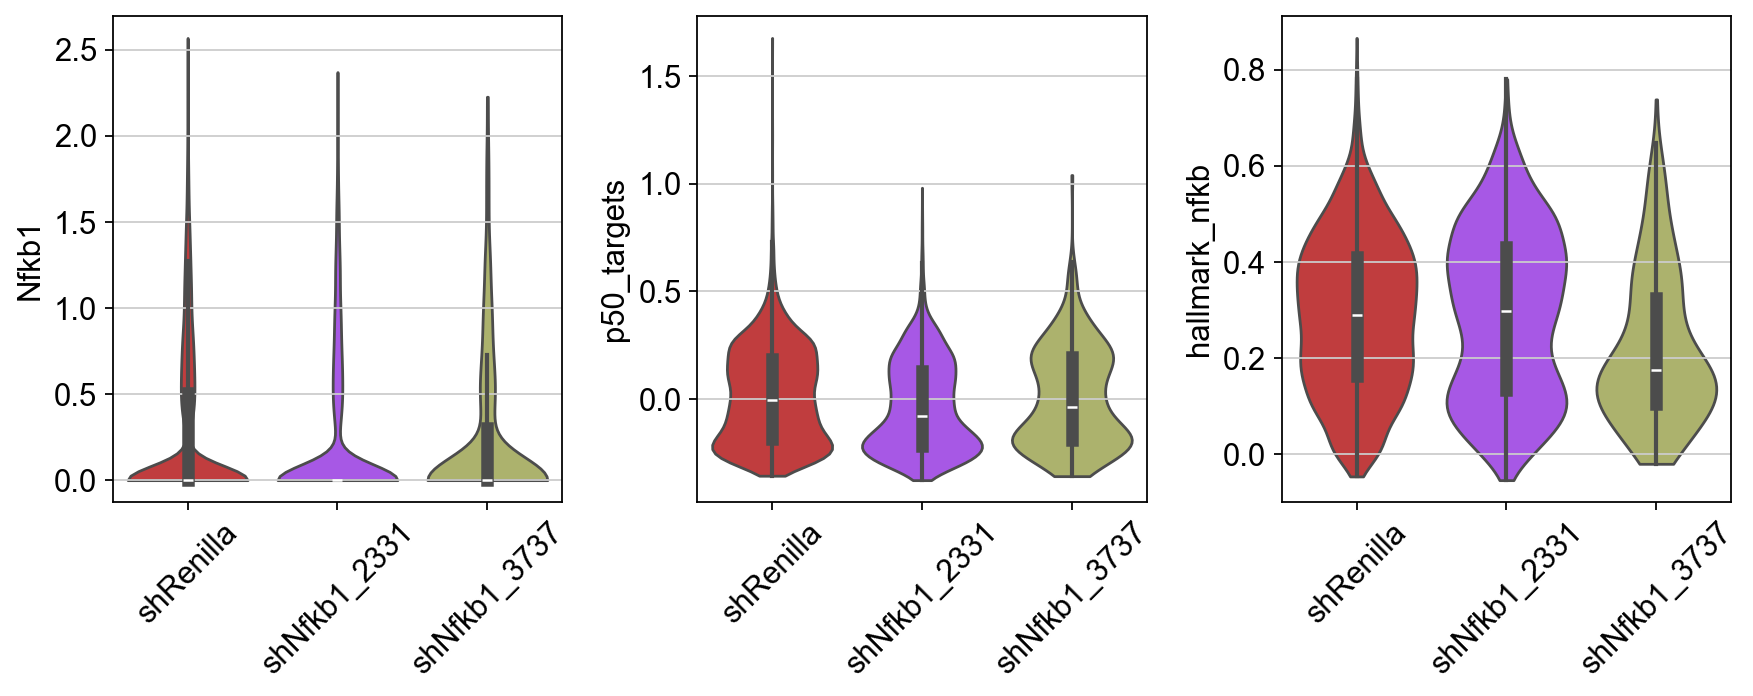

In [14]:
sc.pl.violin(adata, 
             keys=['nfkb_classical_score', 'nfkb_broad_score', 'nfkb_extended_score', 'nfkb_genes_score'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)
sc.pl.violin(adata, 
             keys=['Nfkb1','p50_targets','hallmark_nfkb'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)

In [15]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shNfkb1_2331'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_3737'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0345


In [16]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_3737'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP2 classical score: p={pval:.4f}")

shRenilla vs HP2 classical score: p=0.0004


In [17]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_2331'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP1 classical score: p={pval:.4f}")

shRenilla vs HP1 classical score: p=0.0107


In [18]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_2331'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP1 classical score: p={pval:.4f}")

shRenilla vs HP1 classical score: p=0.0013


In [19]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_3737'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP2 classical score: p={pval:.4f}")

shRenilla vs HP2 classical score: p=0.1420


In [20]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata,
    groupby="Group",                 # shRenilla / Nfkb1_2331 / Nfkb1_3737
    groups=["shNfkb1_2331", "shNfkb1_3737"],
    reference="shRenilla",
    method="wilcoxon",
    use_raw=True
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


In [21]:
df_2331 = sc.get.rank_genes_groups_df(adata, group="shNfkb1_2331")
df_3737 = sc.get.rank_genes_groups_df(adata, group="shNfkb1_3737")

df_2331[df_2331["names"] == "Nfkb1"]


names    scores  logfoldchanges         pvals  pvals_adj
29780  Nfkb1 -5.202935       -0.387725  1.961654e-07    0.00001

In [22]:
df_3737[df_3737["names"] == "Nfkb1"]

names    scores  logfoldchanges     pvals  pvals_adj
29282  Nfkb1 -2.251486       -0.352861  0.024355   0.765537

In [23]:
import pandas as pd

df = adata.obs.copy()
df["Nfkb1_expr"] = (
    adata.raw[:, "Nfkb1"].X.A1
    if hasattr(adata.raw[:, "Nfkb1"].X, "A1")
    else adata.raw[:, "Nfkb1"].X.toarray().ravel()
)

pb = (
    df.groupby(["Classification", "Group"])["Nfkb1_expr"]
      .mean()
      .reset_index()
)

/tmp/ipykernel_3968806/1904172550.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Nfkb1_expr"]


Text(0, 0.5, 'Mean Nfkb1 expression per mouse')

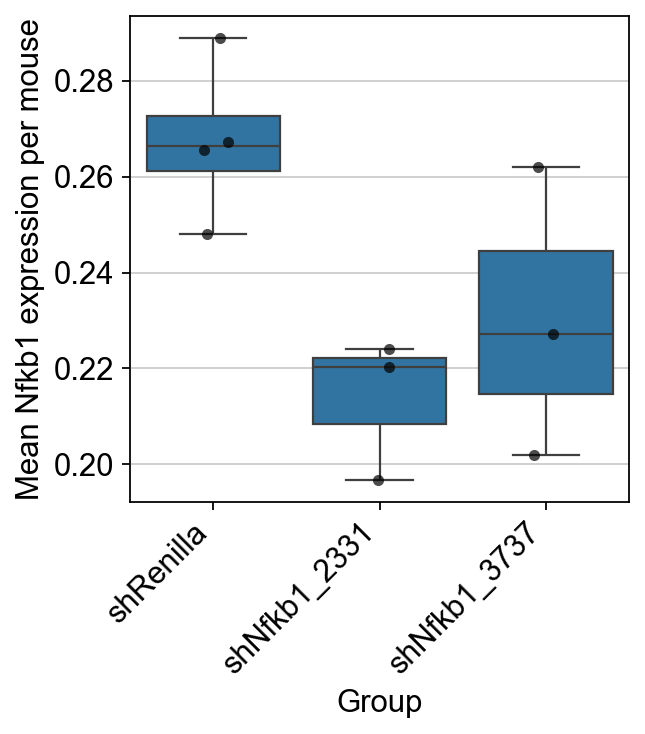

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    showfliers=False,
)
sns.stripplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Nfkb1 expression per mouse")



Rows (mouse × group): 10

Mice per group:
 Group
shRenilla       4
shNfkb1_2331    3
shNfkb1_3737    3
Name: count, dtype: int64

Cells per mouse×group summary:
               count         mean         std    min     25%     50%     75%  \
Group                                                                         
shNfkb1_2331    3.0   788.000000  145.454460  621.0  738.50   856.0   871.5   
shNfkb1_3737    3.0   125.666667   78.104631   50.0   85.50   121.0   163.5   
shRenilla       4.0  1224.250000  564.240123  723.0  948.75  1071.0  1346.5   

                 max  
Group                 
shNfkb1_2331   887.0  
shNfkb1_3737   206.0  
shRenilla     2032.0  


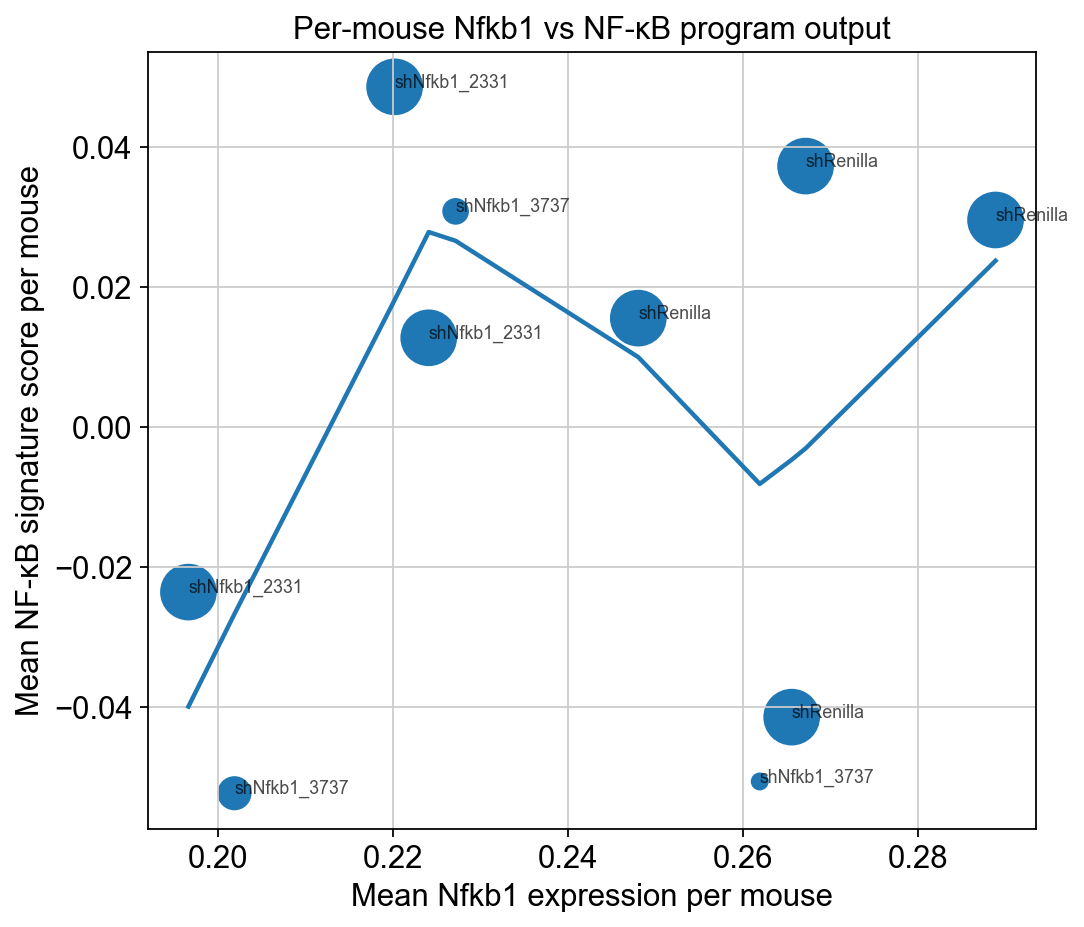

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# -----------------------------
# USER SETTINGS (edit these)
# -----------------------------
MOUSE_COL   = "Classification"
GROUP_COL   = "Group"          # shRenilla / Nfkb1_2331 / Nfkb1_3737
GENE        = "Nfkb1"
SCORE_COL   = "nfkb_classical_score"       # must already exist in adata.obs, OR compute below
COUNTS_LAYER_FOR_SCORE = None    # leave None unless you want to force use_raw/layer logic

# Optional: subset to a celltype (recommended if mixed)
CELLTYPE_COL = None   # e.g., "celltype"
KEEP_CELLTYPE = None  # e.g., "Tumor"

# Optional: compute the NF-κB score here (replace gene list!)
COMPUTE_SCORE = False
NFkB_GENESET = ["Nfkbia", "Tnfaip3", "Rel", "Relb", "Icam1", "Cxcl1", "Cxcl2", "Il1b"]


# -----------------------------
# (Optional) subset cells
# -----------------------------
adata_use = adata
if CELLTYPE_COL is not None and KEEP_CELLTYPE is not None:
    adata_use = adata[adata.obs[CELLTYPE_COL].astype(str) == str(KEEP_CELLTYPE)].copy()
    print(f"Using subset: {adata_use.n_obs} cells where {CELLTYPE_COL} == {KEEP_CELLTYPE}")

# -----------------------------
# (Optional) compute signature score
# -----------------------------
if COMPUTE_SCORE:
    import scanpy as sc
    genes_present = [g for g in NFkB_GENESET if g in adata_use.var_names]
    if len(genes_present) < 5:
        raise ValueError(f"Too few NF-κB genes found in adata.var_names: {genes_present}")
    sc.tl.score_genes(adata_use, gene_list=genes_present, score_name=SCORE_COL, use_raw=False)
    print(f"Computed {SCORE_COL} using {len(genes_present)} genes.")

if SCORE_COL not in adata_use.obs.columns:
    raise ValueError(
        f"Missing adata.obs['{SCORE_COL}']. Set COMPUTE_SCORE=True or provide your precomputed score."
    )

# -----------------------------
# Extract per-cell Nfkb1 expression
# -----------------------------
if GENE not in adata_use.var_names:
    # case-insensitive fallback
    lower_map = {g.lower(): g for g in adata_use.var_names}
    if GENE.lower() in lower_map:
        print(f"NOTE: '{GENE}' not found exactly; using '{lower_map[GENE.lower()]}' instead.")
        GENE = lower_map[GENE.lower()]
    else:
        raise ValueError(f"Gene '{GENE}' not found in adata.var_names.")

Xg = adata_use.raw[:, GENE].X
if sp.issparse(Xg):
    nfkb1_expr = Xg.toarray().ravel()
else:
    nfkb1_expr = np.asarray(Xg).ravel()

# -----------------------------
# Build per-cell dataframe
# -----------------------------
for col in [MOUSE_COL, GROUP_COL]:
    if col not in adata_use.obs.columns:
        raise ValueError(f"Missing adata.obs['{col}'].")

df = adata_use.obs[[MOUSE_COL, GROUP_COL]].copy()
df[MOUSE_COL] = df[MOUSE_COL].astype(str)
df[GROUP_COL] = df[GROUP_COL].astype(str)
df["nfkb1_expr"] = nfkb1_expr
df[SCORE_COL] = adata_use.obs[SCORE_COL].values

# -----------------------------
# Aggregate per mouse (and group)
# -----------------------------
pb = (df.groupby([MOUSE_COL, GROUP_COL])
        .agg(
            nfkb1_mean=("nfkb1_expr", "mean"),
            nfkb_score_mean=(SCORE_COL, "mean"),
            n_cells=("nfkb1_expr", "size"),
        )
        .reset_index())

print("\nRows (mouse × group):", pb.shape[0])
print("\nMice per group:\n", pb[GROUP_COL].value_counts())
print("\nCells per mouse×group summary:\n", pb.groupby(GROUP_COL)["n_cells"].describe())

# -----------------------------
# Plot: x = mean Nfkb1 per mouse, y = mean NF-κB score per mouse
# Point size encodes n_cells (optional), and we label by group.
# -----------------------------
plt.figure(figsize=(7, 6))

sizes = np.clip(pb["n_cells"].values, 50, 600)  # optional sizing by cells
plt.scatter(pb["nfkb1_mean"], pb["nfkb_score_mean"], s=sizes)

# annotate each point with perturb label (can be noisy if many mice)
for _, r in pb.iterrows():
    plt.text(r["nfkb1_mean"], r["nfkb_score_mean"], r[GROUP_COL], fontsize=8, alpha=0.7)

plt.xlabel("Mean Nfkb1 expression per mouse")
plt.ylabel("Mean NF-κB signature score per mouse")
plt.title("Per-mouse Nfkb1 vs NF-κB program output")

# Add a smoother to reveal nonlinearity (LOWESS if available; else quadratic fit)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna().sort_values("nfkb1_mean")
    sm = lowess(xy["nfkb_score_mean"], xy["nfkb1_mean"], frac=0.6, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], linewidth=2)
except Exception:
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna()
    if len(xy) >= 5:
        xs = np.linspace(xy["nfkb1_mean"].min(), xy["nfkb1_mean"].max(), 200)
        coeff = np.polyfit(xy["nfkb1_mean"], xy["nfkb_score_mean"], deg=2)
        plt.plot(xs, np.polyval(coeff, xs), linewidth=2)

plt.tight_layout()
plt.show()


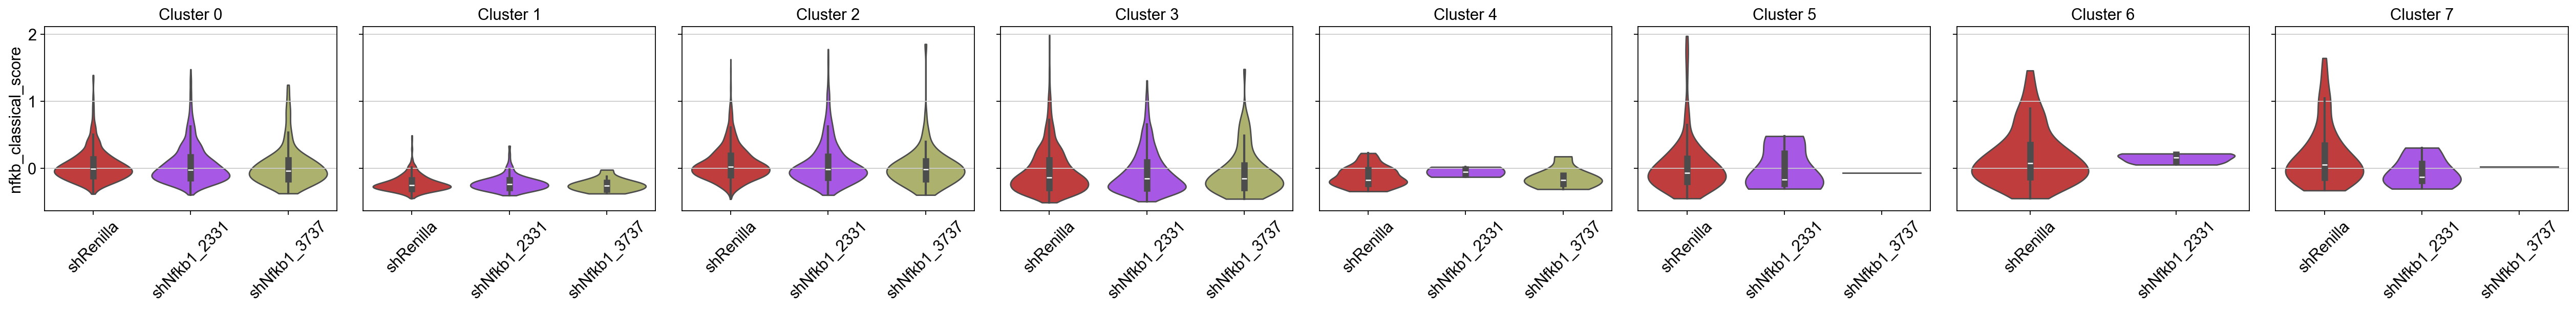

In [26]:
import matplotlib.pyplot as plt

# Get unique clusters
clusters = sorted(adata.obs['leiden'].unique())

# Create subplots
fig, axes = plt.subplots(1, len(clusters), figsize=(4*len(clusters), 4), sharey=True)
if len(clusters) == 1:
    axes = [axes]

for ax, cluster in zip(axes, clusters):
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    sc.pl.violin(adata_cluster,
                 keys='nfkb_classical_score',
                 groupby='Group',
                 ax=ax,
                 show=False, rotation=45, stripplot=False, inner='box')
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

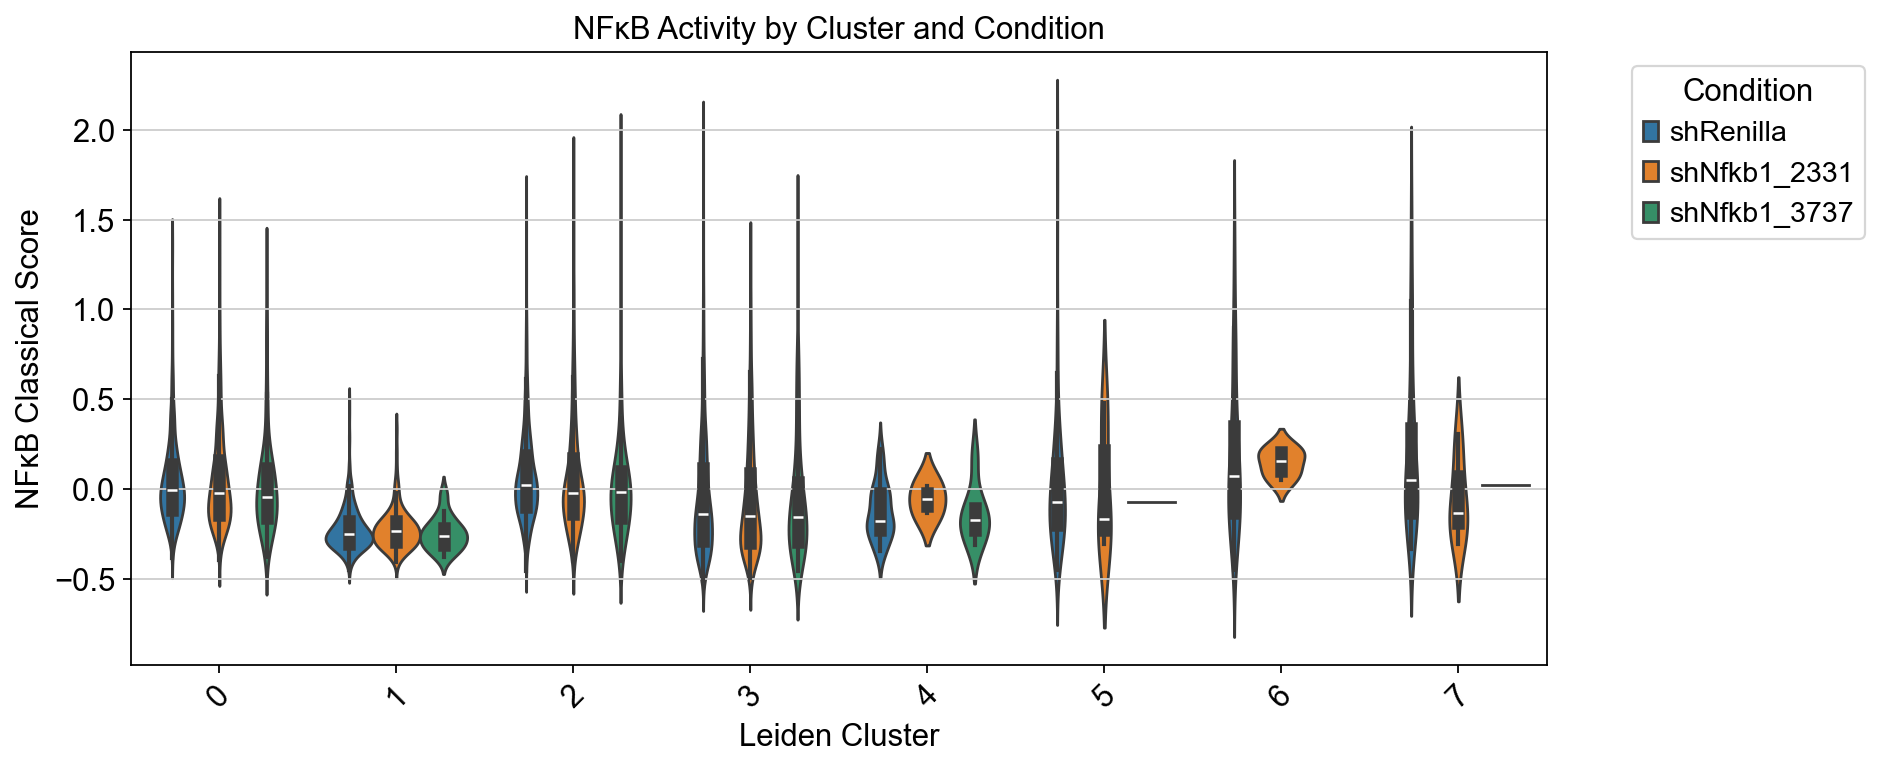

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
plot_data = adata.obs[['leiden', 'Group', 'nfkb_classical_score']].copy()

# Create the plot
plt.figure(figsize=(12, 5))
sns.violinplot(data=plot_data,
               x='leiden',
               y='nfkb_classical_score',
               hue='Group',
               split=False,  # Set to True if you want split violins
               inner='box')
plt.xticks(rotation=45)
plt.xlabel('Leiden Cluster')
plt.ylabel('NFκB Classical Score')
plt.title('NFκB Activity by Cluster and Condition')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Compare HP1 vs HP2 within each cluster
cluster_comparisons = []

for cluster in adata.obs['leiden'].unique():
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    # Get scores for each group
    ctrl_scores = adata_cluster[adata_cluster.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
    hp1_scores = adata_cluster[adata_cluster.obs['Group']=='shNfkb1_2331'].obs['nfkb_classical_score']
    hp2_scores = adata_cluster[adata_cluster.obs['Group']=='shNfkb1_3737'].obs['nfkb_classical_score']
    
    # Statistical tests
    if len(hp1_scores) > 0 and len(ctrl_scores) > 0:
        _, pval_hp1 = mannwhitneyu(hp1_scores, ctrl_scores)
    else:
        pval_hp1 = None
        
    if len(hp2_scores) > 0 and len(ctrl_scores) > 0:
        _, pval_hp2 = mannwhitneyu(hp2_scores, ctrl_scores)
    else:
        pval_hp2 = None
        
    if len(hp1_scores) > 0 and len(hp2_scores) > 0:
        _, pval_hp1_vs_hp2 = mannwhitneyu(hp1_scores, hp2_scores)
    else:
        pval_hp1_vs_hp2 = None
    
    cluster_comparisons.append({
        'cluster': cluster,
        'n_ctrl': len(ctrl_scores),
        'n_hp1': len(hp1_scores),
        'n_hp2': len(hp2_scores),
        'mean_ctrl': ctrl_scores.mean() if len(ctrl_scores) > 0 else None,
        'mean_hp1': hp1_scores.mean() if len(hp1_scores) > 0 else None,
        'mean_hp2': hp2_scores.mean() if len(hp2_scores) > 0 else None,
        'pval_hp1_vs_ctrl': pval_hp1,
        'pval_hp2_vs_ctrl': pval_hp2,
        'pval_hp1_vs_hp2': pval_hp1_vs_hp2
    })

comparison_df = pd.DataFrame(cluster_comparisons)
print(comparison_df.to_string())

# Identify clusters where HP1 and HP2 differ
sig_diff_clusters = comparison_df[comparison_df['pval_hp1_vs_hp2'] < 0.05]
if len(sig_diff_clusters) > 0:
    print(f"\nClusters with significant HP1 vs HP2 difference:")
    print(sig_diff_clusters[['cluster', 'mean_hp1', 'mean_hp2', 'pval_hp1_vs_hp2']])
else:
    print("\nNo clusters show significant difference between HP1 and HP2")

  cluster  n_ctrl  n_hp1  n_hp2  mean_ctrl  mean_hp1  mean_hp2  pval_hp1_vs_ctrl  pval_hp2_vs_ctrl  pval_hp1_vs_hp2
0       3    1170    684     96  -0.040654 -0.058549 -0.064010          0.217963          0.433103         0.865367
1       1     389    123     28  -0.224970 -0.222539 -0.247585          0.613190          0.443989         0.297713
2       2    1629    539     93   0.071332  0.063762  0.007092          0.001542          0.002832         0.221265
3       0    1407   1000    151   0.041850  0.054205  0.025496          0.307629          0.048683         0.169345
4       6      57      4      0   0.167071  0.146150       NaN          0.602872               NaN              NaN
5       5     127      6      1   0.031312 -0.011158 -0.072756          0.747028          1.000000         0.857143
6       4      40      2      7  -0.123630 -0.056944 -0.140869          0.334495          0.736676         0.500000
7       7      78      6      1   0.185676 -0.055788  0.024066          

Group
shRenilla       4897
shNfkb1_2331    2364
shNfkb1_3737     377
Name: count, dtype: int64
computing score 'prolif_score'
    finished: added
    'prolif_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'apoptosis_score'
    finished: added
    'apoptosis_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'repressor_score'
    finished: added
    'repressor_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


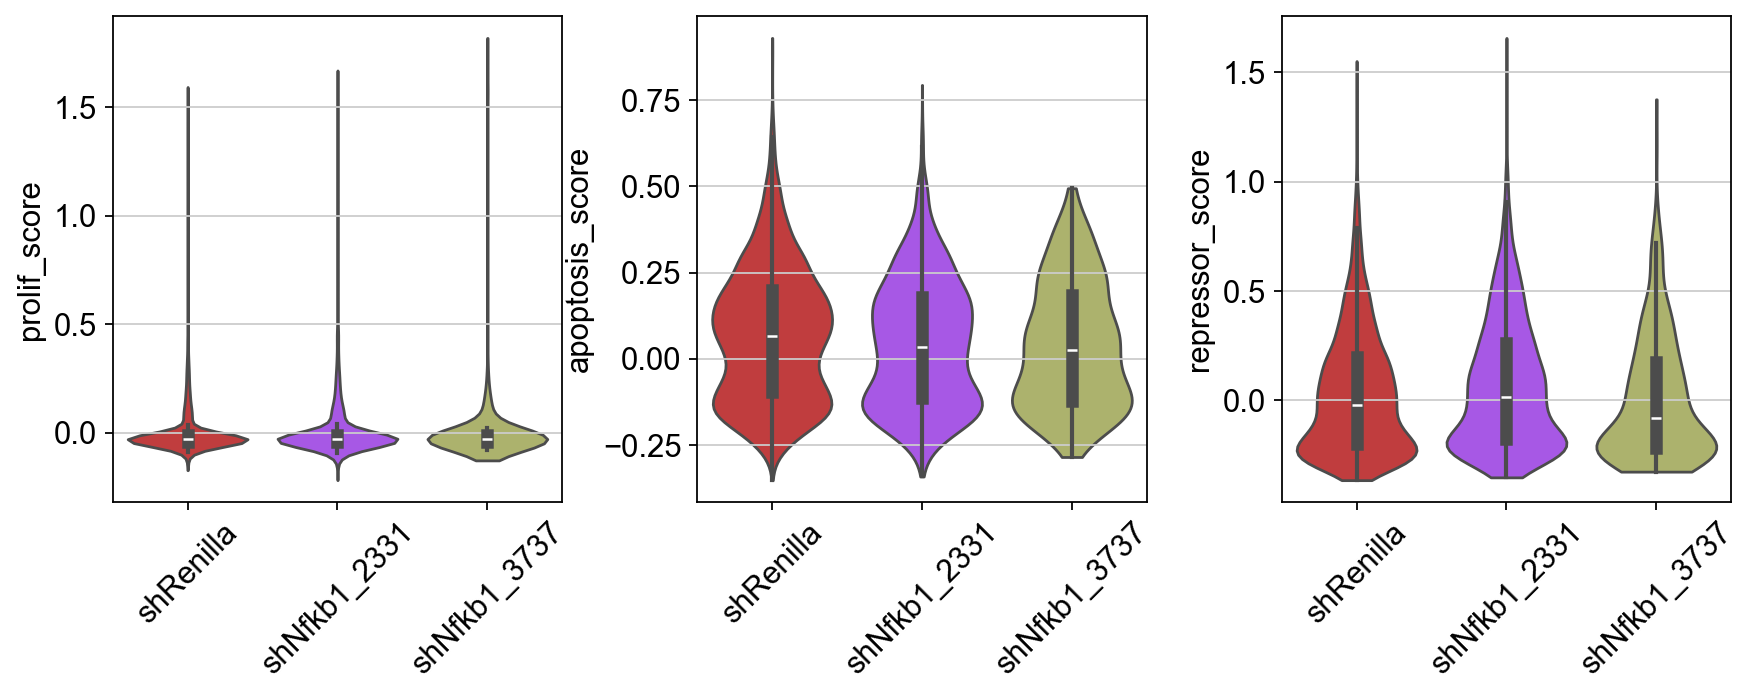

In [29]:
# Check if HP2 has fewer cells in scRNA-seq
cell_counts = adata.obs['Group'].value_counts()
print(cell_counts)

# If HP2 has dramatically fewer cells than HP1, this supports selection

# Look at proliferation/apoptosis markers
proliferation_genes = ['Mki67', 'Pcna', 'Top2a', 'Ccnb1']
apoptosis_genes = ['Bax', 'Bak1', 'Casp3', 'Casp7', 'Casp9']
repressor_genes = ['Nfkbia', 'Nos2', 'Ptgs2', 'Il12b', 'Ccl2']

# Score these
sc.tl.score_genes(adata, gene_list=proliferation_genes, score_name='prolif_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=apoptosis_genes, score_name='apoptosis_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=repressor_genes, score_name='repressor_score',use_raw=True)

# Compare
sc.pl.violin(adata, keys=['prolif_score', 'apoptosis_score','repressor_score'], 
             groupby='Group',rotation=45, stripplot=False, inner='box')

# If HP2 cells have LOWER proliferation than HP1,
# but tumor burden isn't reduced → selection for slow-cycling resistant cells

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


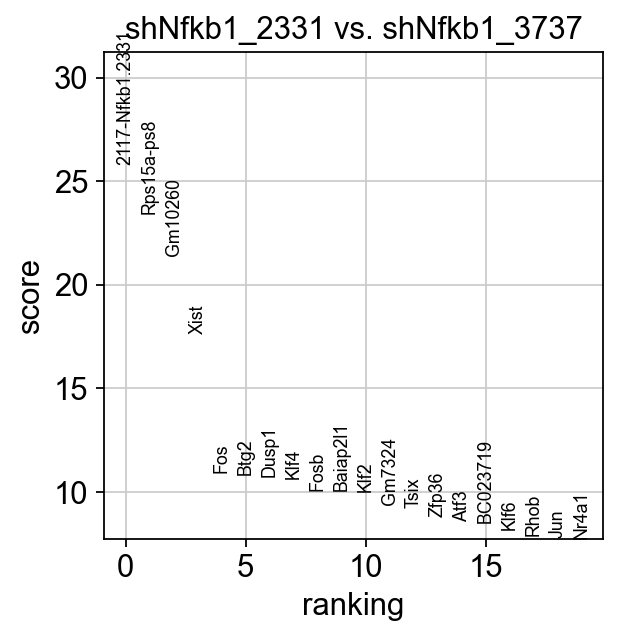

In [30]:
sc.tl.rank_genes_groups(adata, groupby='Group', reference='shNfkb1_3737', groups=['shNfkb1_2331'],use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=20)

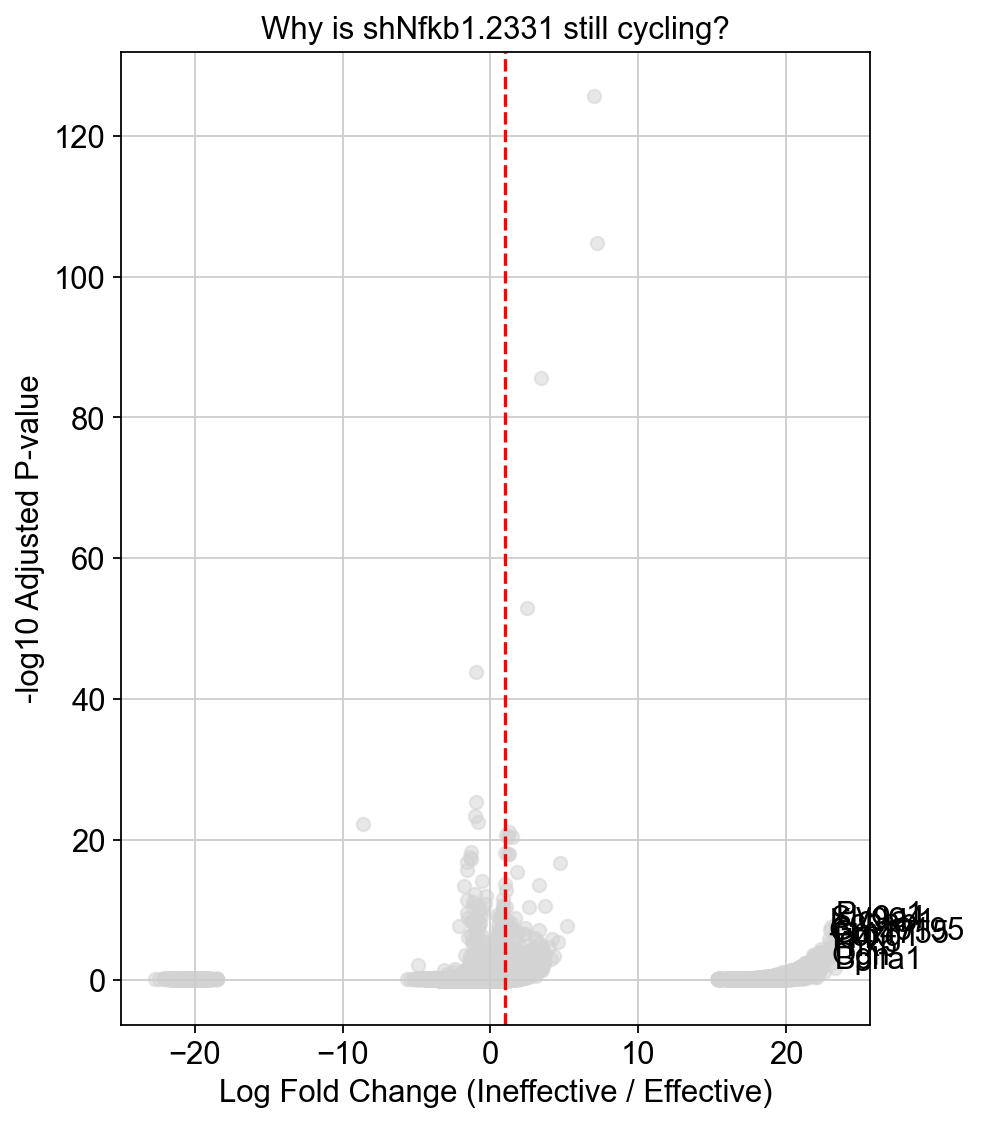

In [31]:
# 2. Extract the data for the volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1_2331'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1_2331'],
    'pvals_adj': result['pvals_adj']['shNfkb1_2331']
})

# 3. Plotting
plt.figure(figsize=(6, 8))
plt.scatter(df['logfoldchanges'], -np.log10(df['pvals_adj'] + 1e-300), 
            alpha=0.5, c='lightgrey')

# Highlight top cycling and NF-kB genes
top_genes = df[df['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False).head(10)
for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj'] + 1e-300), row['gene'])

plt.axvline(1, color='red', linestyle='--')
plt.xlabel('Log Fold Change (Ineffective / Effective)')
plt.ylabel('-log10 Adjusted P-value')
plt.title('Why is shNfkb1.2331 still cycling?')
plt.show()

In [32]:
import gseapy as gp

# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))

                                 Term  Adjusted P-value  Combined Score
0       TNF-alpha Signaling via NF-kB      7.178521e-19      313.674936
1                             Hypoxia      9.390313e-06       50.970121
2   Epithelial Mesenchymal Transition      7.024518e-04       28.544769
3              Estrogen Response Late      1.523082e-03       24.203568
4             Estrogen Response Early      2.093196e-03       20.319903
5                          Glycolysis      2.093196e-03       20.319903
6                         p53 Pathway      2.093196e-03       20.319903
7                   KRAS Signaling Up      2.093196e-03       20.319903
8                    mTORC1 Signaling      4.853931e-03       16.869659
9             Cholesterol Homeostasis      5.033594e-03       24.263488
10                     UV Response Up      5.033594e-03       17.469289
11                          Apoptosis      1.462070e-02       13.202754
12              Inflammatory Response      4.279608e-02        8

In [33]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shNfkb1_2331'].obs['prolif_score']
hp2_classical = adata[adata.obs['Group']=='shNfkb1_3737'].obs['prolif_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.3557


## Explore Phase

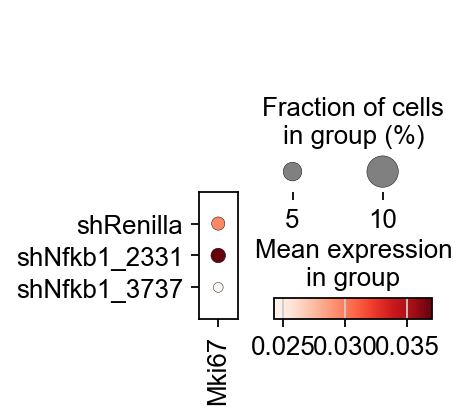

In [34]:
sc.pl.dotplot(adata,['Mki67'],groupby='Group',use_raw=True)

In [35]:
cell_cycle_genes = [x.strip() for x in open('../../common_files/regev_lab_cell_cycle_genes_mouse.txt')]

In [36]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [37]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes,use_raw=True)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    516 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    514 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA
    with n_comps=12


/home/chanj2/part2a-decoupler/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


    finished (0:00:01)


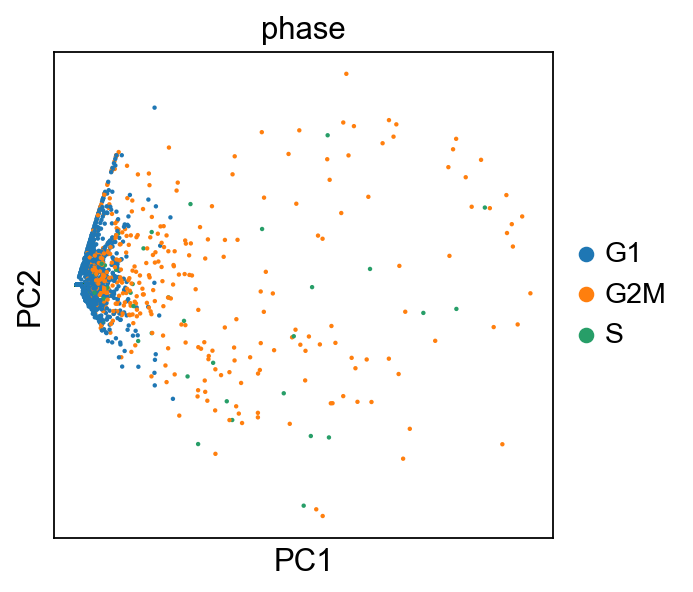

In [38]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

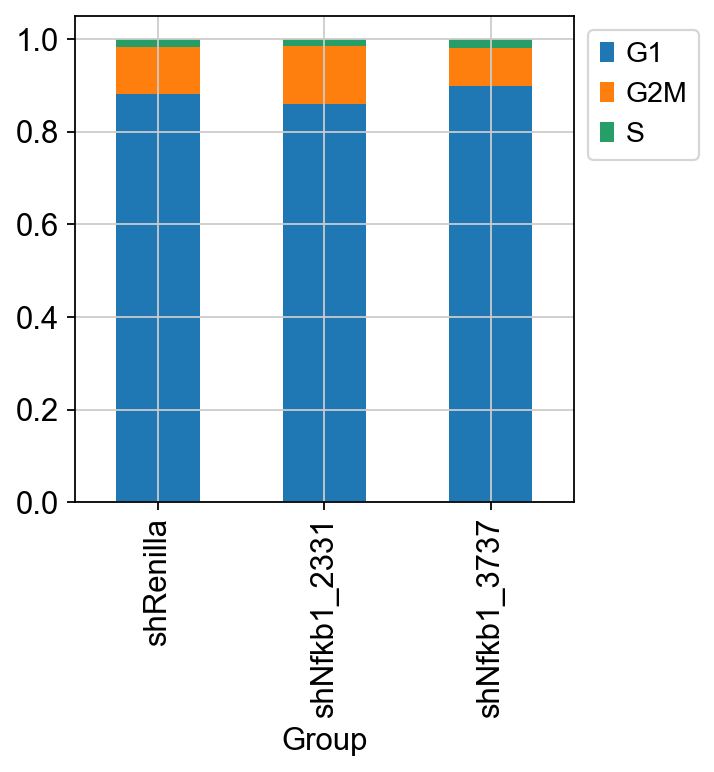

In [39]:
 cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [40]:
cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T
cell_proportion_df

phase               G1       G2M         S
Group                                     
shRenilla     0.881560  0.101899  0.016541
shNfkb1_2331  0.859983  0.125212  0.014805
shNfkb1_3737  0.899204  0.082228  0.018568

In [41]:
adata.obs[['Classification','Group','phase']].value_counts(sort=False)


Classification  Group         phase
AW1426_Renilla  shRenilla     G1        979
                              G2M       126
                              S          13
AW1427_Renilla  shRenilla     G1        613
                              G2M        93
                              S          17
AW1552_2117     shNfkb1_2331  G1        740
                              G2M       134
                              S          13
AW1555_2118     shNfkb1_3737  G1         47
                              G2M         2
                              S           1
AW1725_Renilla  shRenilla     G1       1815
                              G2M       184
                              S          33
AX1123_2118     shNfkb1_3737  G1        182
                              G2M        19
                              S           5
AX1128_Renilla  shRenilla     G1        910
                              G2M        96
                              S          18
AX1508_2117     shNfkb1_2331  G1        

computing score 'STAT3_score'
    finished: added
    'STAT3_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'PI3K/AKT_score'
    finished: added
    'PI3K/AKT_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'WNT_score'
    finished: added
    'WNT_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'MAPK_score'
    finished: added
    'MAPK_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'HIF_score'
    finished: added
    'HIF_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


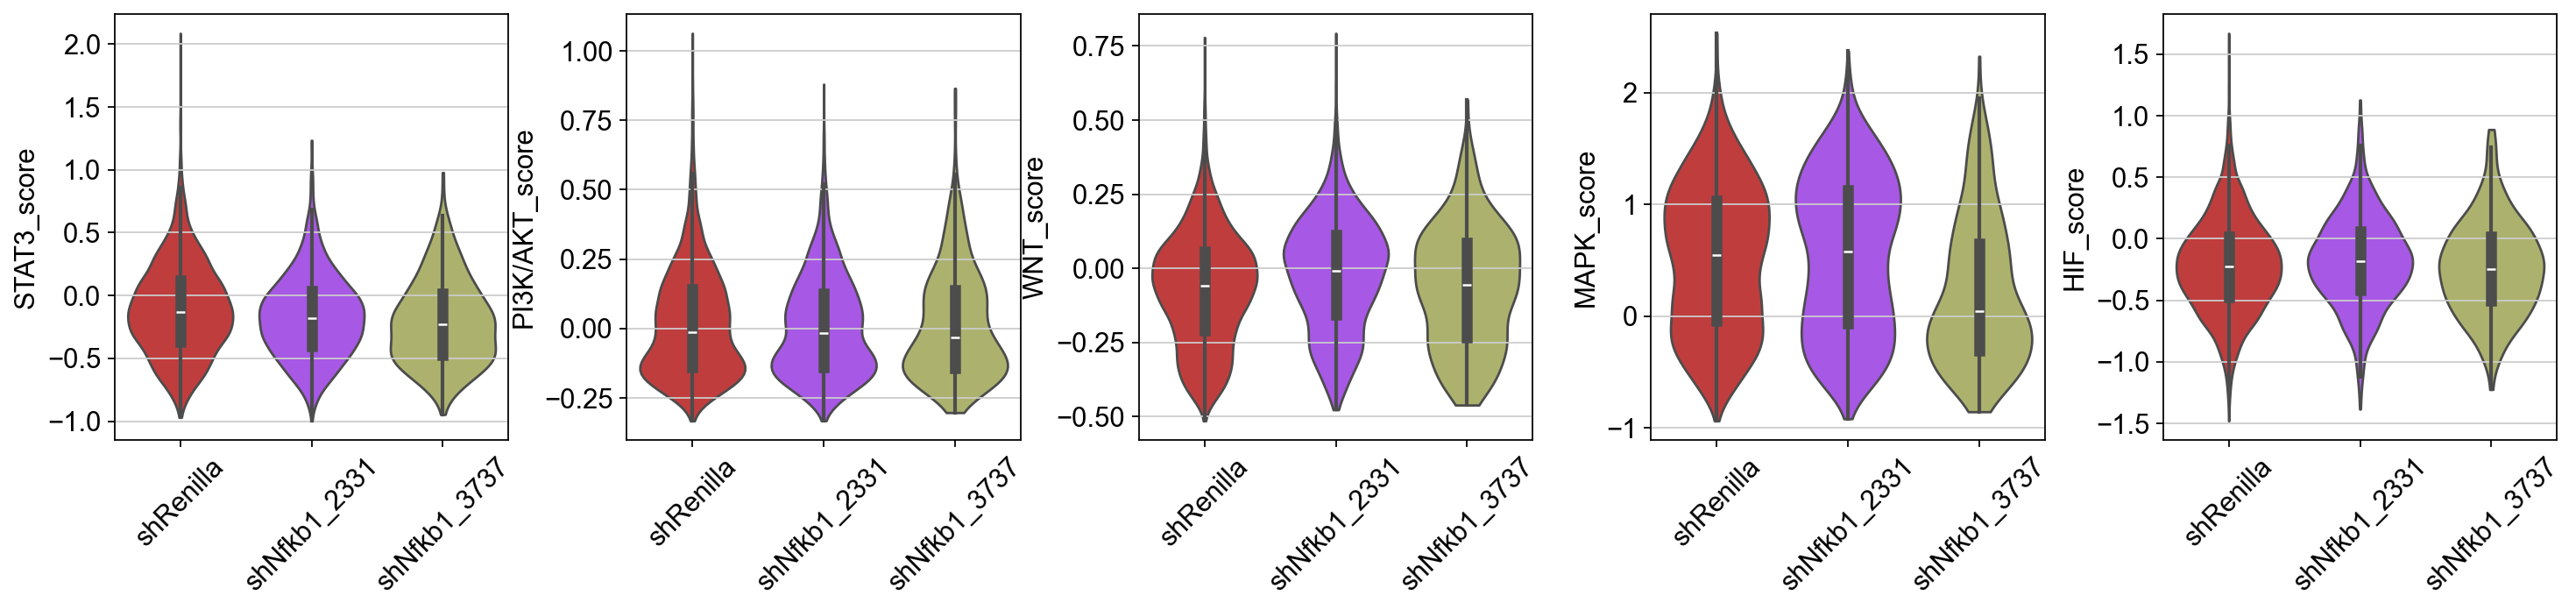

                shRenilla  shNfkb1_2331  shNfkb1_3737  HP2_vs_HP1
WNT_score       -0.072413     -0.021365     -0.062960    2.946895
PI3K/AKT_score   0.016022      0.006499      0.014056    2.162687
HIF_score       -0.219640     -0.181018     -0.234715    1.296642
STAT3_score     -0.110445     -0.166363     -0.207454    1.247001
MAPK_score       0.513349      0.542866      0.212874    0.392131


In [42]:
# Check alternative survival pathways
survival_pathways = {
    'STAT3': ['Stat3', 'Socs3', 'Bcl2l1', 'Mcl1'],
    'PI3K/AKT': ['Akt1', 'Akt2', 'Pdk1', 'Mtor'],
    'WNT': ['Ctnnb1', 'Axin2', 'Lef1', 'Tcf7'],
    'MAPK': ['Mapk1', 'Mapk3', 'Fos', 'Jun'],
    'HIF': ['Hif1a', 'Vegfa', 'Ldha', 'Pgk1']
}

# Score each pathway
for pathway, genes in survival_pathways.items():
    sc.tl.score_genes(adata, gene_list=genes, 
                     score_name=f'{pathway}_score',use_raw=True)

# Compare across groups
pathway_scores = [f'{p}_score' for p in survival_pathways.keys()]
sc.pl.violin(adata, keys=pathway_scores, groupby='Group', rotation=45, stripplot=False, inner='box')

# Look for HP2-specific upregulation
import pandas as pd
pathway_comparison = pd.DataFrame()
for score in pathway_scores:
    for group in ['shRenilla', 'shNfkb1_2331', 'shNfkb1_3737']:
        cells = adata.obs['Group'] == group
        pathway_comparison.loc[score, group] = adata[cells].obs[score].mean()

pathway_comparison['HP2_vs_HP1'] = (pathway_comparison['shNfkb1_3737'] / 
                                    pathway_comparison['shNfkb1_2331'])
print(pathway_comparison.sort_values('HP2_vs_HP1', ascending=False))

# If any pathway shows >1.5x in HP2 vs HP1 → compensation mechanism

computing score 'stemness_score'
    finished: added
    'stemness_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


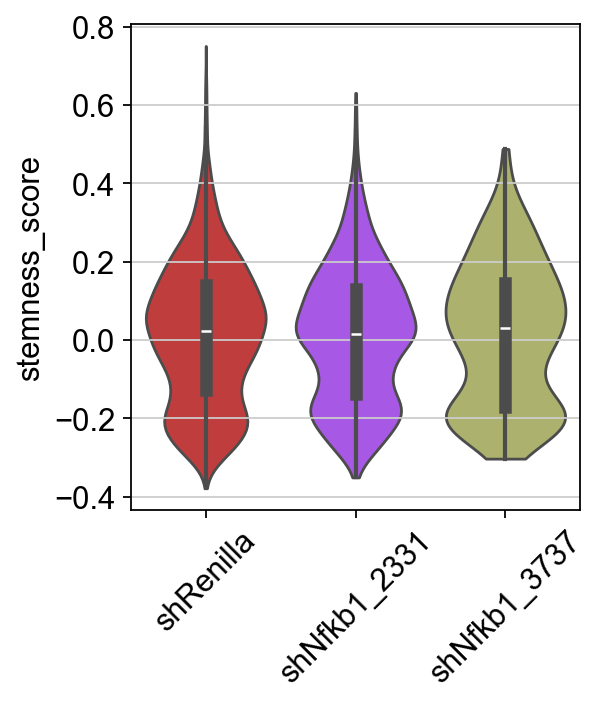

In [43]:
# p50 tumor suppressor functions:
# - Limits cancer stem cell self-renewal
# - Promotes differentiation
# - Limits metabolic reprogramming

# Check stem cell markers
stemness_genes = ['Cd44', 'Aldh1a1', 'Sox2', 'Nanog', 'Pou5f1']
differentiation_genes = ['Krt18', 'Cdh1', 'Epcam']  # Adjust for your tumor type

sc.tl.score_genes(adata, gene_list=stemness_genes, score_name='stemness_score',use_raw=True)

sc.pl.violin(adata, keys='stemness_score', groupby='Group',rotation=45, inner='box', stripplot=False)

# If HP2 has HIGHER stemness → too much p50 loss promotes cancer stem cells
# This would maintain tumor burden despite NFκB suppression


### 4. **Non-Linear Dose Response / "Goldilocks Zone"**



In [44]:
# Are different cell states enriched in HP2?
from scipy.stats import chi2_contingency

contingency = pd.crosstab(adata.obs['leiden'], adata.obs['Group'])
chi2, pval, dof, expected = chi2_contingency(contingency)

print(f"Cell composition differs across groups: p={pval:.2e}")

# Which clusters are enriched in HP2?
props = pd.crosstab(adata.obs['leiden'], adata.obs['Group'], normalize='columns')
props['HP2_enrichment'] = props['shNfkb1_2331'] / props['shNfkb1_3737']
print(props.sort_values('HP2_enrichment', ascending=False))

# If certain clusters are enriched in HP2 → selection

Cell composition differs across groups: p=4.76e-59
Group   shRenilla  shNfkb1_2331  shNfkb1_3737  HP2_enrichment
leiden                                                       
6        0.011640      0.001692      0.000000             inf
3        0.238922      0.289340      0.254642        1.136263
0        0.287319      0.423012      0.400531        1.056129
5        0.025934      0.002538      0.002653        0.956853
7        0.015928      0.002538      0.002653        0.956853
2        0.332653      0.228003      0.246684        0.924272
1        0.079436      0.052030      0.074271        0.700553
4        0.008168      0.000846      0.018568        0.045564


In [45]:
# Known NFκB-independent survival genes
resistance_genes = ['Yap1', 'Taz', 'Myc', 'Sox2', 'Stat3', 'Akt1','Sox11']

resistance_expr = pd.DataFrame()
for gene in resistance_genes:
    if gene in adata.var_names:
        for group in ['shRenilla', 'shNfkb1_2331', 'shNfkb1_3737']:
            cells = adata.obs['Group'] == group
            resistance_expr.loc[gene, group] = adata.raw[cells, gene].X.mean()

resistance_expr['HP2_vs_HP1'] = (resistance_expr['shNfkb1_3737'] / 
                                 resistance_expr['shNfkb1_2331'])
print(resistance_expr.sort_values('HP2_vs_HP1', ascending=False))

# Genes >2x in HP2 → compensation mechanisms

       shRenilla  shNfkb1_2331  shNfkb1_3737  HP2_vs_HP1
Sox2    0.003665      0.004572      0.021377    4.675869
Yap1    0.222723      0.203805      0.213727    1.048684
Akt1    0.452340      0.430203      0.434499    1.009987
Myc     0.174258      0.170436      0.165794    0.972768
Taz     0.144258      0.128759      0.122217    0.949192
Stat3   0.586589      0.514938      0.461324    0.895883
Sox11   0.000754      0.006343      0.001322    0.208432


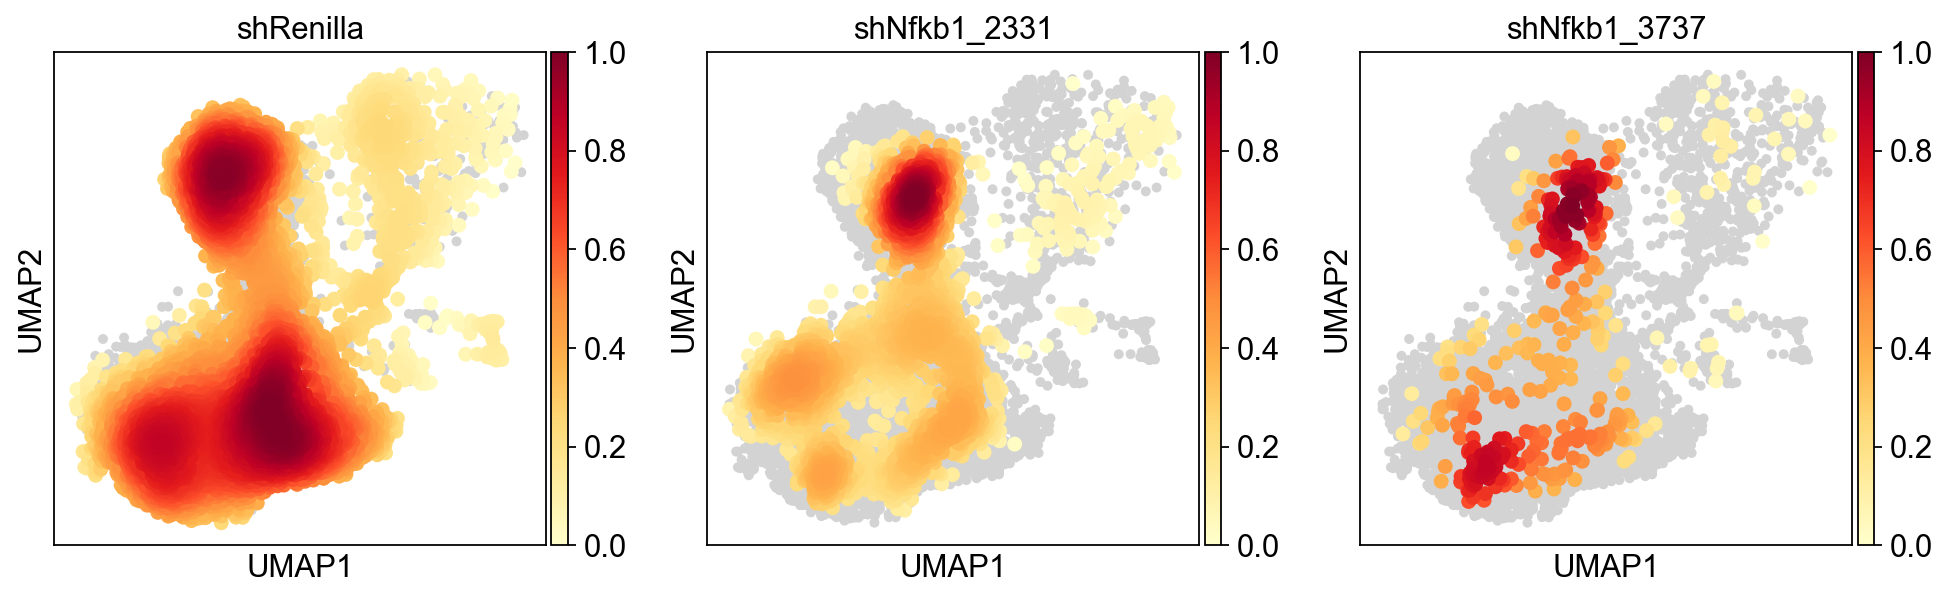

In [46]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_Group')

## Define scoring functions

In [47]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'cell2020_no_Slc4a11':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']   
                    if 'Slc4a11' in clusters[row[0]]:
                        clusters[row[0]].remove('Slc4a11')
                        print("Slc4a11 removed")
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'nfkb':         
            with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                clusters['nfkb'] = [x for row in csvreader for x in row]
            clusterkeys.append('nfkb')
            HPCS = 'nfkb'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [48]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes,use_raw=True)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [49]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1493 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1494 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1192 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1497 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1293 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    1795 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    991 total control genes are us

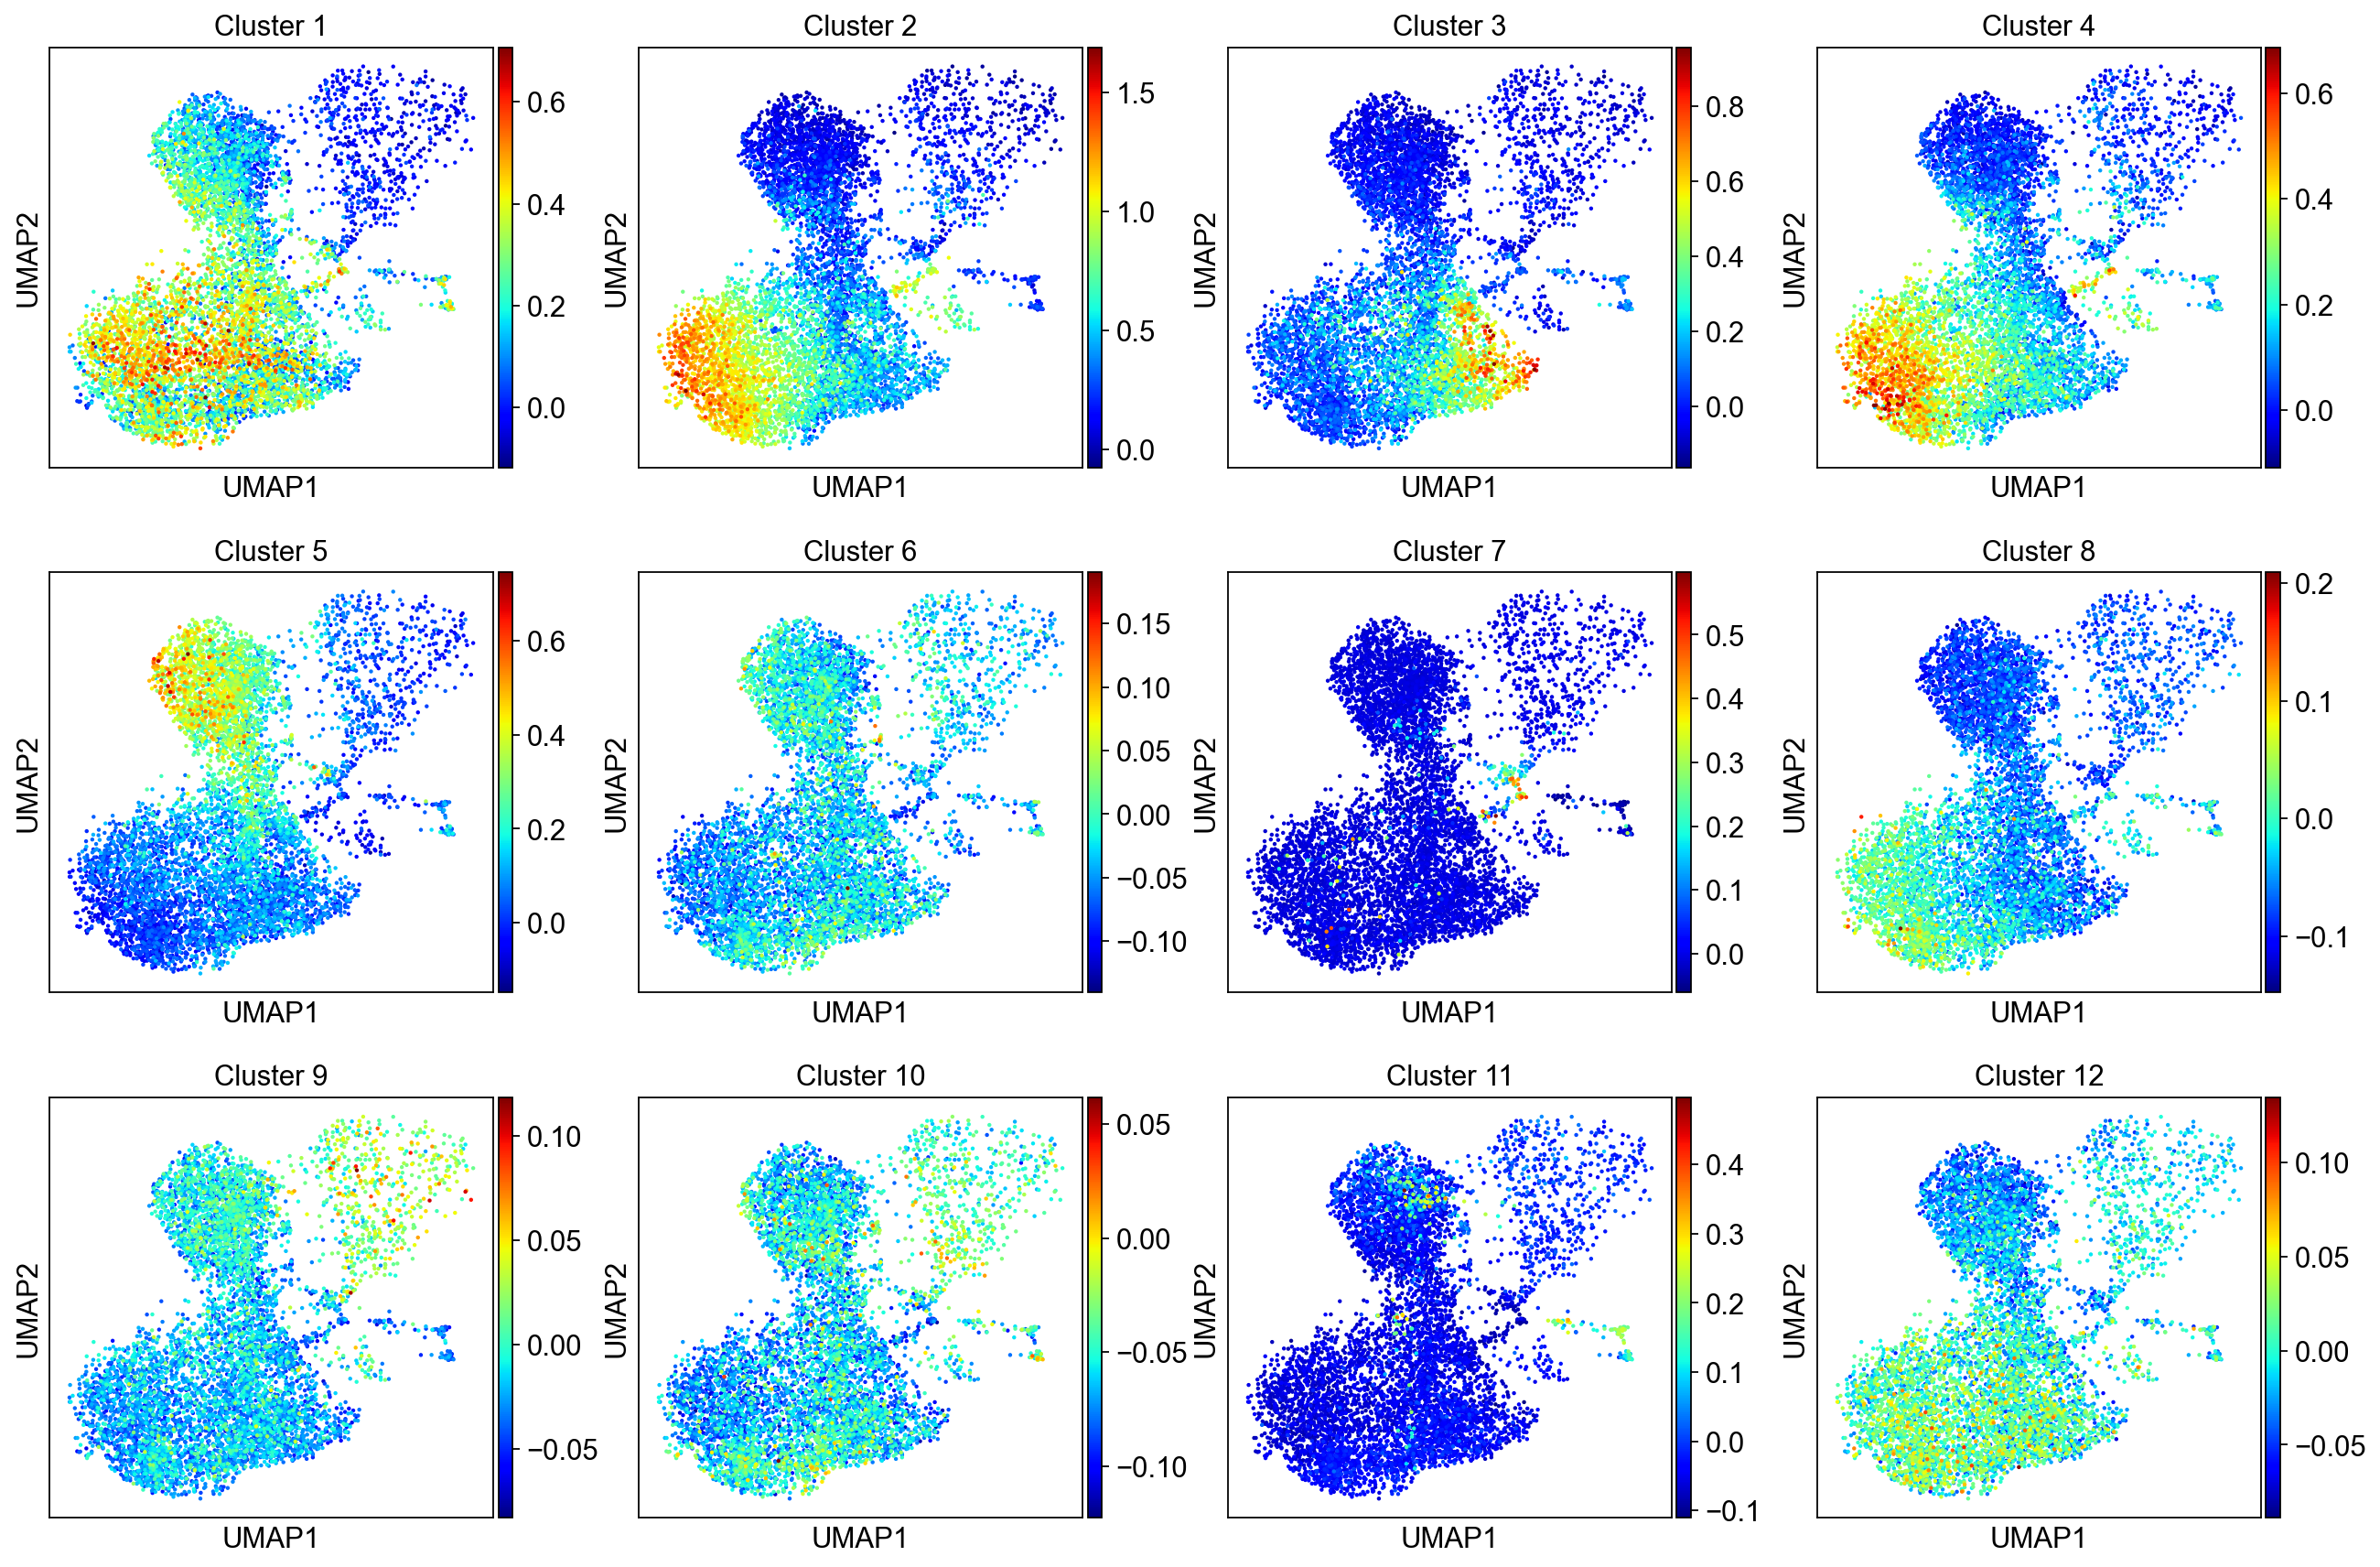

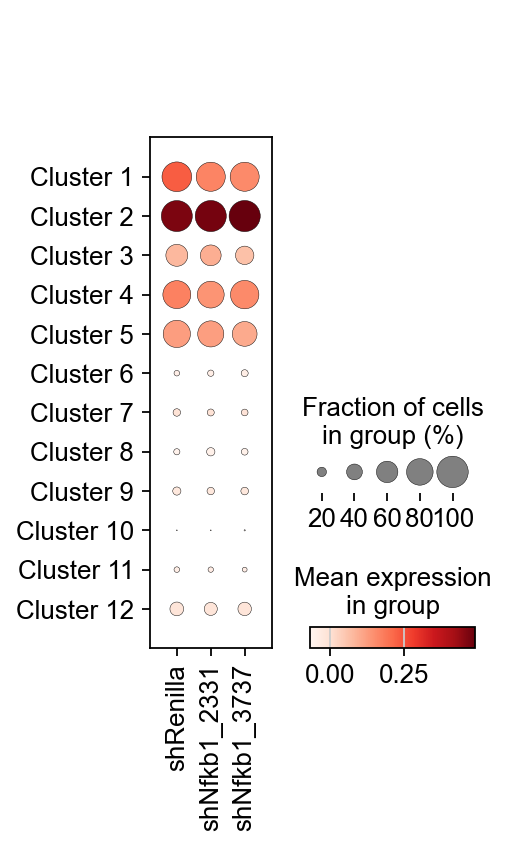

In [50]:
scoreAndPlot(adata, groupby='Group',numgenes=100)

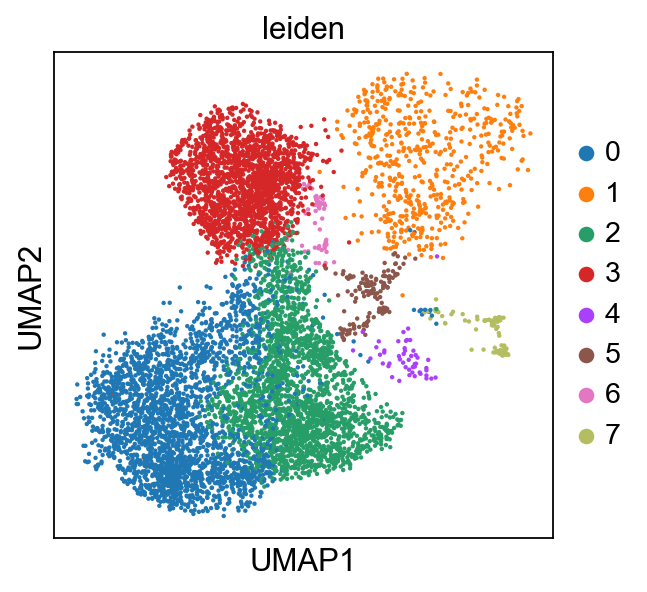

In [51]:
sc.pl.umap(adata,color=['leiden'])

In [52]:
df

gene  logfoldchanges      pvals_adj
0      2117-Nfkb1.2331        7.036598  2.047667e-126
1           Rps15a-ps8        7.175669  1.565753e-105
2              Gm10260        3.437187   2.276730e-86
3                 Xist        2.449224   1.310965e-53
4                  Fos        1.258965   9.168328e-22
...                ...             ...            ...
30139            Psmb8       -0.819287   3.027166e-23
30140  2118-Nfkb1.3737       -8.599238   5.537274e-23
30141            H2-Q6       -1.039715   4.843326e-24
30142             Bst2       -0.991041   4.567018e-26
30143            H2-Q7       -0.990618   1.319082e-44

[30144 rows x 3 columns]

In [53]:
df = adata.obs.copy()

pb_cluster5 = (
    df.groupby(["Classification", "Group"])["Cluster 5"]
      .mean()
      .reset_index()
)

pb_nfkb = (
    df.groupby(["Classification", "Group"])["hallmark_nfkb"]
      .mean()
      .reset_index()
)

df2 = adata[~adata.obs.Classification.isin(['AX1508_2117','AX1598_2117','AW1555_2118']),:].obs.copy()
pb_cluster5a = (
    df2.groupby(["Classification", "Group"])["Cluster 5"]
      .mean()
      .reset_index()
)
pb_nfkba = (
    df2.groupby(["Classification", "Group"])["hallmark_nfkb"]
      .mean()
      .reset_index()
)

/tmp/ipykernel_3968806/2185748060.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Cluster 5"]
/tmp/ipykernel_3968806/2185748060.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["hallmark_nfkb"]
/tmp/ipykernel_3968806/2185748060.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby(["Classification", "Group"])["Cluster 5"]


Text(0, 0.5, 'Mean hallmark_nfkb expression per mouse')

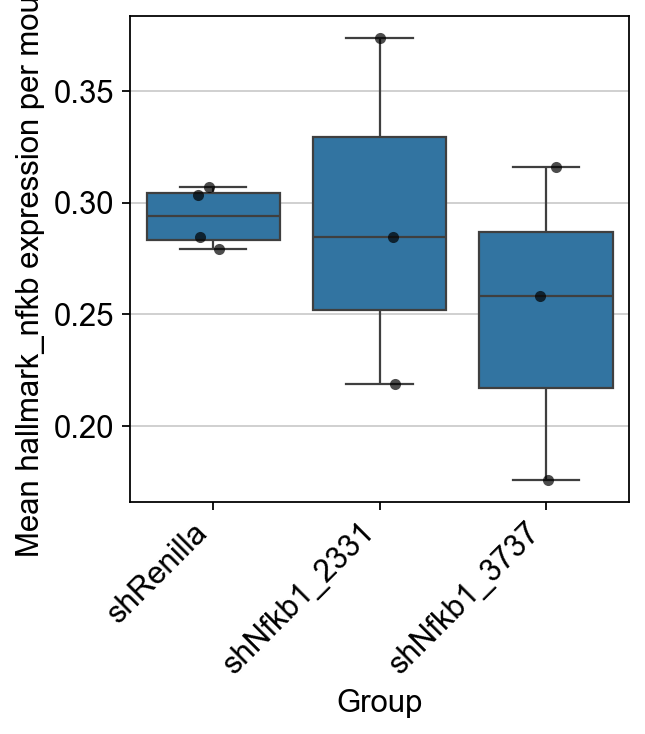

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    showfliers=False,
)
sns.stripplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean hallmark_nfkb expression per mouse")


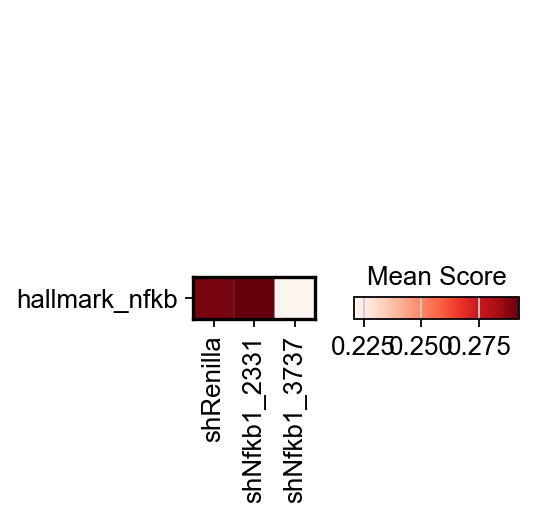

In [55]:
# Plot the hallmark_nfkb score across groups
sc.pl.matrixplot(adata, 
                 var_names=['hallmark_nfkb'], 
                 groupby='Group', 
                 cmap='Reds', 
                 colorbar_title='Mean Score', swap_axes=True)

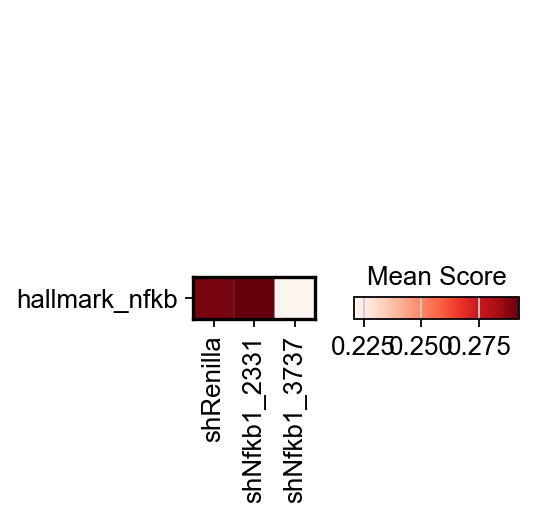

In [56]:
# Plot the hallmark_nfkb score across groups
sc.pl.matrixplot(adata, 
                 var_names=['hallmark_nfkb'], 
                 groupby='Group', 
                 cmap='Reds', 
                 colorbar_title='Mean Score', swap_axes=True)

Text(0, 0.5, 'Mean hallmark_nfkb expression per mouse')

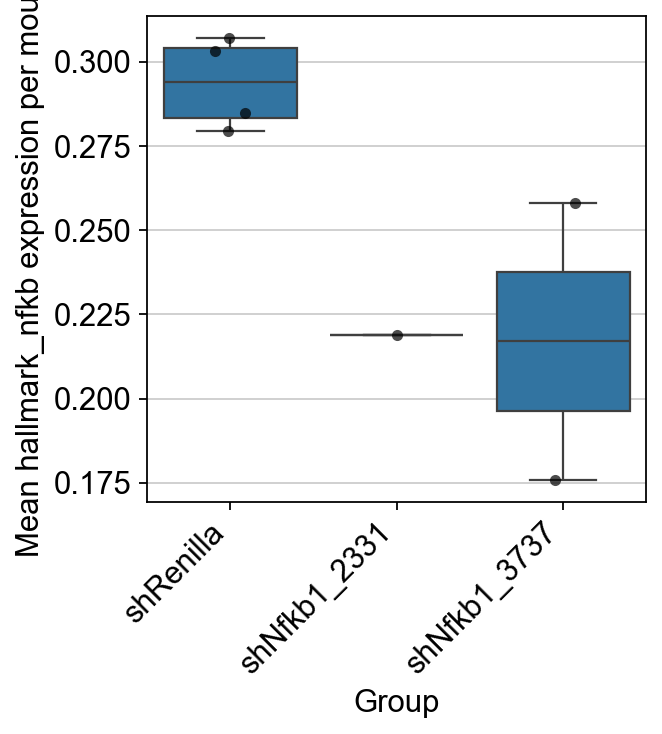

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_nfkba,
    x="Group",
    y="hallmark_nfkb",
    showfliers=False,
)
sns.stripplot(
    data=pb_nfkba,
    x="Group",
    y="hallmark_nfkb",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean hallmark_nfkb expression per mouse")


Text(0, 0.5, 'Mean Cluster 5 expression per mouse')

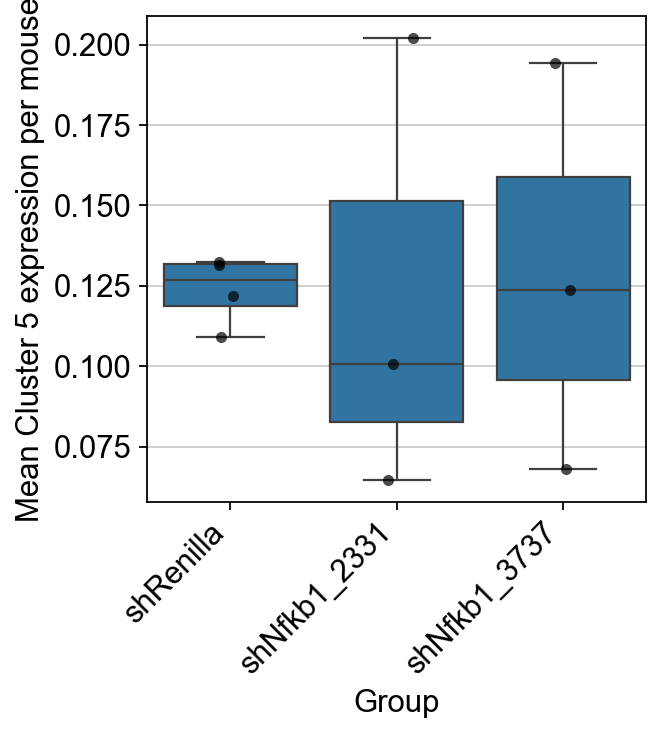

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    showfliers=False,
)
sns.stripplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Cluster 5 expression per mouse")


Text(0, 0.5, 'Mean Cluster 5 expression per mouse')

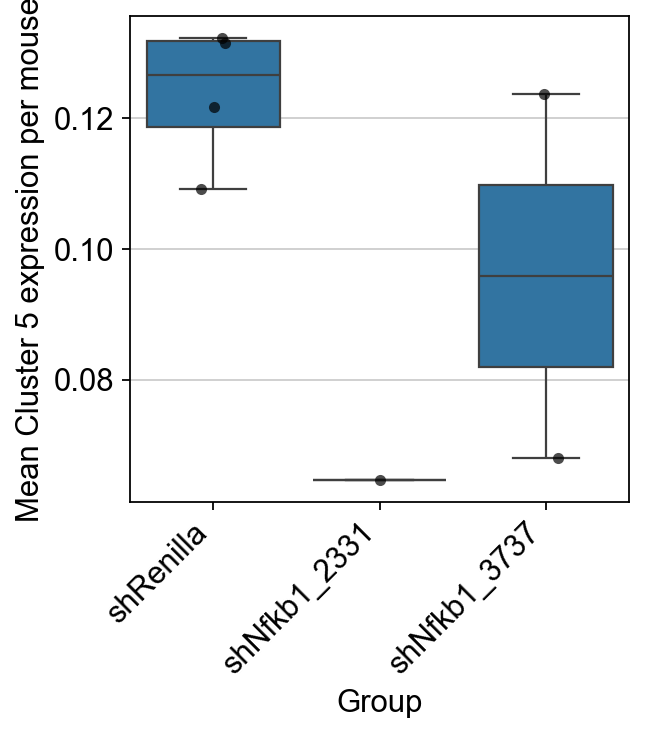

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_cluster5a,
    x="Group",
    y="Cluster 5",
    showfliers=False,
)
sns.stripplot(
    data=pb_cluster5a,
    x="Group",
    y="Cluster 5",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Cluster 5 expression per mouse")


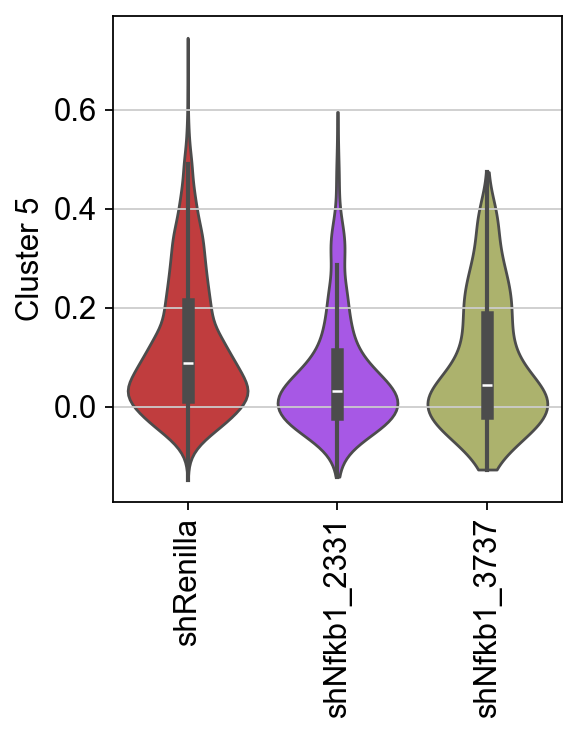

In [60]:
sc.pl.violin(adata[df2.index,:], 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

## Look at differentially expressed genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


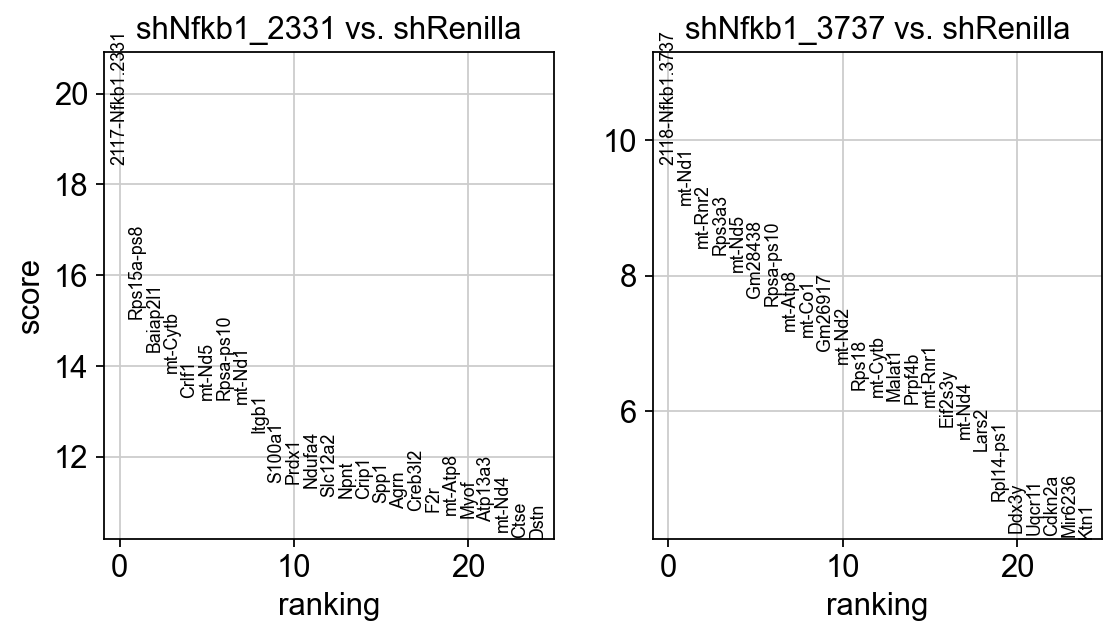

    using 'X_pca' with n_pcs = 150
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: shNfkb1_2331, shNfkb1_3737


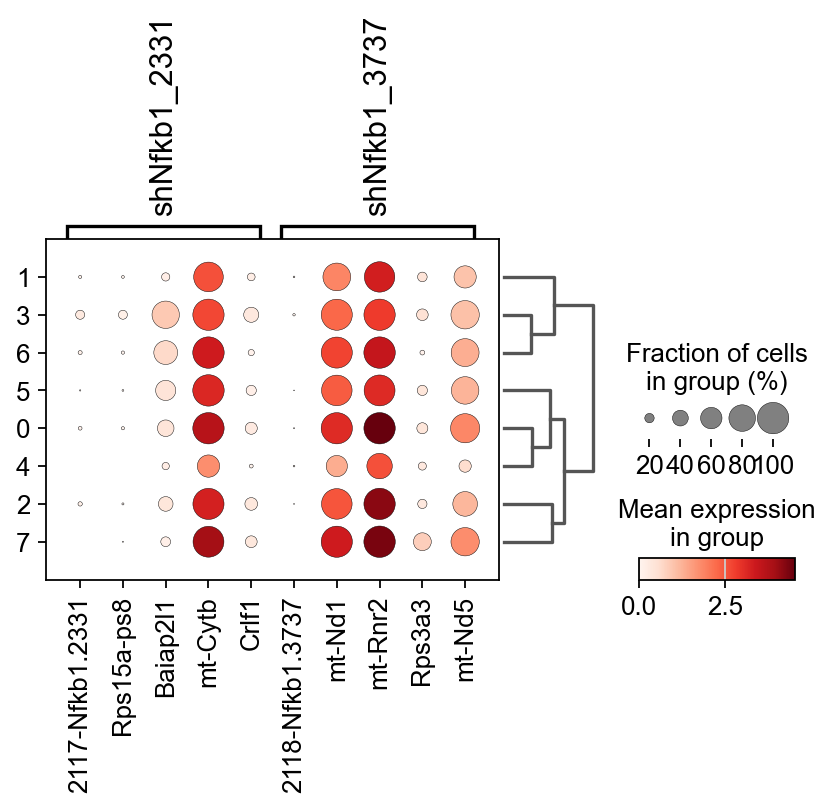

In [61]:
sc.tl.rank_genes_groups(adata, 'Group', method='wilcoxon',reference='shRenilla',use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="leiden")


## Look at the whole tumor

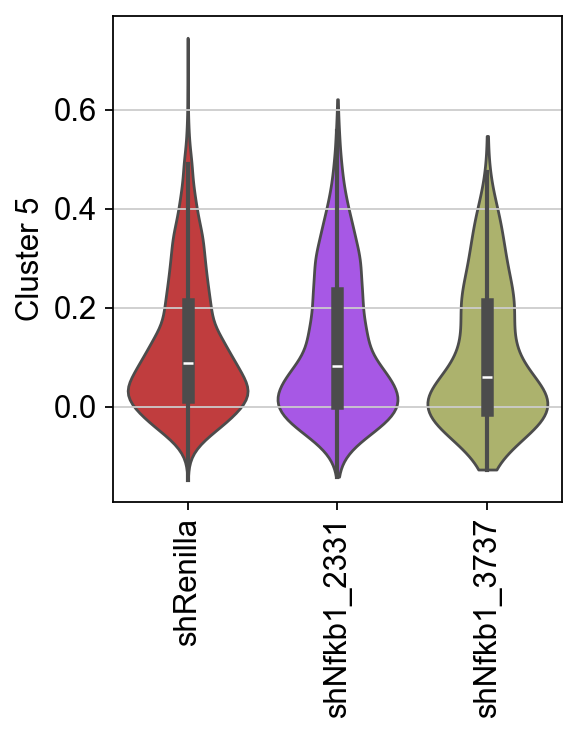

In [62]:
# Export figure
sc.pl.violin(adata, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [63]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shNfkb1_2331']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(5897740.0), pvalue=np.float64(0.19085024883447488))

In [64]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shNfkb1_3737']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(1025416.0), pvalue=np.float64(0.00032799826491272335))

## Now look within the HPCS cluster

In [65]:
adata2 = adata[adata.obs.leiden.isin(['3']),:].copy()

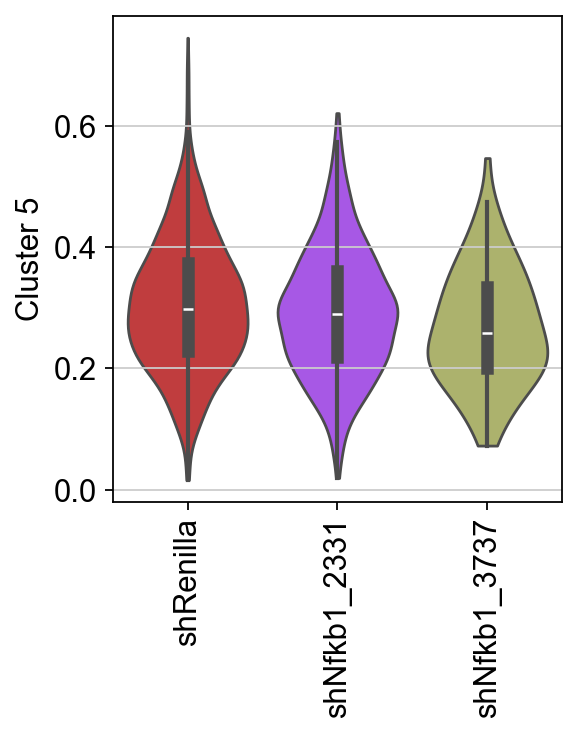

In [66]:
sc.pl.violin(adata2, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [67]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_2331']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(424804.0), pvalue=np.float64(0.026592859603590983))

In [68]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_3737']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(67720.0), pvalue=np.float64(0.0007887801182817223))

## Evaluate differences in HPCS via EnrichR

In [69]:
result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names
results_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','scores']}) #.to_excel('test.xlsx')
#results_df.to_excel('write/leiden.xlsx')

In [70]:
import gseapy
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Mouse')
print(gene_set_names)
#gsets = 'Descartes_Cell_Types_and_Tissue_2021'
#gsets = 'Tabula_Muris'
gsets = 'MSigDB_Hallmark_2020'
#gsets = 'The_Kinase_Library_2023'
#gsets = 'TF_Perturbations_Followed_by_Expression'

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CM4AI_U2OS_Protein_Localization_Assemblies', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'Carcinogenome', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'ClinVar_2025', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency

In [71]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1_2331'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1_2331'],
    'pvals_adj': result['pvals_adj']['shNfkb1_2331']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr0 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr0.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr0.results.to_excel('write/GSEA_shNfkb1_2331_up.xlsx')

                                 Term  Adjusted P-value  Combined Score
0                   KRAS Signaling Up      3.533760e-07      171.184546
1              Estrogen Response Late      4.799892e-04       62.322524
2   Epithelial Mesenchymal Transition      4.799892e-04       62.322524
3                        Angiogenesis      1.474773e-03      134.719995
4       TNF-alpha Signaling via NF-kB      1.474773e-03       45.031713
5                         p53 Pathway      1.474773e-03       45.031713
6                   Androgen Response      7.386958e-03       44.304154
7                         Coagulation      2.524561e-02       24.958451
8             Estrogen Response Early      2.524561e-02       20.268615
9                     Apical Junction      9.215039e-02       12.174591
10           IL-6/JAK/STAT3 Signaling      1.207310e-01       15.205519
11                          Apoptosis      1.377949e-01       10.175845
12               IL-2/STAT5 Signaling      1.743112e-01        6

In [72]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1_2331'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1_2331'],
    'pvals_adj': result['pvals_adj']['shNfkb1_2331']
})
# Define the genes that are LOWER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr1 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr1.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr1.results.to_excel('write/GSEA_shNfkb1_2331_down.xlsx')

                             Term  Adjusted P-value  Combined Score
0       Interferon Gamma Response      1.405691e-56     1700.765793
1       Interferon Alpha Response      2.639639e-39     1753.416555
2   TNF-alpha Signaling via NF-kB      3.625719e-17      197.487338
3                  Myc Targets V1      5.664102e-14      140.861589
4                mTORC1 Signaling      6.696168e-13      121.828219
5       Oxidative Phosphorylation      6.696168e-13      121.828219
6            IL-2/STAT5 Signaling      1.085751e-10       90.523646
7                       Apoptosis      1.881636e-10       96.589350
8                      Complement      1.294991e-09       75.502851
9                     p53 Pathway      1.323892e-08       63.271936
10                        Hypoxia      3.879704e-08       57.698186
11          Inflammatory Response      1.112233e-07       52.468642
12       IL-6/JAK/STAT3 Signaling      1.150871e-07       79.017819
13                   Adipogenesis      2.891167e

In [73]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1_3737'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1_3737'],
    'pvals_adj': result['pvals_adj']['shNfkb1_3737']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr2 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr2.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr2.results.to_excel('write/GSEA_shNfkb1_3737_up.xlsx')

                  Term  Adjusted P-value  Combined Score
0          p53 Pathway          0.206487        7.126581
1      G2-M Checkpoint          0.206487        7.126581
2          E2F Targets          0.206487        7.126581
3  Allograft Rejection          0.206487        7.126581


In [74]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1_3737'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1_3737'],
    'pvals_adj': result['pvals_adj']['shNfkb1_3737']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr3 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr3.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr3.results.to_excel('write/GSEA_shNfkb1_3737_down.xlsx')

                                 Term  Adjusted P-value  Combined Score
0           Interferon Gamma Response      4.795069e-29     1081.201501
1       TNF-alpha Signaling via NF-kB      3.730003e-28     1002.686180
2           Interferon Alpha Response      3.308881e-16      628.559296
3                         p53 Pathway      9.131077e-11      186.795738
4                             Hypoxia      1.486683e-07      103.575601
5                      UV Response Up      1.486683e-07      116.370807
6                           Apoptosis      1.666782e-07      112.220677
7           Unfolded Protein Response      4.814870e-07      121.573200
8                    mTORC1 Signaling      4.814870e-07       87.469615
9                IL-2/STAT5 Signaling      2.204931e-06       73.813074
10           IL-6/JAK/STAT3 Signaling      8.976282e-05       70.830030
11                         Complement      1.928381e-04       39.209697
12  Epithelial Mesenchymal Transition      1.928381e-04       39

<Axes: title={'center': 'MSigDB_Hallmark_2020 shNfkb1_3737 Down'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

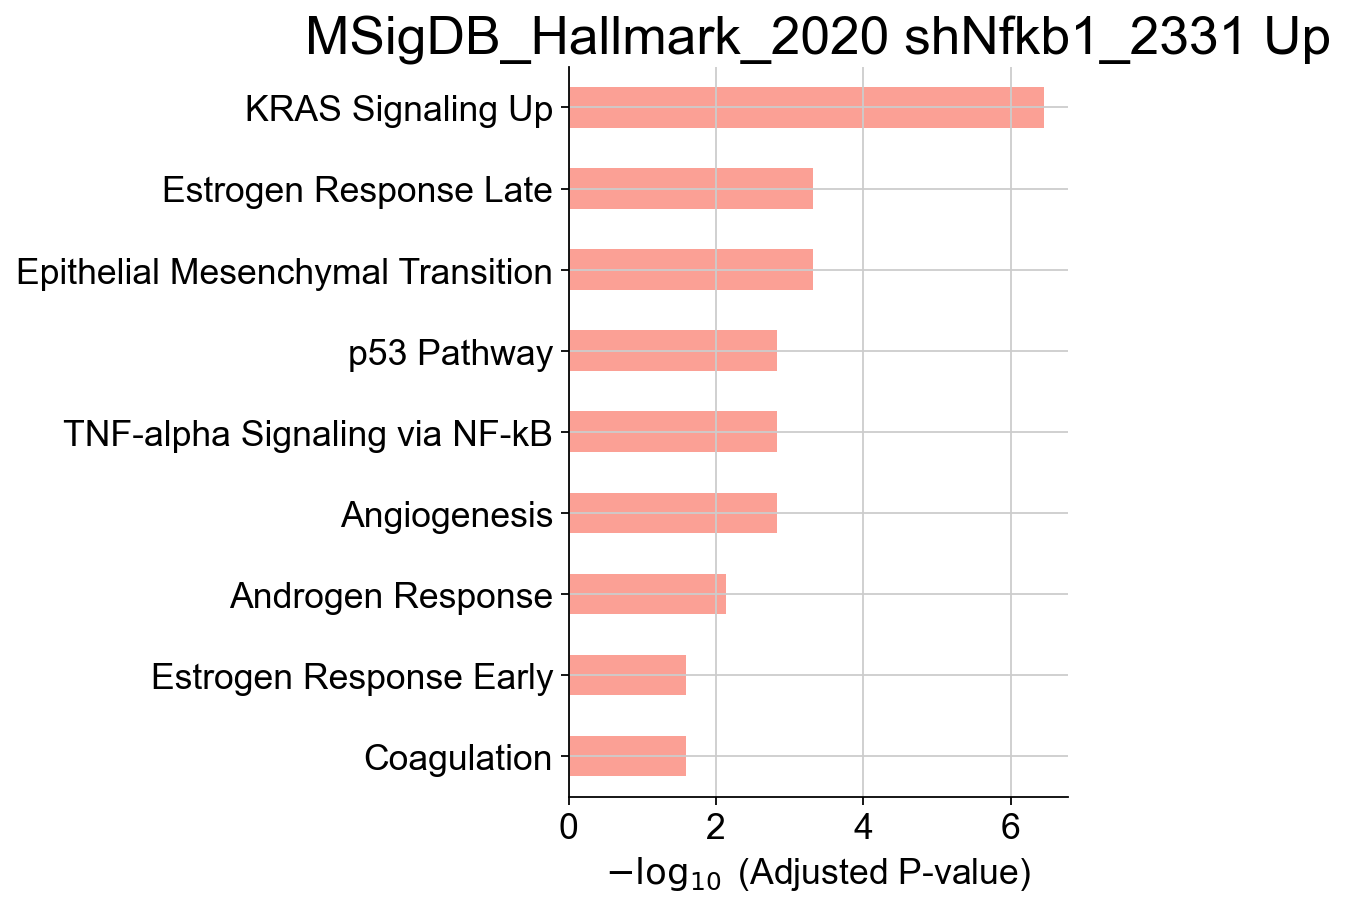

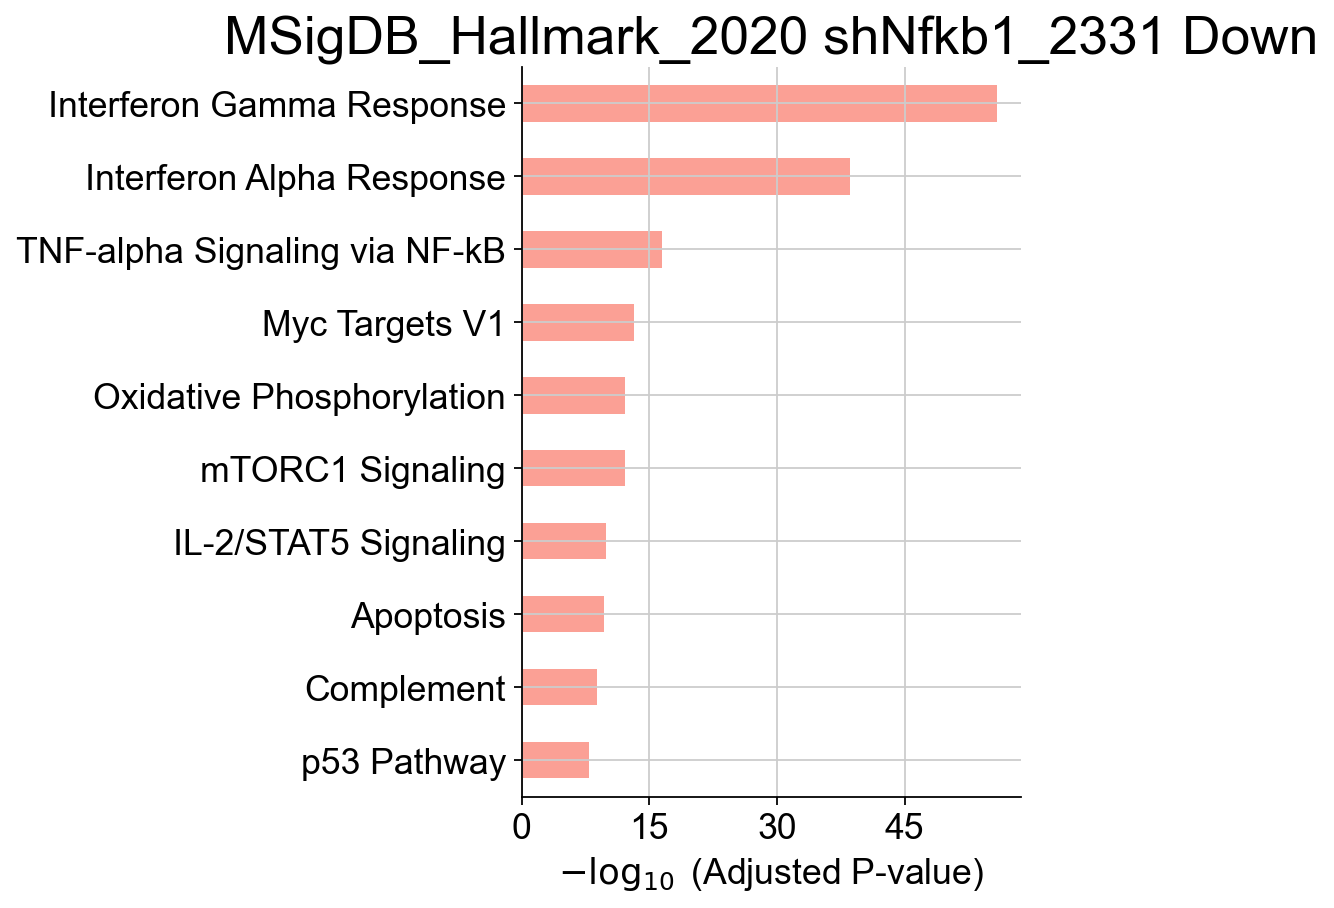

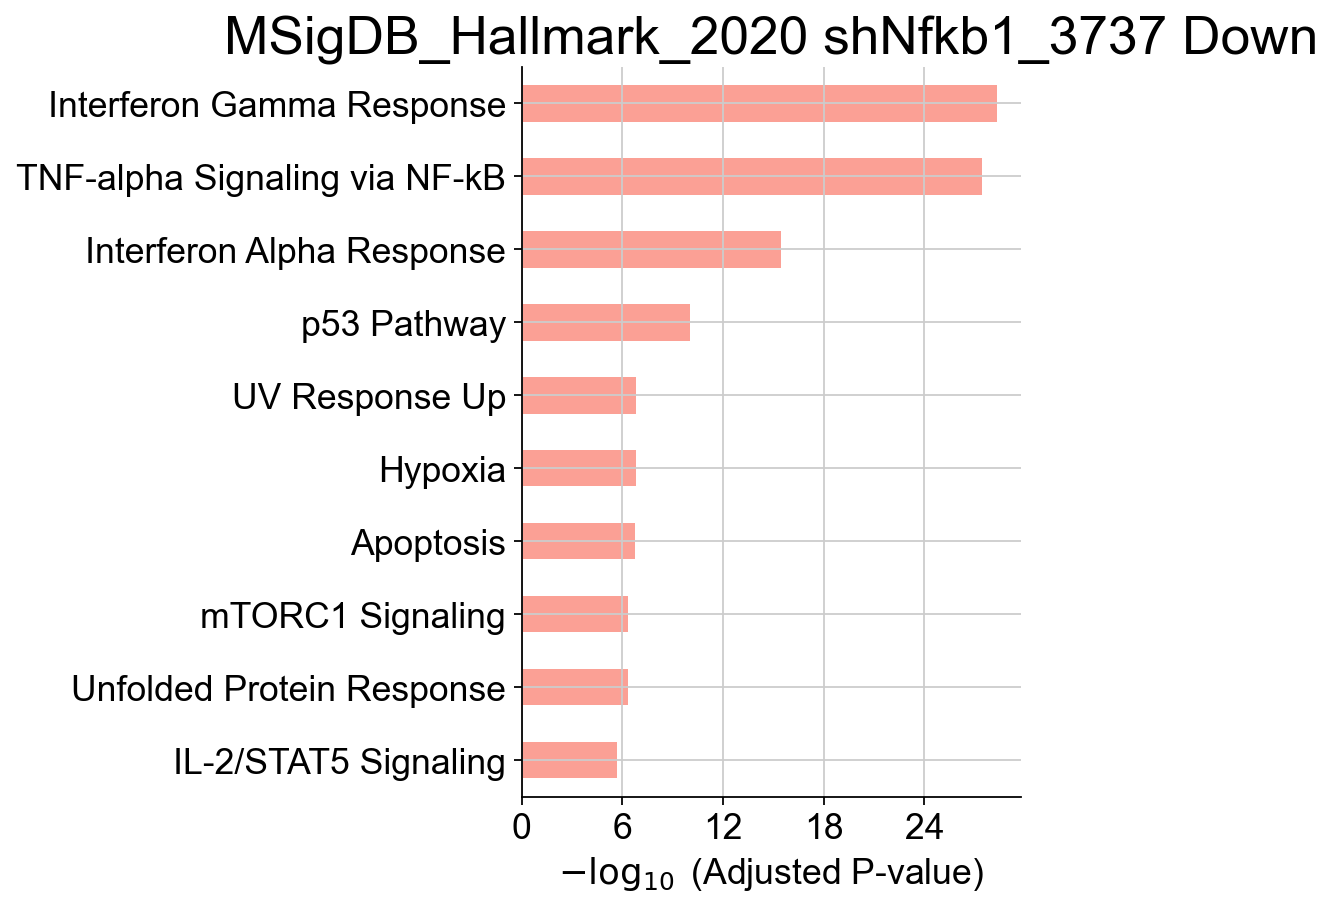

In [75]:
gseapy.barplot(enr0.res2d,title="%s shNfkb1_2331 Up" % gsets)
gseapy.barplot(enr1.res2d,title="%s shNfkb1_2331 Down" % gsets)
#gseapy.barplot(enr2.res2d,title="%s shNfkb1_3737 Up" % gsets) #nothing reaches significance
gseapy.barplot(enr3.res2d,title="%s shNfkb1_3737 Down" % gsets)

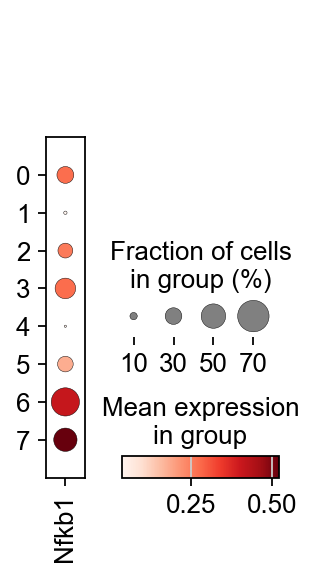

In [76]:
sc.pl.dotplot(adata, ['Nfkb1'], groupby='leiden',use_raw=True)

In [77]:
# Test if proportion of each cell state differs between conditions
# at the MOUSE level (proper statistics)

def test_state_proportions(adata, state_key='leiden', 
                           sample_key='Classification', 
                           condition_key='Group'):
    
    # Calculate proportion of each state per mouse
    proportions = []
    
    for mouse in adata.obs[sample_key].unique():
        adata_mouse = adata[adata.obs[sample_key] == mouse]
        condition = adata_mouse.obs[condition_key].iloc[0]
        
        state_counts = adata_mouse.obs[state_key].value_counts()
        state_props = state_counts / adata_mouse.n_obs
        
        for state, prop in state_props.items():
            proportions.append({
                'mouse_id': mouse,
                'condition': condition,
                'cell_state': state,
                'proportion': prop
            })
    
    props_df = pd.DataFrame(proportions)
    
    # Test each state (Wilcoxon or t-test with n=3 per group)
    from scipy.stats import mannwhitneyu
    
    for state in props_df['cell_state'].unique():
        state_data = props_df[props_df['cell_state'] == state]
        grp1 = state_data[state_data['condition'] == 'shRenilla']['proportion']
        grp2 = state_data[state_data['condition'] == 'shNfkb1_2331']['proportion']
        
        stat, pval = mannwhitneyu(grp1, grp2)
        print(f"{state}: p={pval:.4f}")

In [78]:
test_state_proportions(adata)

3: p=0.8571
2: p=0.6286
0: p=0.2286
1: p=0.2286
6: p=0.2000
5: p=0.0571
4: p=0.1333
7: p=1.0000


## Evaluate differences in Groups via GSEA

In [79]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import ranksums, ttest_ind
from scipy.stats import false_discovery_control


# ========================================
# CREATE NORMALIZED PSEUDOBULK
# ========================================

def create_normalized_pseudobulk(adata, 
                                 sample_key='Classification',
                                 condition_key='Group',
                                 layer=None):
    """
    Create per-cell normalized pseudobulk matrix
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    sample_key : str
        Column in adata.obs with mouse/sample IDs
    condition_key : str
        Column in adata.obs with condition labels
    layer : str or None
        Which layer to use. None = use .X, 'raw' = use .raw.X
    
    Returns:
    --------
    pseudobulk_df : DataFrame
        Genes x Samples with per-cell averaged expression
    metadata_df : DataFrame
        Sample metadata
    """
    
    pseudobulk_list = []
    metadata_list = []
    
    for sample in adata.obs[sample_key].unique():
        # Subset to this mouse
        adata_sample = adata[adata.obs[sample_key] == sample].copy()
        
        # Get condition
        condition = adata_sample.obs[condition_key].iloc[0]
        n_cells = adata_sample.n_obs
        
        # Get counts - use raw counts for DE
        if layer is None:
            if adata_sample.raw is not None:
                counts = adata_sample.raw.X
            else:
                counts = adata_sample.X
        else:
            counts = adata_sample.layers[layer]
        
        # Sum across cells
        if hasattr(counts, 'toarray'):  # sparse matrix
            summed = np.array(counts.sum(axis=0)).flatten()
        else:
            summed = counts.sum(axis=0).flatten()
        
        # Normalize by cell number - this is key for enriched samples!
        per_cell_avg = summed / n_cells
        
        pseudobulk_list.append(per_cell_avg)
        metadata_list.append({
            'sample_id': sample,
            'condition': condition,
            'n_cells': n_cells
        })
    
    # Create DataFrame
    if adata.raw is not None:
        gene_names = adata.raw.var_names
    else:
        gene_names = adata.var_names
    
    pseudobulk_df = pd.DataFrame(
        np.array(pseudobulk_list).T,
        index=gene_names,
        columns=[m['sample_id'] for m in metadata_list]
    )
    
    metadata_df = pd.DataFrame(metadata_list)
    
    return pseudobulk_df, metadata_df

# Create pseudobulk
print("Creating normalized pseudobulk...")
pseudobulk, metadata = create_normalized_pseudobulk(
    adata2,
    sample_key='Classification',
    condition_key='Group'
)

print(f"Pseudobulk shape: {pseudobulk.shape}")
print(f"Samples: {metadata['sample_id'].tolist()}")
print(f"Conditions: {metadata['condition'].tolist()}")

# ========================================
# DIFFERENTIAL EXPRESSION TESTING
# ========================================

def run_de_analysis(pseudobulk_df, metadata_df, 
                    condition1='shRenilla', 
                    condition2='shNfkb1_2331',
                    min_expression=1.0,
                    test='wilcoxon'):
    """
    Run differential expression between two conditions
    
    Parameters:
    -----------
    pseudobulk_df : DataFrame
        Genes x Samples pseudobulk matrix
    metadata_df : DataFrame
        Sample metadata with 'condition' column
    condition1 : str
        Reference condition (denominator for fold change)
    condition2 : str
        Test condition (numerator for fold change)
    min_expression : float
        Minimum mean expression to include gene
    test : str
        'wilcoxon' or 'ttest'
    
    Returns:
    --------
    results_df : DataFrame
        DE results with logFC, p-values, etc.
    """
    
    # Get sample indices for each condition
    samples1 = metadata_df[metadata_df['condition'] == condition1]['sample_id'].values
    samples2 = metadata_df[metadata_df['condition'] == condition2]['sample_id'].values
    
    print(f"\nComparing {condition2} (n={len(samples2)}) vs {condition1} (n={len(samples1)})")
    print(f"  {condition1} samples: {samples1}")
    print(f"  {condition2} samples: {samples2}")
    
    # Filter genes by expression
    mean_expr = pseudobulk_df.mean(axis=1)
    genes_to_test = mean_expr[mean_expr >= min_expression].index
    print(f"  Testing {len(genes_to_test)} genes (mean expression >= {min_expression})")
    
    results = []
    
    for gene in genes_to_test:
        group1 = pseudobulk_df.loc[gene, samples1].values
        group2 = pseudobulk_df.loc[gene, samples2].values
        
        # Calculate means and fold change
        mean1 = np.mean(group1)
        mean2 = np.mean(group2)
        
        # Log2 fold change (add pseudocount to avoid log(0))
        log2fc = np.log2((mean2 + 1) / (mean1 + 1))
        
        # Statistical test
        if test == 'wilcoxon':
            try:
                stat, pval = ranksums(group1, group2)
            except:
                pval = 1.0
        elif test == 'ttest':
            stat, pval = ttest_ind(group1, group2)
        else:
            raise ValueError("test must be 'wilcoxon' or 'ttest'")
        
        results.append({
            'gene': gene,
            'mean_control': mean1,
            'mean_treatment': mean2,
            'log2FC': log2fc,
            'pval': pval
        })
    
    results_df = pd.DataFrame(results)
    
    # FDR correction
    results_df['padj'] = false_discovery_control(results_df['pval'].values)
    
    # Sort by p-value
    results_df = results_df.sort_values('pval')
    
    print(f"  Significant genes (padj < 0.05): {(results_df['padj'] < 0.05).sum()}")
    print(f"  Upregulated (log2FC > 0.5, padj < 0.05): {((results_df['log2FC'] > 0.5) & (results_df['padj'] < 0.05)).sum()}")
    print(f"  Downregulated (log2FC < -0.5, padj < 0.05): {((results_df['log2FC'] < -0.5) & (results_df['padj'] < 0.05)).sum()}")
    
    return results_df

# Run DE analysis
de_results_2331 = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='shRenilla',  # Change to your control condition name
    condition2='shNfkb1_2331',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results_2331.to_csv('write/de_results_shNfkb1_2331_vs_shRenilla.csv', index=False)
print("\nSaved DE results to: de_results_shNfkb1_2331_vs_shRenilla.csv")

de_results_3737 = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='shRenilla',  # Change to your control condition name
    condition2='shNfkb1_3737',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results_3737.to_csv('write/de_results_shNfkb1_3737_vs_shRenilla.csv', index=False)
print("\nSaved DE results to: de_results_shNfkb1_3737_vs_shRenilla.csv")


# ========================================
# CREATE RANKING METRIC FOR GSEA
# ========================================

def create_gsea_ranking(de_results_df, 
                       ranking_method='signed_pval'):
    """
    Create ranking metric for GSEA Prerank
    
    Parameters:
    -----------
    de_results_df : DataFrame
        DE results with gene, log2FC, pval columns
    ranking_method : str
        'signed_pval': -log10(pval) * sign(log2FC)
        'weighted_fc': log2FC * -log10(pval)
        'signal2noise': log2FC / SE (requires replicates)
    
    Returns:
    --------
    ranked_df : DataFrame
        Genes ranked for GSEA
    """
    
    df = de_results_df.copy()
    
    # Replace p=0 with minimum non-zero p-value
    min_pval = df[df['pval'] > 0]['pval'].min()
    df.loc[df['pval'] == 0, 'pval'] = min_pval / 10
    
    if ranking_method == 'signed_pval':
        # Classic approach: sign(FC) * -log10(pval)
        df['rank_metric'] = -np.log10(df['pval']) * np.sign(df['log2FC'])
        
    elif ranking_method == 'weighted_fc':
        # Weight fold change by significance
        df['rank_metric'] = df['log2FC'] * -np.log10(df['pval'])
        
    elif ranking_method == 'log2fc_only':
        # Just use fold change (not recommended for small n)
        df['rank_metric'] = df['log2FC']
    
    else:
        raise ValueError(f"Unknown ranking method: {ranking_method}")
    
    # Sort by ranking metric (high to low)
    df = df.sort_values('rank_metric', ascending=False)
    
    # Remove any NaN or infinite values
    df = df[np.isfinite(df['rank_metric'])]
    
    print(f"\nRanking method: {ranking_method}")
    print(f"Top 5 upregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].head())
    print(f"\nTop 5 downregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].tail())
    
    return df[['gene', 'rank_metric']]

# Create ranking
ranked_genes_2331 = create_gsea_ranking(
    de_results_2331, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)

ranked_genes_3737 = create_gsea_ranking(
    de_results_3737, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)

# ========================================
# EXPORT FOR GSEA PRERANK
# ========================================

# Save as .rnk file (tab-separated, no header)
output_file_2331 = 'write/shNfkb1_2331_vs_shRenilla.rnk'
ranked_genes_2331.to_csv(
    output_file_2331,
    sep='\t',
    header=False,
    index=False
)
print(f"\nSaved GSEA ranking file: {output_file_2331}")
print(f"Total genes in ranking: {len(ranked_genes_2331)}")

# Save as .rnk file (tab-separated, no header)
output_file_3737 = 'write/shNfkb1_3737_vs_shRenilla.rnk'
ranked_genes_3737.to_csv(
    output_file_3737,
    sep='\t',
    header=False,
    index=False
)

print(f"\nSaved GSEA ranking file: {output_file_3737}")
print(f"Total genes in ranking: {len(ranked_genes_3737)}")

# ========================================
# 6. OPTIONAL: RUN GSEA IN PYTHON
# ========================================

# If you want to run GSEA directly in Python instead of using the GSEA app:

def run_gsea_prerank_python(ranked_genes_df, 
                           gene_sets='MSigDB_Hallmark_2020',
                           organism='Mouse',
                           output_dir='write/gsea_output'):
    """
    Run GSEA Prerank using gseapy
    
    Requires: pip install gseapy
    """
    try:
        import gseapy as gp
    except ImportError:
        print("gseapy not installed. Install with: pip install gseapy")
        return None
    
    print(f"\nRunning GSEA Prerank...")
    print(f"  Gene sets: {gene_sets}")
    print(f"  Organism: {organism}")
    
    # Run GSEA
    pre_res = gp.prerank(
        rnk=ranked_genes_df,
        gene_sets=gene_sets,
        organism=organism,
        outdir=output_dir,
        min_size=15,
        max_size=500,
        permutation_num=1000,
        seed=42,
        verbose=True
    )
    
    print(f"\nGSEA complete! Results saved to: {output_dir}")
    
    # Show top results
    results = pre_res.res2d
    results = results.sort_values('NOM p-val')
    
    print("\nTop 10 enriched pathways:")
    print(results[['Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val']].head(10))
    
    return pre_res

# run GSEA in Python:
gsea_results_2331 = run_gsea_prerank_python(
     ranked_genes_2331,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_shNfkb1_2331_vs_shRenilla'
 )

gsea_results_3737 = run_gsea_prerank_python(
     ranked_genes_3737,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_shNfkb1_3737_vs_shRenilla'
 )

print("\n" + "="*60)
print("COMPLETE! Next steps:")
print("="*60)
print("1. Check de_results_hairpin1_vs_shRenilla.csv for DE genes")
print("2. Use hairpin1_vs_shRenilla.rnk in GSEA Prerank desktop app")
print("   - Load .rnk file")
print("   - Choose gene sets (e.g., MSigDB Hallmark for mouse)")
print("   - Run with default parameters")
print("3. Or uncomment the Python GSEA code above to run in Python")
print("="*60)

# ========================================
# 7. OPTIONAL: STATE-SPECIFIC ANALYSIS
# ========================================

def run_state_specific_analysis(adata, 
                                state_key='cell_state',
                                states_to_analyze=None):
    """
    Run separate pseudobulk analysis for each cell state
    """
    
    if states_to_analyze is None:
        states_to_analyze = adata.obs[state_key].unique()
    
    all_results = {}
    
    for state in states_to_analyze:
        print(f"\n{'='*60}")
        print(f"Analyzing state: {state}")
        print(f"{'='*60}")
        
        # Subset to this state
        adata_state = adata[adata.obs[state_key] == state].copy()
        
        # Check we have enough cells per mouse
        cells_per_mouse = adata_state.obs.groupby(['Classification', 'Group']).size()
        print(f"Cells per mouse:\n{cells_per_mouse}")
        
        if cells_per_mouse.min() < 10:
            print(f"WARNING: Some mice have <10 cells in {state} state. Results may be unreliable.")
        
        # Create pseudobulk
        pb, meta = create_normalized_pseudobulk(
            adata_state,
            sample_key='Classification',
            condition_key='Group'
        )
        
        # Run DE
        de = run_de_analysis(
            pb, meta,
            condition1='shRenilla',
            condition2='shNfkb1_2331',
            min_expression=0.5  # Lower threshold for state-specific
        )
        
        # Create ranking
        ranked = create_gsea_ranking(de, ranking_method='signed_pval')
        
        # Save
        state_name = state.replace(' ', '_').replace('/', '_')
        ranked.to_csv(f'{state_name}_hairpin1_vs_shRenilla.rnk', 
                     sep='\t', header=False, index=False)
        de.to_csv(f'de_results_{state_name}_hairpin1_vs_shRenilla.csv', index=False)
        
        all_results[state] = {
            'de_results': de,
            'ranked_genes': ranked
        }
        
        print(f"Saved: {state_name}_hairpin1_vs_shRenilla.rnk")
    
    return all_results

# Uncomment if you want state-specific analysis:
# state_results = run_state_specific_analysis(
#     adata,
#     state_key='cell_state',  # or 'leiden', 'cell_type', etc.
#     states_to_analyze=['State1', 'State2', 'State3']  # or None for all
# )

Creating normalized pseudobulk...
Pseudobulk shape: (30144, 10)
Samples: ['AW1426_Renilla', 'AW1427_Renilla', 'AW1725_Renilla', 'AX1128_Renilla', 'AX1508_2117', 'AX1598_2117', 'AW1555_2118', 'AW1552_2117', 'AX1123_2118', 'AX1672_2118']
Conditions: ['shRenilla', 'shRenilla', 'shRenilla', 'shRenilla', 'shNfkb1_2331', 'shNfkb1_2331', 'shNfkb1_3737', 'shNfkb1_2331', 'shNfkb1_3737', 'shNfkb1_3737']

Comparing shNfkb1_2331 (n=3) vs shRenilla (n=4)
  shRenilla samples: ['AW1426_Renilla' 'AW1427_Renilla' 'AW1725_Renilla' 'AX1128_Renilla']
  shNfkb1_2331 samples: ['AX1508_2117' 'AX1598_2117' 'AW1552_2117']
  Testing 642 genes (mean expression >= 1.0)
  Significant genes (padj < 0.05): 0
  Upregulated (log2FC > 0.5, padj < 0.05): 0
  Downregulated (log2FC < -0.5, padj < 0.05): 0

Saved DE results to: de_results_shNfkb1_2331_vs_shRenilla.csv

Comparing shNfkb1_3737 (n=3) vs shRenilla (n=4)
  shRenilla samples: ['AW1426_Renilla' 'AW1427_Renilla' 'AW1725_Renilla' 'AX1128_Renilla']
  shNfkb1_3737 sa

2026-02-03 18:23:04,104 [WARNING] Duplicated values found in preranked stats: 97.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-03 18:23:04,105 [INFO] Parsing data files for GSEA.............................
2026-02-03 18:23:04,108 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-02-03 18:23:04,115 [INFO] 0030 gene_sets have been filtered out when max_size=500 and min_size=15
2026-02-03 18:23:04,115 [INFO] 0020 gene_sets used for further statistical testing.....
2026-02-03 18:23:04,116 [INFO] Start to run GSEA...Might take a while..................
2026-02-03 18:23:04,116 [INFO] Genes are converted to uppercase.


  Significant genes (padj < 0.05): 0
  Upregulated (log2FC > 0.5, padj < 0.05): 0
  Downregulated (log2FC < -0.5, padj < 0.05): 0

Saved DE results to: de_results_shNfkb1_3737_vs_shRenilla.csv

Ranking method: signed_pval
Top 5 upregulated genes:
      gene    log2FC      pval  rank_metric
71    Btg2  0.293374  0.033895     1.469866
605  Ube2b  0.053255  0.033895     1.469866
623  Wfdc2  0.084084  0.033895     1.469866
233   Hes1  0.200792  0.033895     1.469866
238  Hmgn1  0.052531  0.033895     1.469866

Top 5 downregulated genes:
        gene    log2FC      pval  rank_metric
260     Ier5 -0.081326  0.033895    -1.469866
269    Itm2b -0.061385  0.033895    -1.469866
283  Krtcap2 -0.144347  0.033895    -1.469866
90      Cd63 -0.084587  0.033895    -1.469866
632    Zfas1 -0.214508  0.033895    -1.469866

Ranking method: signed_pval
Top 5 upregulated genes:
       gene    log2FC      pval  rank_metric
639  mt-Nd5  0.249043  0.033895     1.469866
279   Krt19  0.084943  0.033895     1.469

2026-02-03 18:23:05,222 [INFO] Congratulations. GSEApy runs successfully................

2026-02-03 18:23:05,225 [WARNING] Duplicated values found in preranked stats: 97.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-03 18:23:05,226 [INFO] Parsing data files for GSEA.............................
2026-02-03 18:23:05,227 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-02-03 18:23:05,232 [INFO] 0030 gene_sets have been filtered out when max_size=500 and min_size=15
2026-02-03 18:23:05,233 [INFO] 0020 gene_sets used for further statistical testing.....
2026-02-03 18:23:05,233 [INFO] Start to run GSEA...Might take a while..................
2026-02-03 18:23:05,233 [INFO] Genes are converted to uppercase.



GSEA complete! Results saved to: write/gsea_shNfkb1_2331_vs_shRenilla

Top 10 enriched pathways:
                                Term        ES       NES NOM p-val FDR q-val
0               IL-2/STAT5 Signaling  0.568183  1.485049  0.019394   0.51664
4                          Apoptosis  0.520549  1.460829  0.028313  0.129319
1                    Apical Junction  0.535418  1.483429  0.038687  0.262018
3                         Complement   0.53811  1.461864  0.040276  0.159271
5  Epithelial Mesenchymal Transition   0.51067  1.408826   0.04186  0.165522
2                        Coagulation  0.566267  1.472662  0.046819  0.194048
7          Oxidative Phosphorylation  0.433641  1.261491  0.135476  0.346012
6            Estrogen Response Early  0.499668  1.284979  0.154776  0.340955
8                            Hypoxia  0.417847  1.213839  0.195531  0.398192
9      TNF-alpha Signaling via NF-kB  0.380422  1.130167  0.300559  0.537982

Running GSEA Prerank...
  Gene sets: MSigDB_Hallmark_2

2026-02-03 18:23:06,986 [INFO] Congratulations. GSEApy runs successfully................




GSEA complete! Results saved to: write/gsea_shNfkb1_3737_vs_shRenilla

Top 10 enriched pathways:
                                Term        ES       NES NOM p-val FDR q-val
0                     Myc Targets V1 -0.516368 -1.834827  0.001316  0.018153
2  Epithelial Mesenchymal Transition  0.479247  1.610265  0.009585  0.102762
1                         Complement  0.504953  1.710222   0.01278  0.107579
4                         Glycolysis  0.497991  1.573562   0.02439  0.069444
3               IL-2/STAT5 Signaling  0.494419  1.582398  0.031546  0.086705
5             Estrogen Response Late  0.481432   1.45895  0.074184  0.108221
7      TNF-alpha Signaling via NF-kB  -0.39819 -1.312254  0.114754  0.427921
6                  Androgen Response -0.485998  -1.31908  0.122093  0.621914
8                        Coagulation  0.413854   1.29347  0.133956   0.21596
9            Estrogen Response Early  0.405365  1.232106  0.179641  0.244518

COMPLETE! Next steps:
1. Check de_results_hairpin1_vs_

## Decoupler Test

In [80]:
import decoupler as dc

In [81]:
pdata = adata.copy()

In [82]:
del pdata.uns['log1p']

In [83]:
pdata.X = pdata.layers['counts'].copy()

In [84]:
pdata = pdata[:,~pdata.var.index.isin(['shRenilla','2117-Nfkb1.2331','2118-Nfkb1.3737'])]

In [85]:
pdata = dc.pp.pseudobulk(
    adata=pdata,
    sample_col="Classification",
    groups_col="leiden",
    #groups_col=None,
    mode="sum",
)

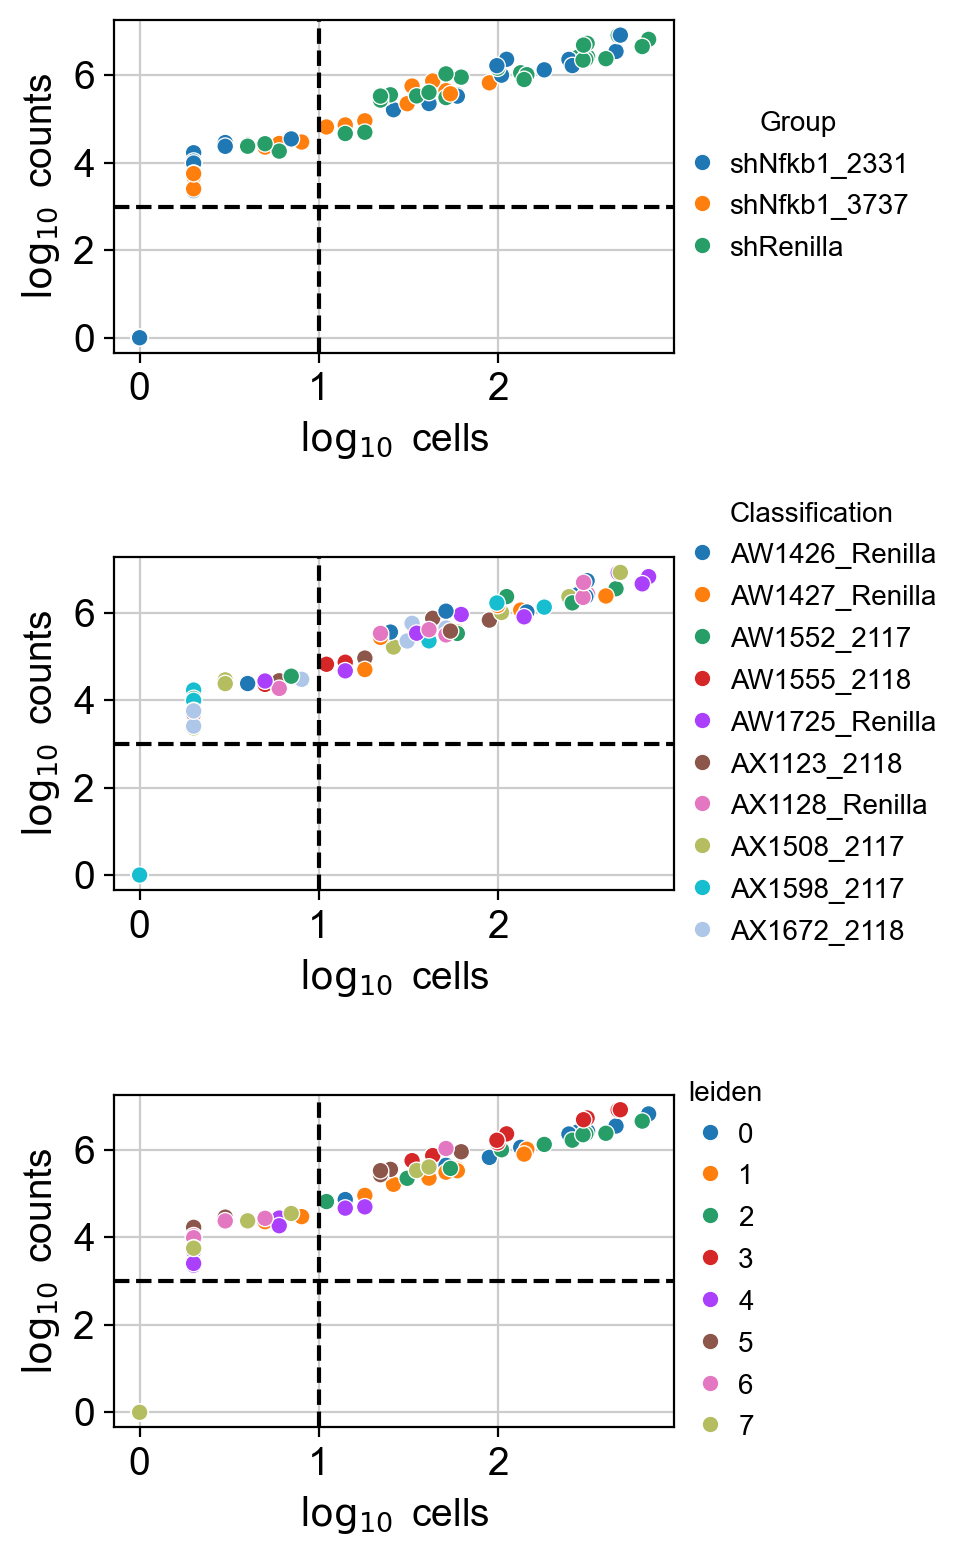

In [86]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["Group", "Classification",'leiden'], 
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

In [87]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

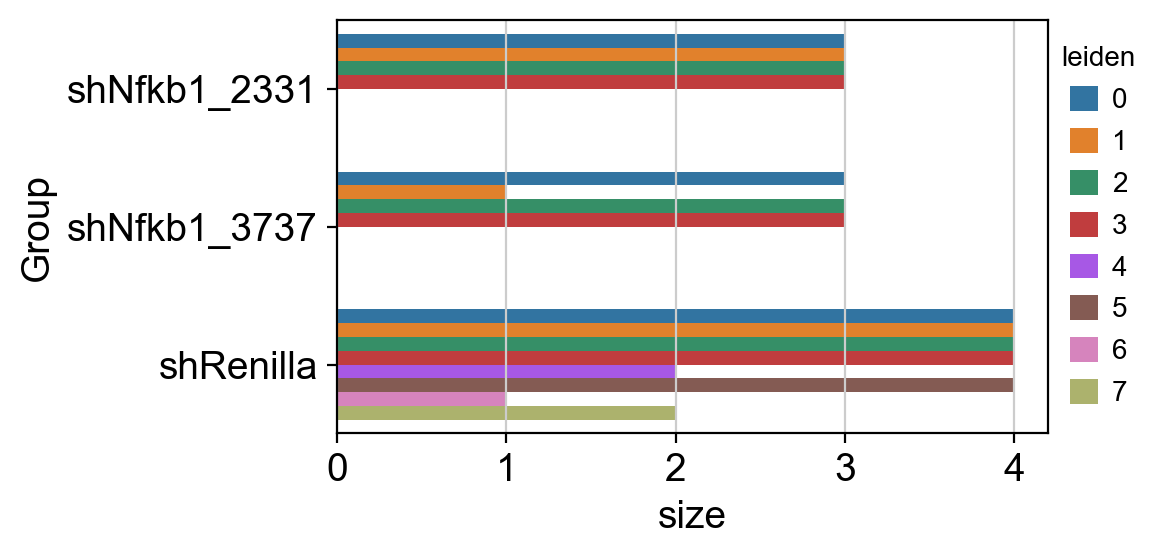

In [88]:
dc.pl.obsbar(adata=pdata, y="Group", hue="leiden", figsize=(6, 3)) 

In [89]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

pdatabak = pdata.copy()
del pdata.obs['shRel']
del pdata.obs['shRela']

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=46
    finished (0:00:00)


In [90]:
import numpy as np
import pandas as pd

print("obsm keys:", list(pdata.obsm.keys()))
print("X_pca shape:", None if "X_pca" not in pdata.obsm else pdata.obsm["X_pca"].shape)

print("\nobs columns:", pdata.obs.columns.tolist())
print("\nobs head:\n", pdata.obs.head())

# how many rows?
print("\nndata:", pdata.n_obs)

# Find candidate grouping columns: non-null and >1 unique value
candidates = []
for c in pdata.obs.columns:
    s = pdata.obs[c]
    nunq = s.dropna().nunique()
    if nunq >= 2:
        candidates.append((c, nunq, str(s.dtype)))
print("\nGrouping candidates (>=2 unique non-NA):")
print(pd.DataFrame(candidates, columns=["col","n_unique","dtype"]).sort_values("n_unique", ascending=False))


obsm keys: ['X_pca']
X_pca shape: (47, 46)

obs columns: ['Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts']

obs head:
                   Classification leiden         Group          batch  \
AW1426_Renilla_0  AW1426_Renilla      0     shRenilla  shNfkb1_lane1   
AW1427_Renilla_0  AW1427_Renilla      0     shRenilla  shNfkb1_lane1   
AW1552_2117_0        AW1552_2117      0  shNfkb1_2331  shNfkb1_lane2   
AW1555_2118_0        AW1555_2118      0  shNfkb1_3737  shNfkb1_lane1   
AW1725_Renilla_0  AW1725_Renilla      0     shRenilla  shNfkb1_lane2   

                 condition  psbulk_cells  psbulk_counts  
AW1426_Renilla_0   control         276.0      2591892.0  
AW1427_Renilla_0   control         132.0      1146443.0  
AW1552_2117_0      perturb         451.0      3527925.0  
AW1555_2118_0      perturb          13.0        73442.0  
AW1725_Renilla_0   control         686.0      6659077.0  

ndata: 47

Grouping candidates (>=2 unique non-NA):
    

In [91]:
dc.tl.rankby_obsm(pdata, key="X_pca")

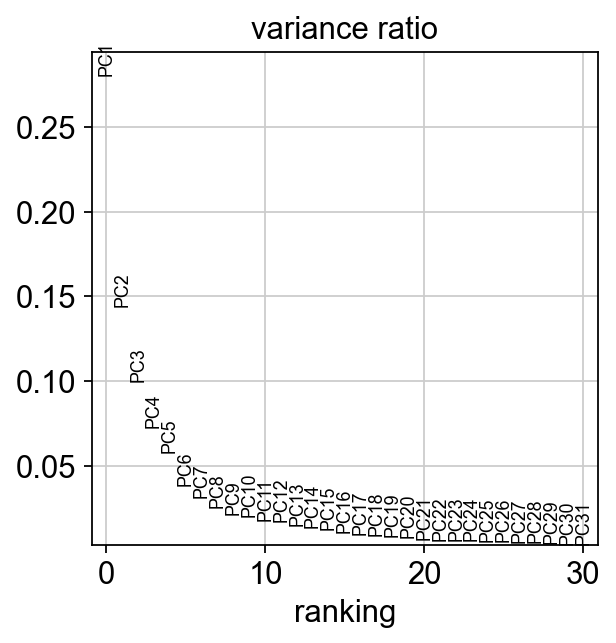

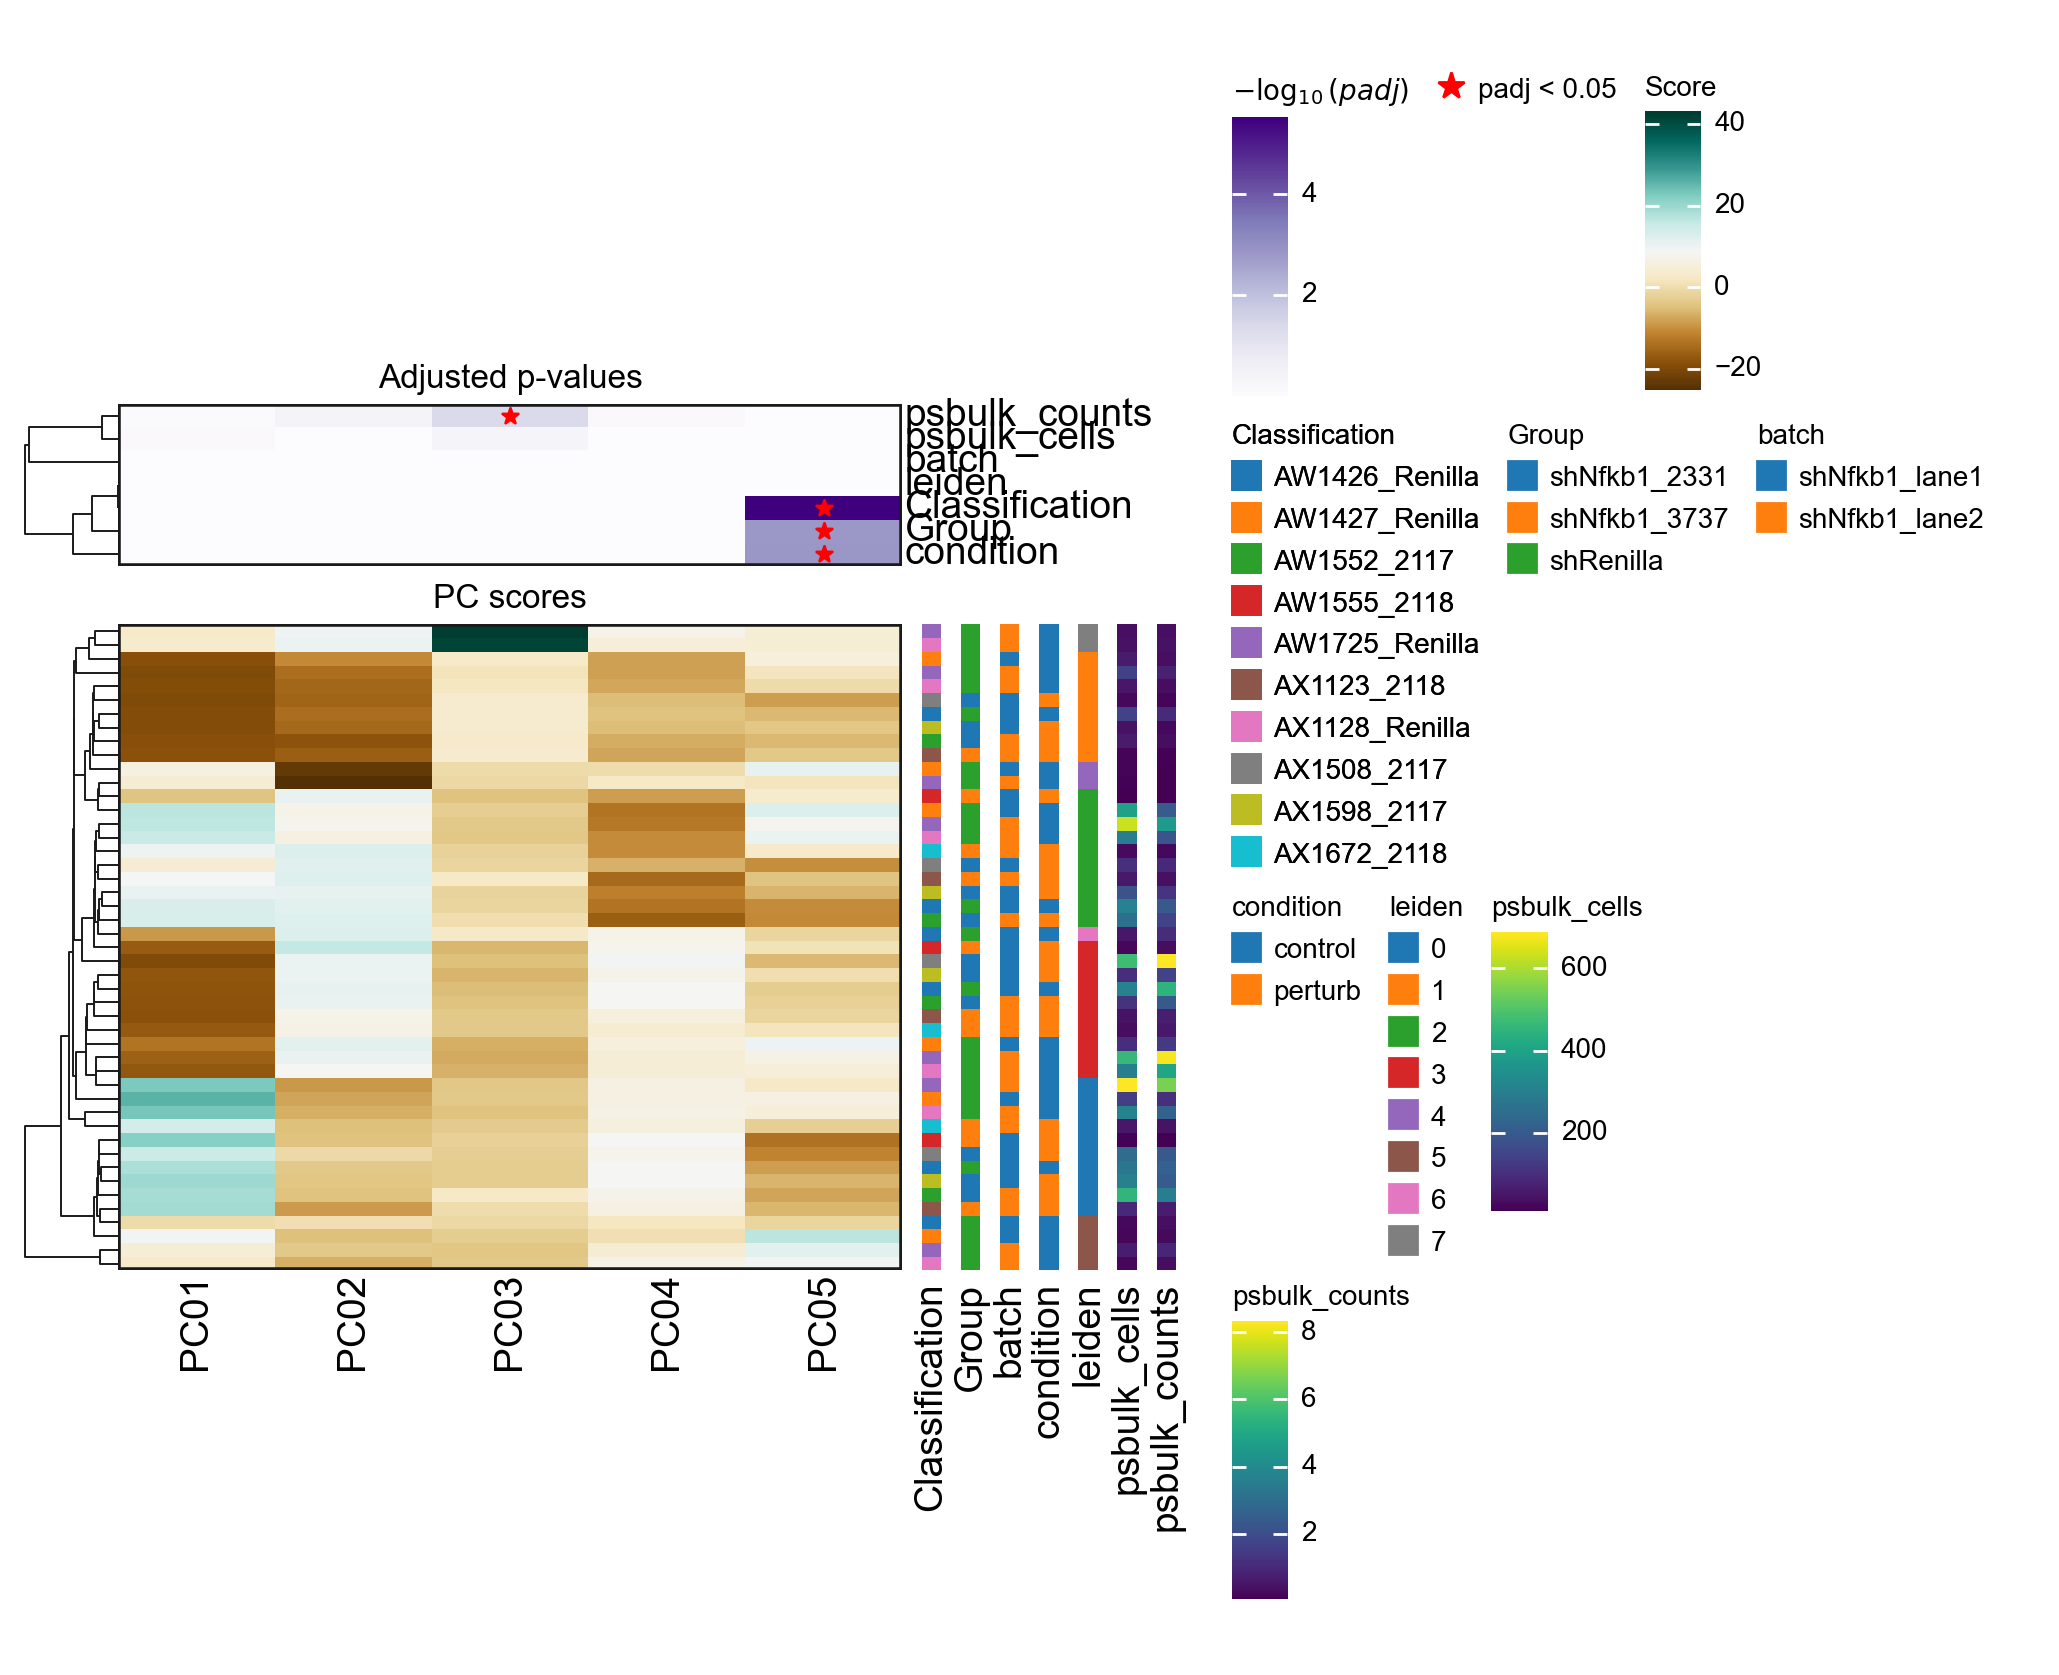

In [92]:
sc.pl.pca_variance_ratio(pdata)
dc.pl.obsm(adata=pdata, return_fig=True, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(10, 5))

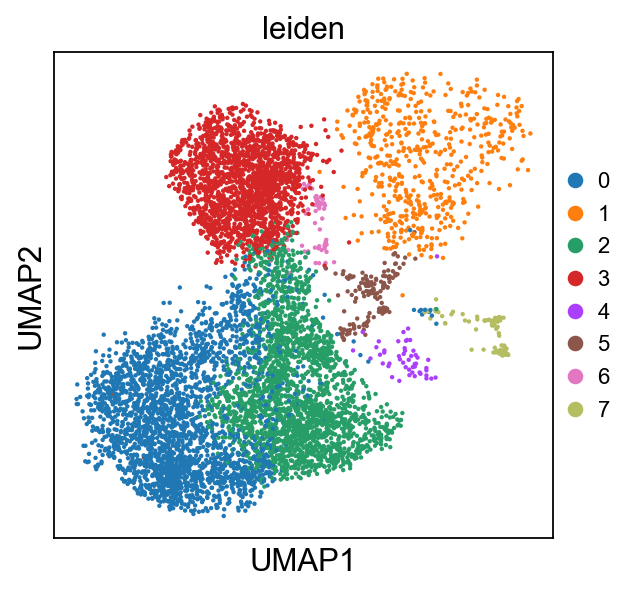

In [93]:
sc.pl.umap(adata, color='leiden')

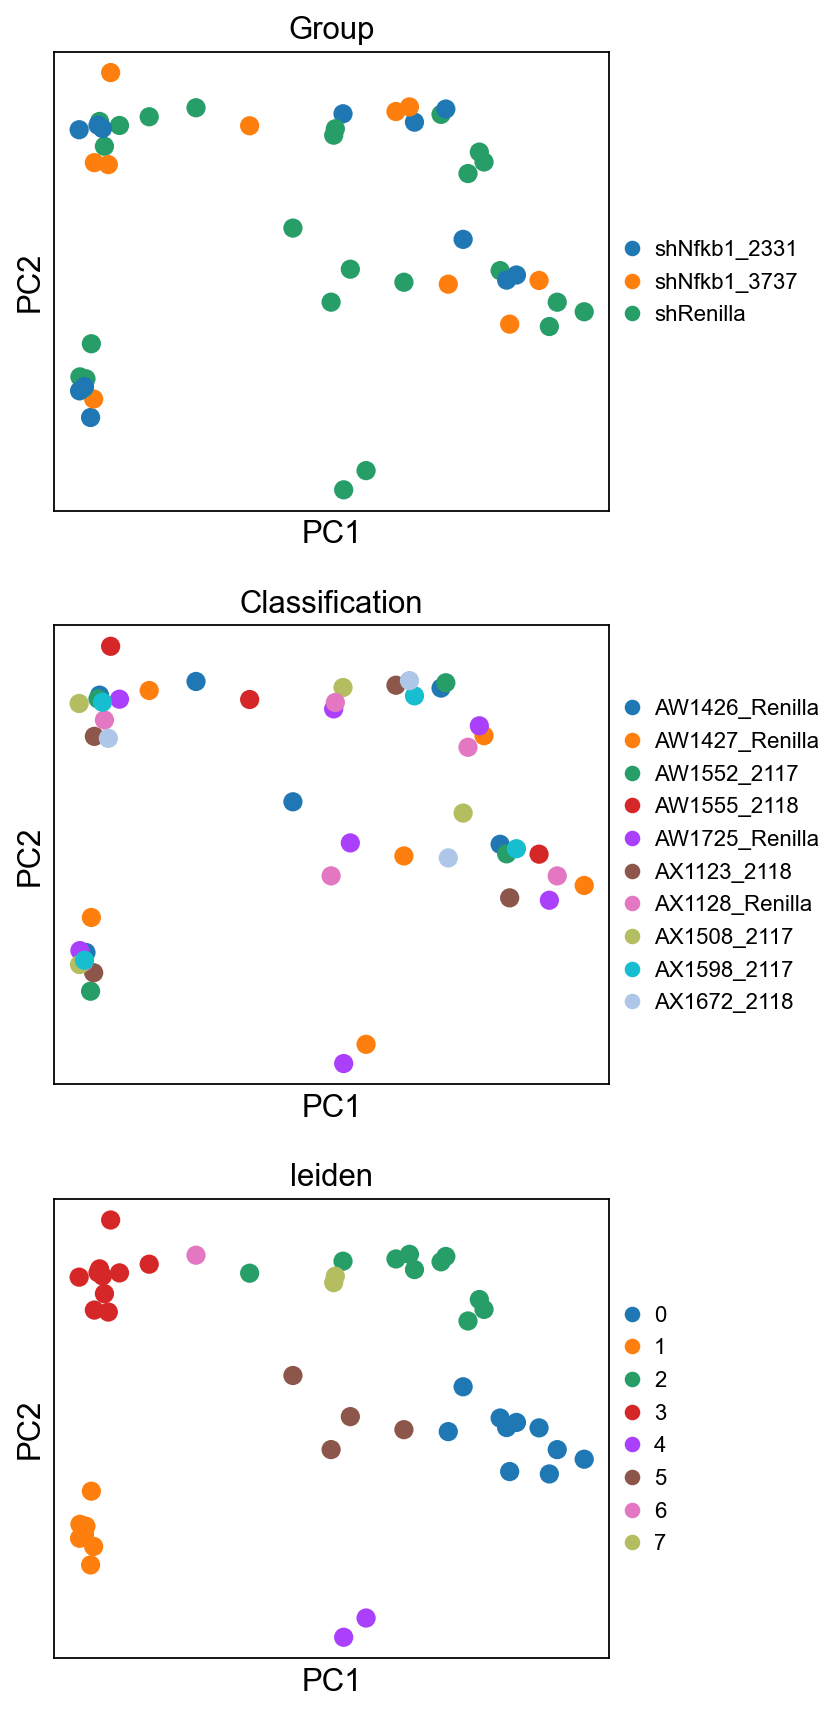

In [94]:
sc.pl.pca(
    pdata,
    color=["Group", "Classification",'leiden'], 
    ncols=1,
    size=300,
    frameon=True,
)

In [95]:
# select relevant samples
#hpcscells = pdata[pdata.obs["leiden"] == "3"].copy()
hpcscells = pdata.copy()
hpcscells

AnnData object with n_obs × n_vars = 47 × 30141
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane

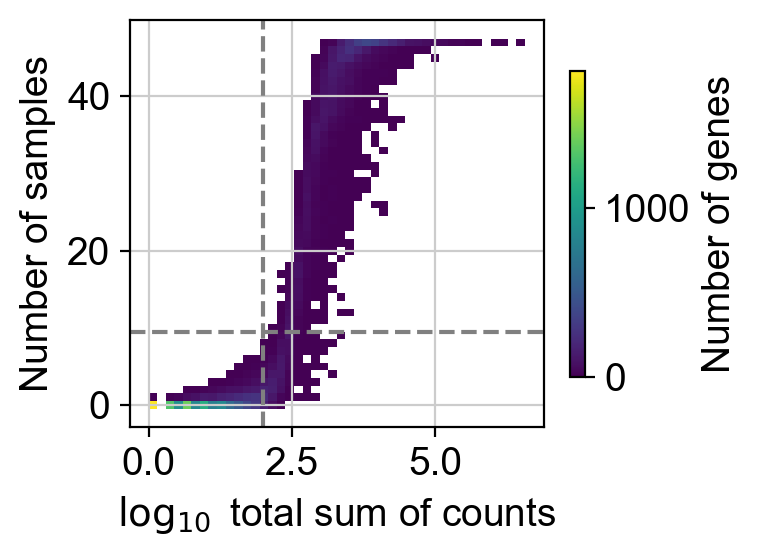

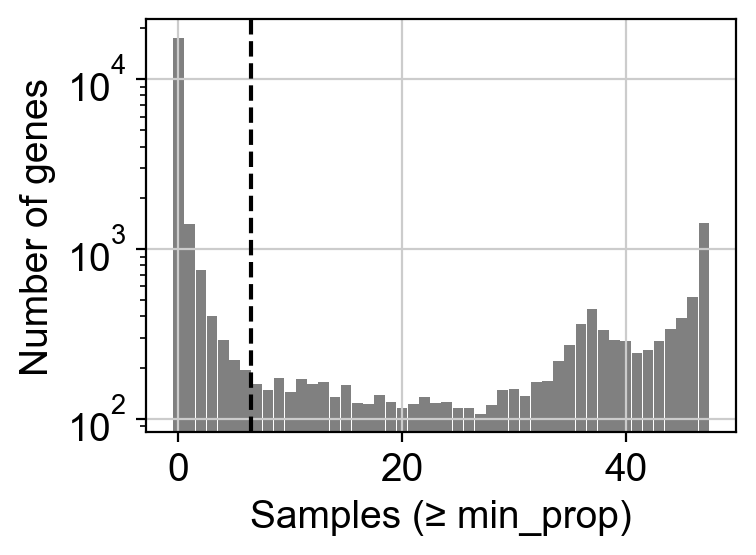

In [96]:
dc.pl.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=5, #10
    min_total_count=100, #15
    large_n=20,
    min_prop=0.1,
)
dc.pl.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=7, #2
)

In [97]:
dc.pp.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=5,
    min_total_count=100,
    large_n=20,
    min_prop=0.1,
)
dc.pp.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=7,
)
hpcscells

AnnData object with n_obs × n_vars = 47 × 9408
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane1

In [98]:
hpcscells.obs["Group"] = (
    hpcscells.obs["Group"]
    .astype("category")
    .cat.reorder_categories(
        ["shRenilla", "shNfkb1_2331", "shNfkb1_3737"],
        ordered=True
    )
)


In [99]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=hpcscells,
    design_factors=["Group"],
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["Group", "shNfkb1_2331", "shRenilla"], inference=inference)

# Compute Wald test
stat_res.summary()

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_3968806/3977653999.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.04 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 4.48 seconds.

Fitting LFCs...
... done in 2.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 32 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Group shNfkb1_2331 vs shRenilla
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Slc3a2    112.609864       -0.389279  0.289053 -1.346739  0.178064  0.999798
Nid1       13.827240       -0.607120  0.722232 -0.840615  0.400564  0.999798
Naxe       77.129274        0.169807  0.180011  0.943313  0.345521  0.999798
Slc25a11   40.065778        0.013272  0.119486  0.111074  0.911558  0.999798
Sppl2b      6.316892        0.131990  0.278111  0.474595  0.635076  0.999798
...              ...             ...       ...       ...       ...       ...
Ube2s     126.891807       -0.187517  0.212603 -0.882008  0.377772  0.999798
Bola1      32.934764       -0.153725  0.121594 -1.264250  0.206140  0.999798
Gfod2       9.860210       -0.351487  0.309950 -1.134014  0.256789  0.999798
Ece1       80.757830        0.261487  0.228722  1.143254  0.252933  0.999798
Psmd8     289.174869        0.471901  0.306298  1.540659  0.123400  0.960253

[9408

... done in 0.84 seconds.



In [100]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Slc3a2    112.609864       -0.389279  0.289053 -1.346739  0.178064  0.999798
Nid1       13.827240       -0.607120  0.722232 -0.840615  0.400564  0.999798
Naxe       77.129274        0.169807  0.180011  0.943313  0.345521  0.999798
Slc25a11   40.065778        0.013272  0.119486  0.111074  0.911558  0.999798
Sppl2b      6.316892        0.131990  0.278111  0.474595  0.635076  0.999798
...              ...             ...       ...       ...       ...       ...
Ube2s     126.891807       -0.187517  0.212603 -0.882008  0.377772  0.999798
Bola1      32.934764       -0.153725  0.121594 -1.264250  0.206140  0.999798
Gfod2       9.860210       -0.351487  0.309950 -1.134014  0.256789  0.999798
Ece1       80.757830        0.261487  0.228722  1.143254  0.252933  0.999798
Psmd8     289.174869        0.471901  0.306298  1.540659  0.123400  0.960253

[9408 rows x 6 columns]

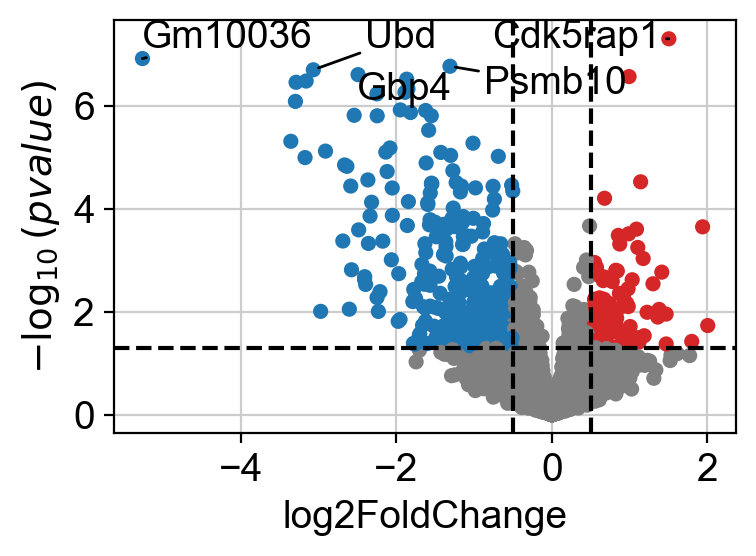

In [101]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

In [102]:
# check Nfkb1 expression
results_df.loc["Nfkb1", ["log2FoldChange", "pvalue", "padj"]]

log2FoldChange   -0.576418
pvalue            0.115738
padj              0.950013
Name: Nfkb1, dtype: float64

In [103]:
adata.obs.groupby(["Group", "Classification"]).size().unstack(fill_value=0)


Classification  AW1426_Renilla  AW1427_Renilla  AW1552_2117  AW1555_2118  \
Group                                                                      
shRenilla                 1118             723            0            0   
shNfkb1_2331                 0               0          887            0   
shNfkb1_3737                 0               0            0           50   

Classification  AW1725_Renilla  AX1123_2118  AX1128_Renilla  AX1508_2117  \
Group                                                                      
shRenilla                 2032            0            1024            0   
shNfkb1_2331                 0            0               0          856   
shNfkb1_3737                 0          206               0            0   

Classification  AX1598_2117  AX1672_2118  
Group                                     
shRenilla                 0            0  
shNfkb1_2331            621            0  
shNfkb1_3737              0          121

In [104]:
import numpy as np, pandas as pd

x = adata.raw[:, "Nfkb1"].X.toarray().ravel()   # guaranteed length = n_obs
tmp = pd.DataFrame({
    "Group": adata.obs["Group"].to_numpy(),
    "Rep": adata.obs["Classification"].to_numpy(),  # mouse id
    "Nfkb1": x
})

rep_means = tmp.groupby(["Group","Rep"])["Nfkb1"].mean().reset_index()
rep_means

per_mouse = tmp.groupby(["Group","Rep"]).agg(
    mean=("Nfkb1","mean"),
    pct_detected=("Nfkb1", lambda v: (v>0).mean()),
    mean_detected=("Nfkb1", lambda v: v[v>0].mean() if (v>0).any() else np.nan),
    n_cells=("Nfkb1","size")
).reset_index()
per_mouse

Group             Rep      mean  pct_detected  mean_detected  \
0  shNfkb1_2331     AW1552_2117  0.224129      0.233371       0.960399   
1  shNfkb1_2331     AX1508_2117  0.196676      0.271028       0.725666   
2  shNfkb1_2331     AX1598_2117  0.220232      0.235105       0.936739   
3  shNfkb1_3737     AW1555_2118  0.261950      0.300000       0.873167   
4  shNfkb1_3737     AX1123_2118  0.201934      0.228155       0.885070   
5  shNfkb1_3737     AX1672_2118  0.227203      0.289256       0.785472   
6     shRenilla  AW1426_Renilla  0.265596      0.345259       0.769265   
7     shRenilla  AW1427_Renilla  0.248072      0.268326       0.924517   
8     shRenilla  AW1725_Renilla  0.288887      0.342520       0.843417   
9     shRenilla  AX1128_Renilla  0.267186      0.305664       0.874118   

   n_cells  
0      887  
1      856  
2      621  
3       50  
4      206  
5      121  
6     1118  
7      723  
8     2032  
9     1024

In [105]:
per_mouse.groupby("Group")[["mean","pct_detected","mean_detected"]].describe()


mean                                                    \
             count      mean       std       min       25%       50%   
Group                                                                  
shNfkb1_2331   3.0  0.213679  0.014854  0.196676  0.208454  0.220232   
shNfkb1_3737   3.0  0.230362  0.030133  0.201934  0.214568  0.227203   
shRenilla      4.0  0.267435  0.016719  0.248072  0.261215  0.266391   

                                 pct_detected            ...            \
                   75%       max        count      mean  ...       75%   
Group                                                    ...             
shNfkb1_2331  0.222180  0.224129          3.0  0.246501  ...  0.253066   
shNfkb1_3737  0.244576  0.261950          3.0  0.272471  ...  0.294628   
shRenilla     0.272612  0.288887          4.0  0.315442  ...  0.343205   

                       mean_detected                                          \
                   max         count      mean       std       min       25%   
Group                                                                          
shNfkb1_2331  0.271028           3.0  0.874268  0.129236  0.725666  0.831202   
shNfkb1_3737  0.300000           3.0  0.847903  0.054393  0.785472  0.829319   
shRenilla     0.345259           4.0  0.852829  0.064972  0.769265  0.824879   

                                            
                   50%       75%       max  
Group                                       
shNfkb1_2331  0.936739  0.948569  0.960399  
shNfkb1_3737  0.873167  0.879118  0.885070  
shRenilla     0.858768  0.886718  0.924517  

[3 rows x 24 columns]

In [106]:
per_mouse.groupby("Group")["n_cells"].describe()


count         mean         std    min     25%     50%     75%  \
Group                                                                         
shNfkb1_2331    3.0   788.000000  145.454460  621.0  738.50   856.0   871.5   
shNfkb1_3737    3.0   125.666667   78.104631   50.0   85.50   121.0   163.5   
shRenilla       4.0  1224.250000  564.240123  723.0  948.75  1071.0  1346.5   

                 max  
Group                 
shNfkb1_2331   887.0  
shNfkb1_3737   206.0  
shRenilla     2032.0

In [107]:
rep_means.groupby("Group")["Nfkb1"].agg(["mean","std","count"])


mean       std  count
Group                                  
shNfkb1_2331  0.213679  0.014854      3
shNfkb1_3737  0.230362  0.030133      3
shRenilla     0.267435  0.016719      4

In [108]:
import numpy as np
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

def _to_counts_df(adata_sub):
    """Return genes x samples integer counts dataframe from AnnData."""
    X = adata_sub.X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)
    # DESeq expects integers
    if not np.all(np.isfinite(X)):
        raise ValueError("Counts contain non-finite values.")
    # rounding only if you KNOW you have counts; otherwise stop
    if not np.all(np.mod(X, 1) == 0):
        raise ValueError("Counts are not integers. Ensure pdata.X is summed raw counts.")
    # pydeseq2 expects samples x genes as a DataFrame in many examples,
    # but DeseqDataSet(adata=...) accepts AnnData directly.
    return X

def run_deseq_by_leiden(
    pdata,
    leiden_col="leiden",
    group_col="Group",
    mouse_col="Classification",
    ref_group="shRenilla",
    contrast_group="shNfkb1_3737",
    gene_of_interest="Nfkb1",
    gene_set=None,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=None,  # set e.g. 50 if you have pdata.obs["n_cells"]
):
    rows = []
    gene_set = gene_set or []

    # optional cell-count filter
    ad = pdata
    if min_cells_per_pseudobulk is not None and "n_cells" in ad.obs.columns:
        ad = ad[ad.obs["n_cells"].astype(int) >= int(min_cells_per_pseudobulk)].copy()

    for k in sorted(ad.obs[leiden_col].unique(), key=lambda x: str(x)):
        sub = ad[ad.obs[leiden_col] == k].copy()

        # mice per group in this state
        mice_by_group = (
            sub.obs[[group_col, mouse_col]]
            .drop_duplicates()
            .groupby(group_col)[mouse_col]
            .nunique()
            .to_dict()
        )

        n_ref = int(mice_by_group.get(ref_group, 0))
        n_con = int(mice_by_group.get(contrast_group, 0))

        # skip underpowered states
        if n_ref < min_mice_per_group or n_con < min_mice_per_group:
            rows.append({
                "leiden": k,
                "status": "skipped_low_mice",
                "n_mice_ref": n_ref,
                "n_mice_contrast": n_con,
                "ref_group": ref_group,
                "contrast_group": contrast_group,
            })
            continue

        # sanity: counts integer?
        _ = _to_counts_df(sub)

        # run DESeq2 for this state
        dds = DeseqDataSet(
            adata=sub,
            design_factors=[group_col],
            refit_cooks=True,
        )
        dds.deseq2()

        stat = DeseqStats(
            dds,
            contrast=[group_col, contrast_group, ref_group],
        )
        stat.summary()
        res = stat.results_df.copy()  # index = genes

        # Pull gene of interest
        if gene_of_interest in res.index:
            goi = res.loc[gene_of_interest]
            goi_lfc = float(goi["log2FoldChange"])
            goi_p = float(goi["pvalue"])
            goi_padj = float(goi["padj"]) if pd.notnull(goi["padj"]) else np.nan
            goi_stat = float(goi["stat"])
        else:
            goi_lfc = goi_p = goi_padj = goi_stat = np.nan

        # Summarize NFkB gene set using DESeq2 stats (directional)
        gs = [g for g in gene_set if g in res.index]
        if len(gs) > 0:
            # Use mean(stat) as a stable directional summary; also record mean(log2FC)
            nfkb_stat_mean = float(np.nanmean(res.loc[gs, "stat"].values))
            nfkb_lfc_mean = float(np.nanmean(res.loc[gs, "log2FoldChange"].values))
            nfkb_n_genes = int(len(gs))
        else:
            nfkb_stat_mean = nfkb_lfc_mean = np.nan
            nfkb_n_genes = 0

        rows.append({
            "leiden": k,
            "status": "ok",
            "n_mice_ref": n_ref,
            "n_mice_contrast": n_con,
            "ref_group": ref_group,
            "contrast_group": contrast_group,
            "gene": gene_of_interest,
            "gene_log2FC": goi_lfc,
            "gene_stat": goi_stat,
            "gene_p": goi_p,
            "gene_padj": goi_padj,
            "nfkb_genes_used": nfkb_n_genes,
            "nfkb_stat_mean": nfkb_stat_mean,
            "nfkb_log2FC_mean": nfkb_lfc_mean,
        })

    out = pd.DataFrame(rows)

    # Nice ordering for reading
    out["leiden"] = out["leiden"].astype(str)
    out = out.sort_values(["status", "leiden"], ascending=[True, True]).reset_index(drop=True)
    return out


In [109]:
tidy_hp2 = run_deseq_by_leiden(
    pdata=pdata,
    ref_group="shRenilla",
    contrast_group="shNfkb1_2331",
    gene_of_interest="Nfkb1",
    gene_set=hallmark_nfkb,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=20,  # set None if you don't have n_cells or don't want filtering
)
tidy_hp2


/tmp/ipykernel_3968806/1828863520.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.00 seconds.

Fitting dispersion trend curve...
/home/chanj2/part2a-decoupler/lib/python3.11/site-packages/pydeseq2/dds.py:820: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 9.57 seconds.

Fitting LFCs...
... done in 7.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.60 seconds.

/tmp/ipykernel_3968806/1828863520.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group shNfkb1_2331 vs shRenilla
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Cd226       0.000000             NaN       NaN       NaN       NaN       NaN
Gak        67.344967        0.027454  0.164042  0.167362  0.867085  0.999194
Acta1       0.312400        1.209298  2.537884  0.476498  0.633719  0.999194
Rtl3        0.000000             NaN       NaN       NaN       NaN       NaN
Aldoa-1     0.000000             NaN       NaN       NaN       NaN       NaN
...              ...             ...       ...       ...       ...       ...
Gm13181     0.318150       -0.018083  4.348472 -0.004158  0.996682  0.999194
Gdpd3       1.976033        1.327116  0.966815  1.372668  0.169856  0.999194
Gm45924     0.040326        0.943695  4.131987  0.228388  0.819345  0.999194
Iqcg        1.641477        1.545957  1.259846  1.227100  0.219785  0.999194
Serpinb12   0.158638       -0.884377  3.459444 -0.255641  0.798228  0.999194

[3014

Fitting dispersions...
... done in 3.53 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 4.58 seconds.

Fitting LFCs...
... done in 4.95 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.48 seconds.

/tmp/ipykernel_3968806/1828863520.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group shNfkb1_2331 vs shRenilla
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Cd226      0.000000             NaN       NaN       NaN       NaN       NaN
Gak        7.921981        0.075788  0.548097  0.138274  0.890024  0.998385
Acta1      0.131309        0.587887  4.208917  0.139676  0.888916  0.998385
Rtl3       0.000000             NaN       NaN       NaN       NaN       NaN
Aldoa-1    0.000000             NaN       NaN       NaN       NaN       NaN
...             ...             ...       ...       ...       ...       ...
Gm13181    0.000000             NaN       NaN       NaN       NaN       NaN
Gdpd3      0.706623        0.147590  1.740277  0.084808  0.932414  0.998385
Gm45924    0.000000             NaN       NaN       NaN       NaN       NaN
Iqcg       0.035354        0.685691  4.222807  0.162378  0.871008  0.998385
Serpinb12  0.781456       -1.122813  2.264141 -0.495911  0.619957  0.998385

[30141 rows x 6 c

Fitting dispersions...
... done in 6.10 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 7.72 seconds.

Fitting LFCs...
... done in 7.09 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.77 seconds.

/tmp/ipykernel_3968806/1828863520.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group shNfkb1_2331 vs shRenilla
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
Cd226       0.042224        0.293454  4.204559  0.069794  0.944357      NaN
Gak        47.006867        0.059494  0.193958  0.306737  0.759044  0.96256
Acta1       0.560776        0.840265  2.880811  0.291676  0.770534      NaN
Rtl3        0.000000             NaN       NaN       NaN       NaN      NaN
Aldoa-1     0.000000             NaN       NaN       NaN       NaN      NaN
...              ...             ...       ...       ...       ...      ...
Gm13181     0.000000             NaN       NaN       NaN       NaN      NaN
Gdpd3       1.151093        1.106673  0.986626  1.121674  0.262001      NaN
Gm45924     0.000000             NaN       NaN       NaN       NaN      NaN
Iqcg        1.291996        0.354984  1.112757  0.319013  0.749717      NaN
Serpinb12   0.425831       -0.160523  2.385609 -0.067288  0.946352      NaN

[30141 rows x 6 c

Fitting dispersions...
... done in 6.63 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 8.11 seconds.

Fitting LFCs...
... done in 7.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.61 seconds.



Log2 fold change & Wald test p-value: Group shNfkb1_2331 vs shRenilla
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Cd226       0.208770       -0.586877  3.602310 -0.162917  0.870584       NaN
Gak        82.652497       -0.063399  0.149151 -0.425066  0.670788  0.964132
Acta1       0.095538       -0.236689  3.965003 -0.059695  0.952399       NaN
Rtl3        0.000000             NaN       NaN       NaN       NaN       NaN
Aldoa-1     0.000000             NaN       NaN       NaN       NaN       NaN
...              ...             ...       ...       ...       ...       ...
Gm13181     0.023952        1.219586  4.182384  0.291601  0.770592       NaN
Gdpd3      16.495626        0.002029  0.375373  0.005405  0.995688  0.998573
Gm45924     0.114435        1.181240  3.926679  0.300824  0.763549       NaN
Iqcg        3.304505        0.831246  1.052737  0.789605  0.429759       NaN
Serpinb12   2.516581        0.159810  0.995251  0.160573  0.872430       NaN

[3014

leiden            status  n_mice_ref  n_mice_contrast  ref_group  \
0      0                ok           4                3  shRenilla   
1      1                ok           4                3  shRenilla   
2      2                ok           4                3  shRenilla   
3      3                ok           4                3  shRenilla   
4      4  skipped_low_mice           2                0  shRenilla   
5      5  skipped_low_mice           4                0  shRenilla   
6      6  skipped_low_mice           1                0  shRenilla   
7      7  skipped_low_mice           2                0  shRenilla   

  contrast_group   gene  gene_log2FC  gene_stat    gene_p  gene_padj  \
0   shNfkb1_2331  Nfkb1    -0.122082  -0.618883  0.535993   0.999194   
1   shNfkb1_2331  Nfkb1    -2.104463  -1.190326  0.233918   0.998385   
2   shNfkb1_2331  Nfkb1    -0.240095  -0.866051  0.386462   0.853499   
3   shNfkb1_2331  Nfkb1    -0.651566  -3.611484  0.000304   0.096419   
4   shNfkb1_2331    NaN          NaN        NaN       NaN        NaN   
5   shNfkb1_2331    NaN          NaN        NaN       NaN        NaN   
6   shNfkb1_2331    NaN          NaN        NaN       NaN        NaN   
7   shNfkb1_2331    NaN          NaN        NaN       NaN        NaN   

   nfkb_genes_used  nfkb_stat_mean  nfkb_log2FC_mean  
0            198.0        0.349453          0.274326  
1            198.0       -0.457859         -0.444280  
2            198.0       -0.052308          0.007336  
3            198.0       -0.129961         -0.058737  
4              NaN             NaN               NaN  
5              NaN             NaN               NaN  
6              NaN             NaN               NaN  
7              NaN             NaN               NaN

In [110]:
adata.n_obs, adata.raw.n_obs


(7638, 7638)

In [111]:
x = adata.raw[:, "Nfkb1"].X
type(x), x.shape


(scipy.sparse._csr.csr_matrix, (7638, 1))

In [112]:
adata.obs.shape[0], adata.X.shape[0]


(7638, 7638)

## Calculate phenotypic volume

In [113]:
#Phenotypic Volume
def calcPV(matrix):
    if hasattr(matrix, 'toarray'):
        matrix = matrix.toarray()
    
    matrix = np.asarray(matrix, dtype=np.float64)
    gene_cov = np.cov(matrix.T)
    mat = pd.DataFrame(gene_cov)
    eig_vals = np.linalg.eigvalsh(mat)
    return(sum(np.log2(eig_vals[eig_vals > 0])))

In [114]:
from scipy.stats import mannwhitneyu

In [115]:
repeats = 1000

In [116]:
adata.obs['Group'].value_counts()

Group
shRenilla       4897
shNfkb1_2331    2364
shNfkb1_3737     377
Name: count, dtype: int64

In [117]:
matrix = adata[adata.obs['Group'].isin(['shRenilla']),adata.var['highly_variable']].X.copy()
dist1 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist1.append(calcPV(matrix[sample_id]))

In [118]:
matrix = adata[adata.obs['Group'].isin(['shNfkb1_2331']),adata.var['highly_variable']].X.copy()
dist2 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist2.append(calcPV(matrix[sample_id]))

In [119]:
matrix = adata[adata.obs['Group'].isin(['shNfkb1_3737']),adata.var['highly_variable']].X.copy()
dist3 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist3.append(calcPV(matrix[sample_id]))

2026-02-03 18:28:19 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-03 18:28:19 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


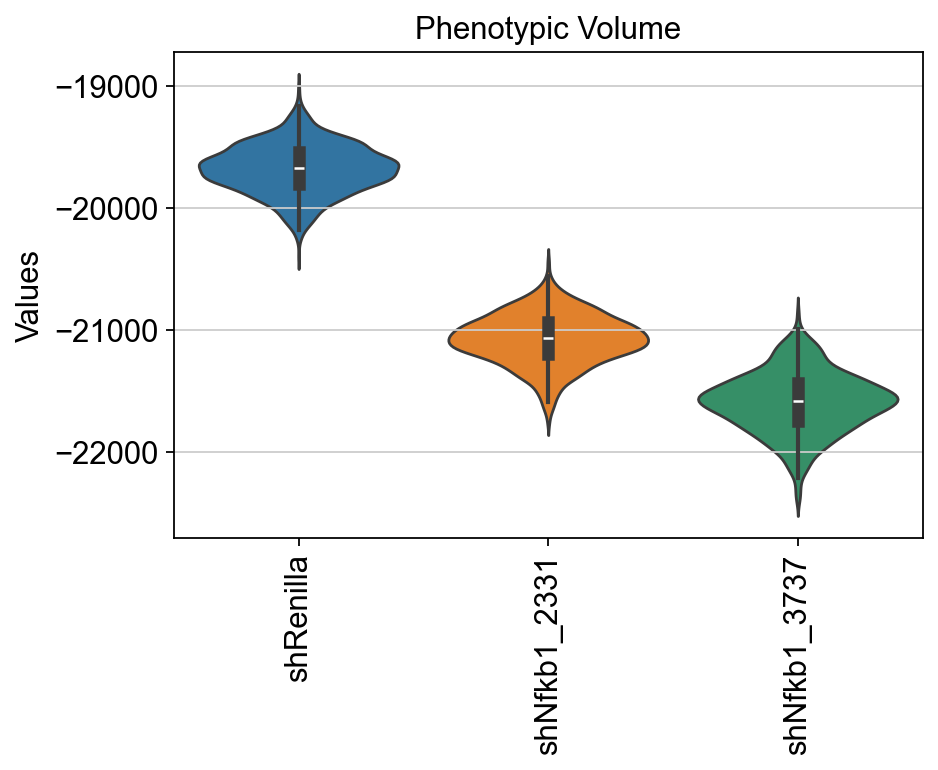

In [120]:
import seaborn as sns
data = [dist1, dist2, dist3]
labels = ["shRenilla", "shNfkb1_2331", "shNfkb1_3737"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1, 2], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.show()

## Figures for the paper

### Look within whole tumor

2026-02-03 18:28:19 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-03 18:28:19 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


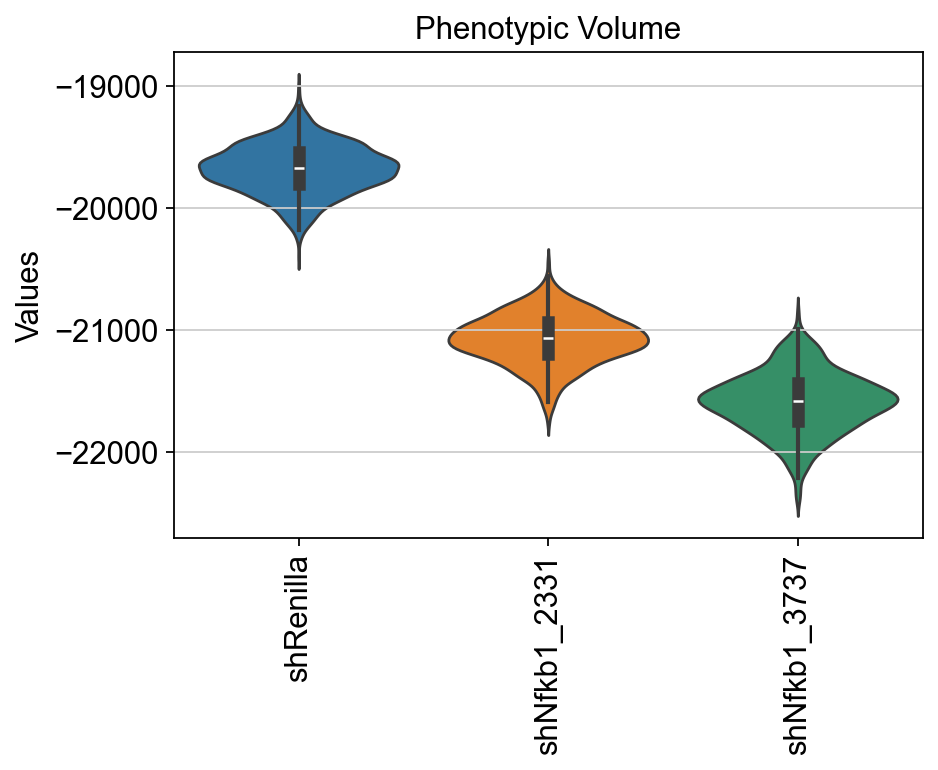

In [121]:
import seaborn as sns
data = [dist1, dist2, dist3]
labels = ["shRenilla", "shNfkb1_2331", "shNfkb1_3737"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1, 2], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.savefig('figures/shNfkb1_PV.svg')
plt.show()

### Look within the HPCS

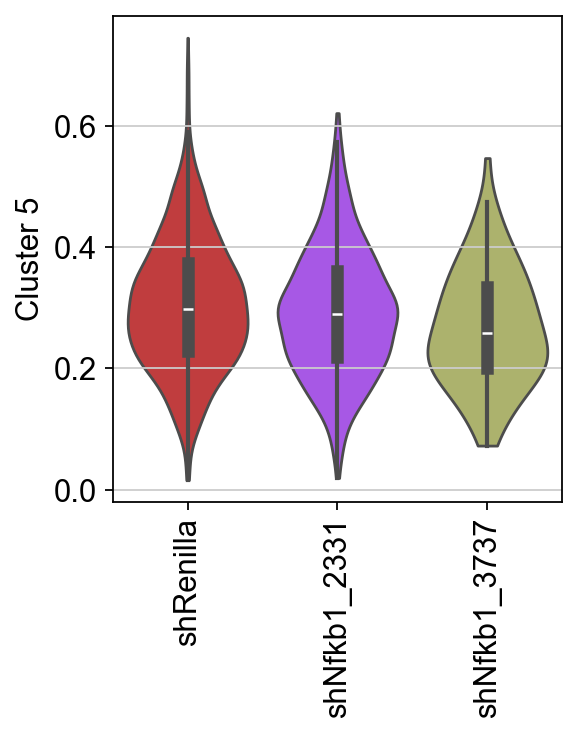

In [122]:
sc.pl.violin(adata2, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True, save='Ext_Data_Fig2a.svg')

In [123]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_2331']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(424804.0), pvalue=np.float64(0.026592859603590983))

In [124]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_3737']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(67720.0), pvalue=np.float64(0.0007887801182817223))

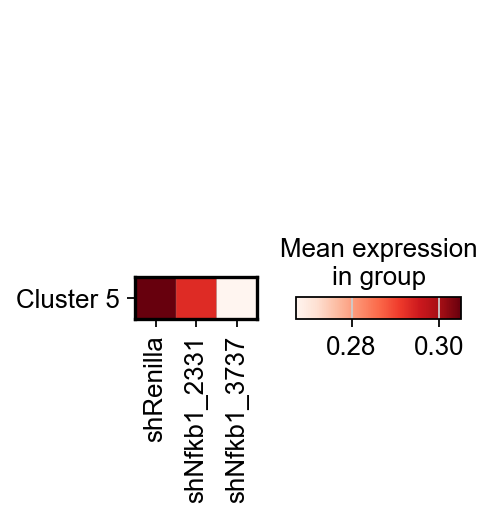

In [125]:
sc.pl.matrixplot(adata2, ['Cluster 5'], groupby='Group',cmap='Reds',swap_axes=True,save='Fig_1l_shCNfkb1.svg')

In [126]:
import scipy
scipy.stats.ttest_ind(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_2331']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(2.3269005818622714), pvalue=np.float64(0.020077908546377372), df=np.float64(1852.0))

In [127]:
import scipy
scipy.stats.ttest_ind(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1_3737']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(3.304551408053142), pvalue=np.float64(0.000977946026814668), df=np.float64(1264.0))

In [128]:
#gseapy.dotplot(enr0.res2d,title="%s shNfkb1_2331 Up" % gsets,cmap="RdBu_r",ofname='figures/shNfkb1_2331_HallmarkUp_Enrichr.svg')
gseapy.dotplot(enr1.res2d,title="%s shNfkb1_2331 Down" % gsets,cmap="RdBu_r",ofname='figures/Ext_Data_Fig2c_shNfkb1_2331_HallmarkDown_Enrichr.svg')
#gseapy.dotplot(enr2.res2d,title="%s shNfkb1_3737 Up" % gsets,cmap="RdBu_r") #nothing reaches significance
gseapy.dotplot(enr3.res2d,title="%s shNfkb1_3737 Down" % gsets,cmap="RdBu_r",ofname='figures/Ext_Data_Fig2d_shNfkb1_3737_HallmarkDown_Enrichr.svg')